<a href="https://colab.research.google.com/github/Anmol18125/AI-Based-Resume-Builder/blob/main/Consumer_Predictions_based_superstore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ngboost
!pip install scikit-optimize
!pip install ngboost
!pip install feature_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings, joblib, gc, re, time
warnings.filterwarnings('ignore')
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, SGDRegressor, PoissonRegressor, RANSACRegressor, TheilSenRegressor, GammaRegressor, ARDRegression, TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor # This line was causing the error because 'ngboost' was not installed.
from sklearn.neural_network import MLPRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile, SelectFromModel, RFE, SequentialFeatureSelector
from mlxtend.plotting import plot_decision_regions
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from sklearn.impute import SimpleImputer
from yellowbrick.regressor import PredictionError, ResidualsPlot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 7.7 MB/s eta 0:00:00


INPUT


In [ ]:
df = pd.read_excel('Superstore.xlsx')
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
1       2  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
2       3  CA-2013-138688 2013-06-13 2013-06-17    Second Class    DV-13045   
3       4  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   
4       5  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

DATA EXPLORATION


In [ ]:
df.shape

(9994, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [ ]:
df.drop('Row ID', axis=1, inplace=True)
df.nunique() / len(df)

Order ID         0.501201
Order Date       0.123874
Ship Date        0.133480
Ship Mode        0.000400
Customer ID      0.079348
Customer Name    0.079348
Segment          0.000300
Country          0.000100
City             0.053132
State            0.004903
Postal Code      0.063138
Region           0.000400
Product ID       0.186312
Category         0.000300
Sub-Category     0.001701
Product Name     0.184211
Sales            0.614769
Quantity         0.001401
Discount         0.001201
Profit           0.754953
dtype: float64

In [ ]:
df.isna().sum()

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [ ]:
df.duplicated().sum()

1

In [ ]:
df = df.drop_duplicates()
df.shape

(9993, 20)

In [ ]:
print(df.columns)

#Ensure the column names are correct and present in the DataFrame before dropping them
#For example, if the actual column name is 'Order_ID' instead of 'Order ID', use the correct name:
#df.drop(['Order_ID', 'Customer_ID', 'Customer_Name', 'Product_ID'], axis=1, inplace=True)

#Alternatively, if you're unsure if a column exists, you can use a try-except block:
columns_to_drop = ['Order ID', 'Customer ID', 'Customer Name', 'Product ID']
for column in columns_to_drop:
    try:
        df.drop(column, axis=1, inplace=True)
    except KeyError:
        print(f"Column '{column}' not found in DataFrame. Skipping...")

Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Country', 'City',
       'State', 'Postal Code', 'Region', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')
Column 'Order ID' not found in DataFrame. Skipping...
Column 'Customer ID' not found in DataFrame. Skipping...
Column 'Customer Name' not found in DataFrame. Skipping...
Column 'Product ID' not found in DataFrame. Skipping...


Exploratory Data Analysis
Univariate Analysis

Skewness of Postal Code: -0.12862858810335934
Kurtosis of Postal Code: -1.4931118549547797


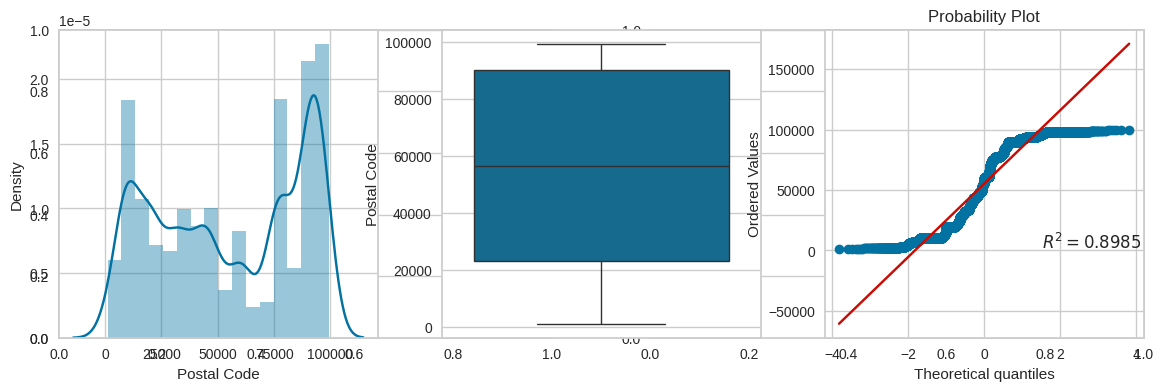

Skewness of Sales: 12.972141558363262
Kurtosis of Sales: 305.28176970634985


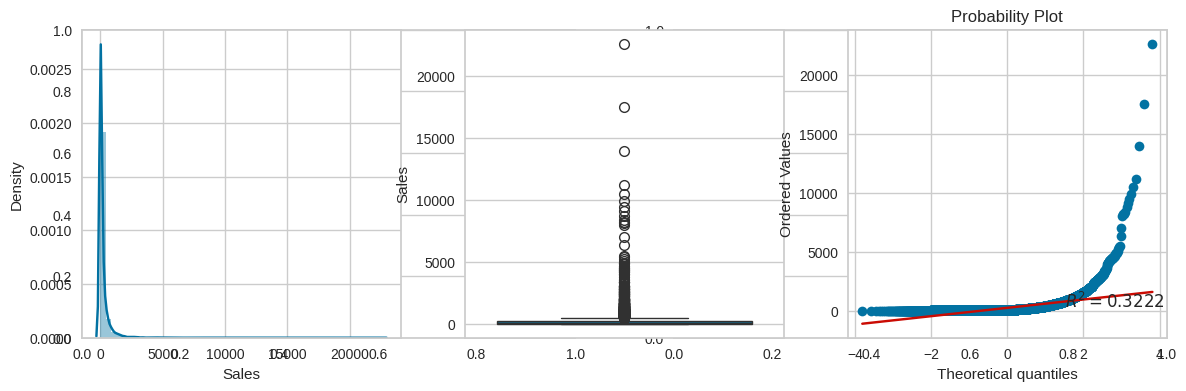

Skewness of Quantity: 1.2784155399852233
Kurtosis of Quantity: 1.9915827160047757


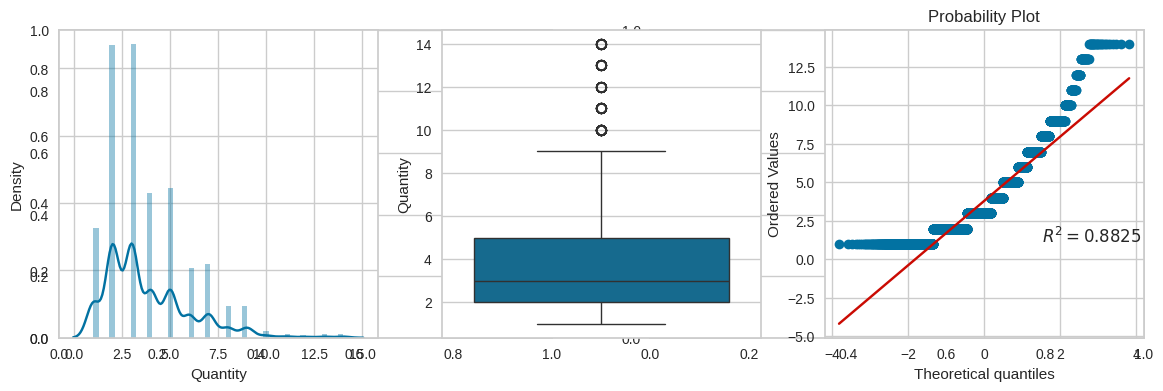

Skewness of Discount: 1.6845084876700462
Kurtosis of Discount: 2.409976524801519


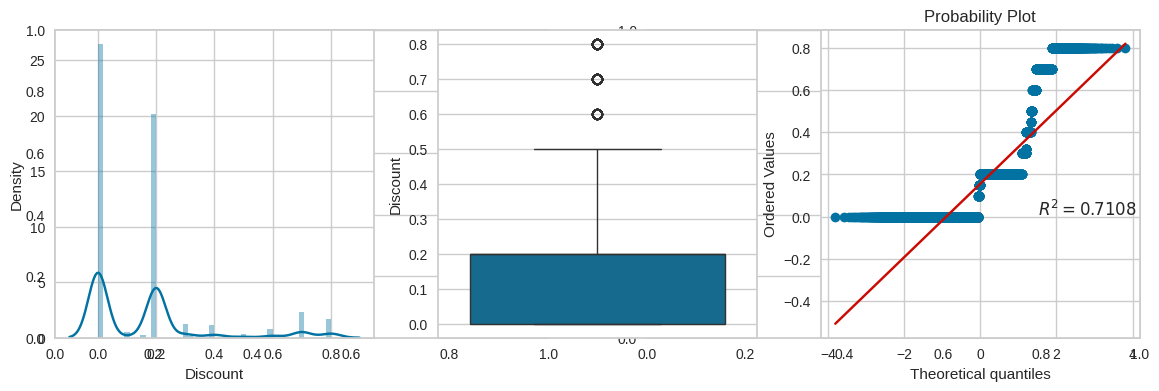

Skewness of Profit: 7.561035996041436
Kurtosis of Profit: 397.15038474389223


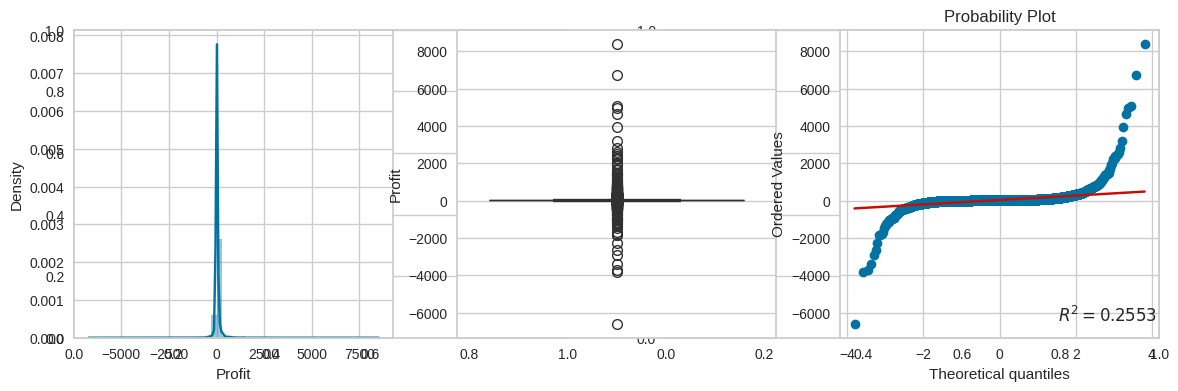

In [ ]:
for col in df.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurt())
    plt.subplots(nrows=1,ncols=2,figsize=(14,4))
    plt.subplot(1,3,1)
    sns.distplot(df[col])
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    probplot(df[col],plot=plt,dist='norm',rvalue=True)
    plt.show()

Exploratory Data Analysis
Univariate Analysis

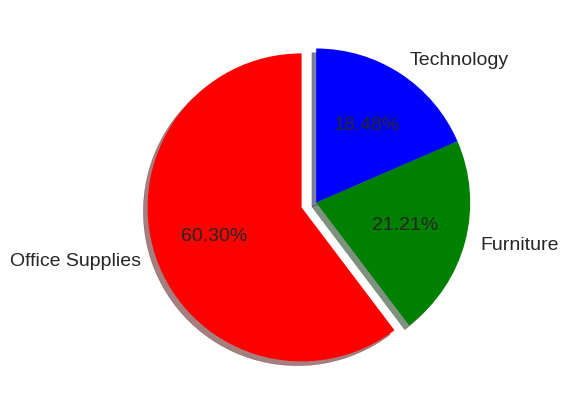

In [ ]:
plt.figure(figsize=(10,5))
labels = df['Category'].value_counts().keys()
values = df['Category'].value_counts().values

plt.pie(values,labels=labels,autopct='%1.2f%%',shadow=True,explode=[0.1,0,0],startangle=90,textprops={'fontsize': 14},colors=['red','green','blue'])
plt.show()

Majority of the products are in Office Supplies category whereas the least number of products are in Technology category.



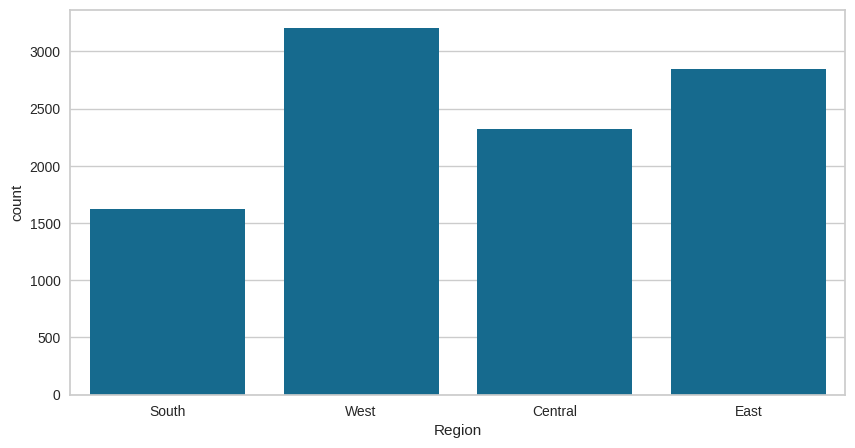

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Region',data=df)
plt.show()

A significant number of customers belong to the Western region while the Southern region has the least number of customers.



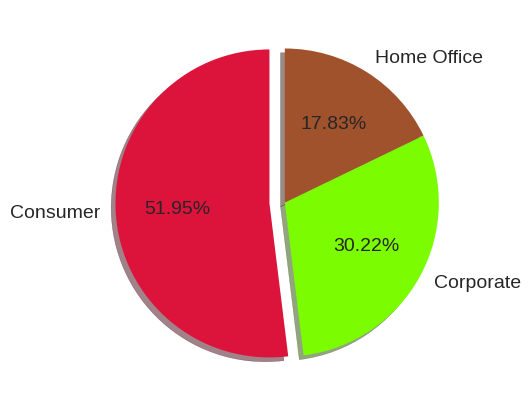

In [ ]:
plt.figure(figsize=(10,5))
labels = df['Segment'].value_counts().keys()
values = df['Segment'].value_counts().values

plt.pie(values,labels=labels,autopct='%1.2f%%',shadow=True,explode=[0.1,0,0],startangle=90,textprops={'fontsize': 14},colors=['crimson','lawngreen','sienna'])
plt.show()

In [ ]:
df['Ship Mode'].value_counts()

Ship Mode
Standard Class    5967
Second Class      1945
First Class       1538
Same Day           543
Name: count, dtype: int64

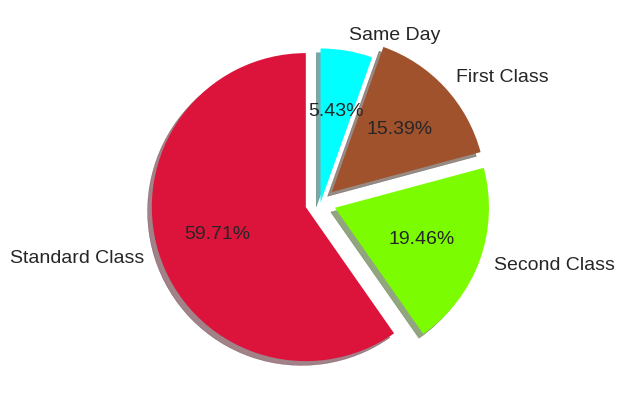

In [ ]:
plt.figure(figsize=(10,5))
labels = df['Ship Mode'].value_counts().keys()
values = df['Ship Mode'].value_counts().values

plt.pie(values,labels=labels,autopct='%1.2f%%',shadow=True,explode=[0.1,0.1,0.1,0],startangle=90,textprops={'fontsize': 14},colors=['crimson','lawngreen','sienna','cyan'])
plt.show()

Bivariate Analysis

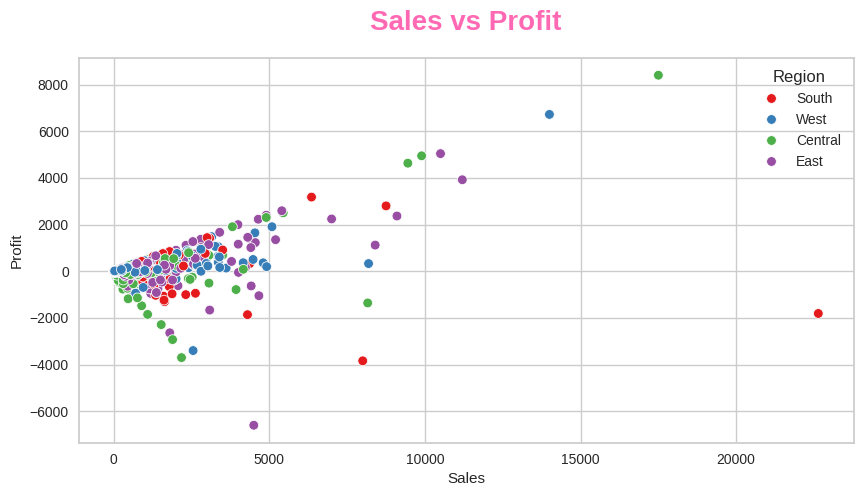

26692

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.scatterplot(x='Sales',y='Profit',data=df,hue='Region',palette='Set1')
plt.title('Sales vs Profit',pad=20,fontsize=20,fontweight='bold',color='hotpink')
plt.show()
plt.close('all')
del fig
gc.collect()

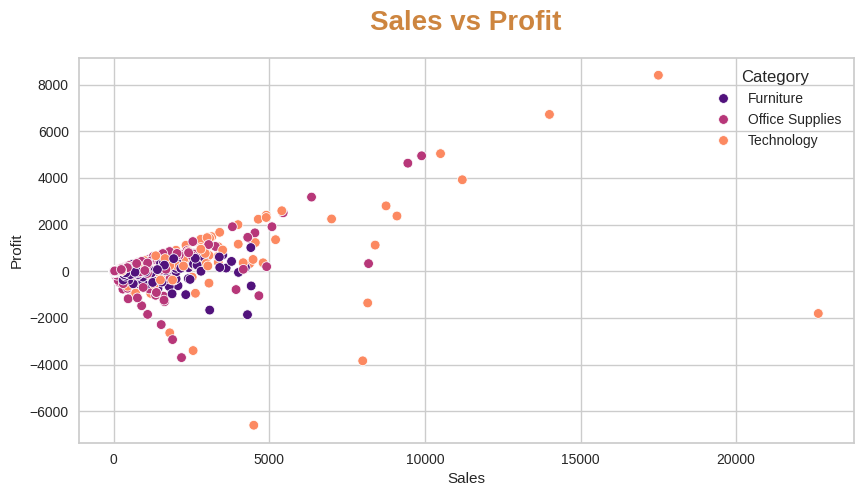

57920

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.scatterplot(x='Sales',y='Profit',data=df,hue='Category',palette='magma')
plt.title('Sales vs Profit',pad=20,fontsize=20,fontweight='bold',color='peru')
plt.show()
plt.close('all')
del fig
gc.collect()

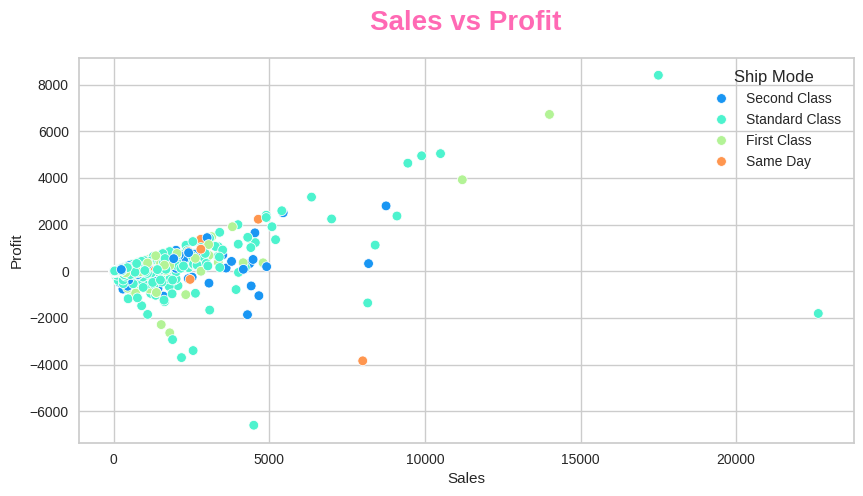

4220

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.scatterplot(x='Sales',y='Profit',data=df,hue='Ship Mode',palette='rainbow')
plt.title('Sales vs Profit',pad=20,fontsize=20,fontweight='bold',color='hotpink')
plt.show()
plt.close('all')
del fig
gc.collect()

Multivariate Analysis

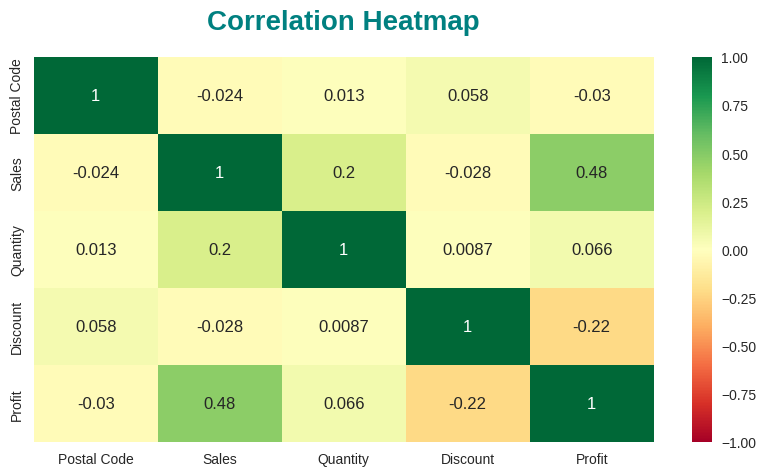

7018

In [ ]:
plt.figure(figsize=(10, 5))
# Calculate correlation only for numeric columns
numeric_df = df.select_dtypes(include=np.number)
fig = sns.heatmap(numeric_df.corr(), annot=True, cmap='RdYlGn', vmin=-1.0, vmax=1.0)
plt.title('Correlation Heatmap', pad=20, fontsize=20, fontweight='bold', color='teal')
plt.show()
plt.close('all')
del fig
gc.collect()

<Figure size 1000x500 with 0 Axes>

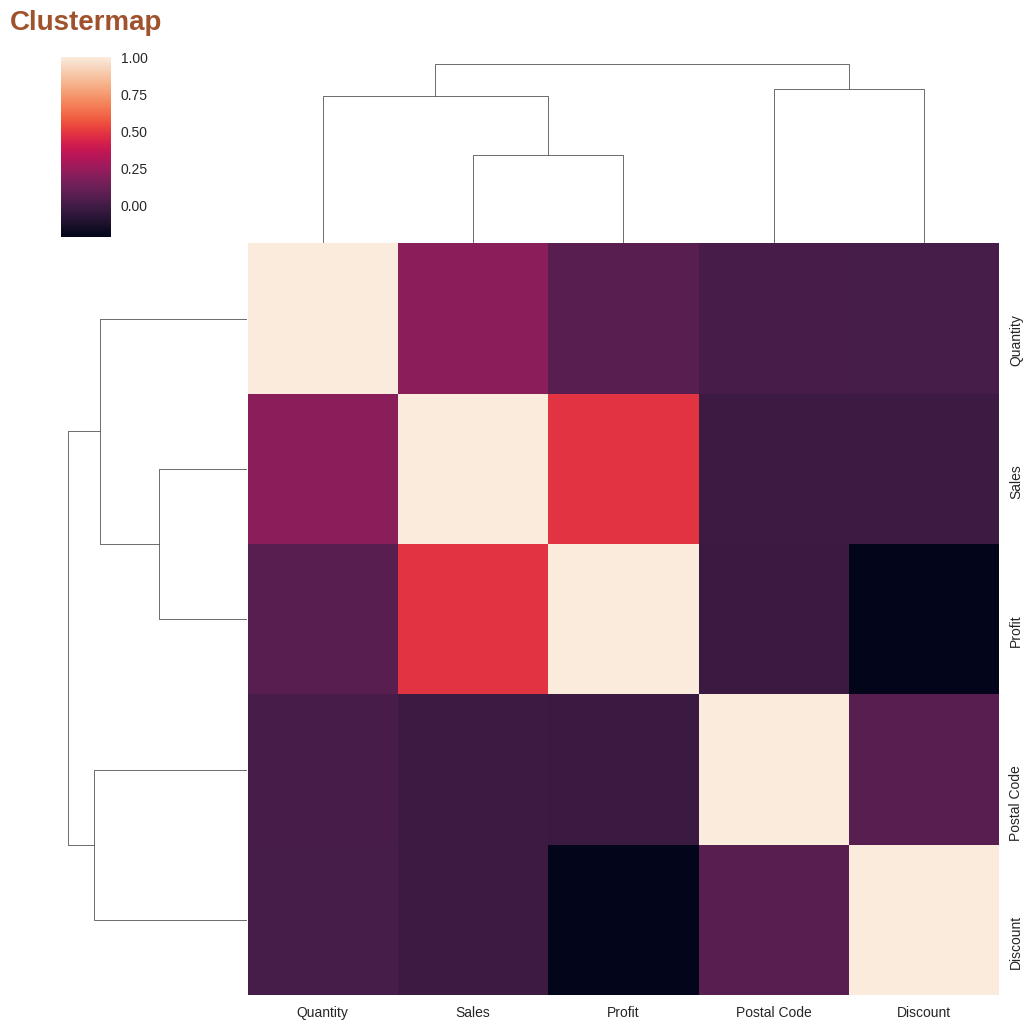

152

In [ ]:
plt.figure(figsize=(10,5))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
fig = sns.clustermap(numeric_df.corr())
plt.title('Clustermap',pad=20,fontsize=20,fontweight='bold',color='sienna')
plt.show()
plt.close('all')
del fig
gc.collect()

<Figure size 1000x500 with 0 Axes>

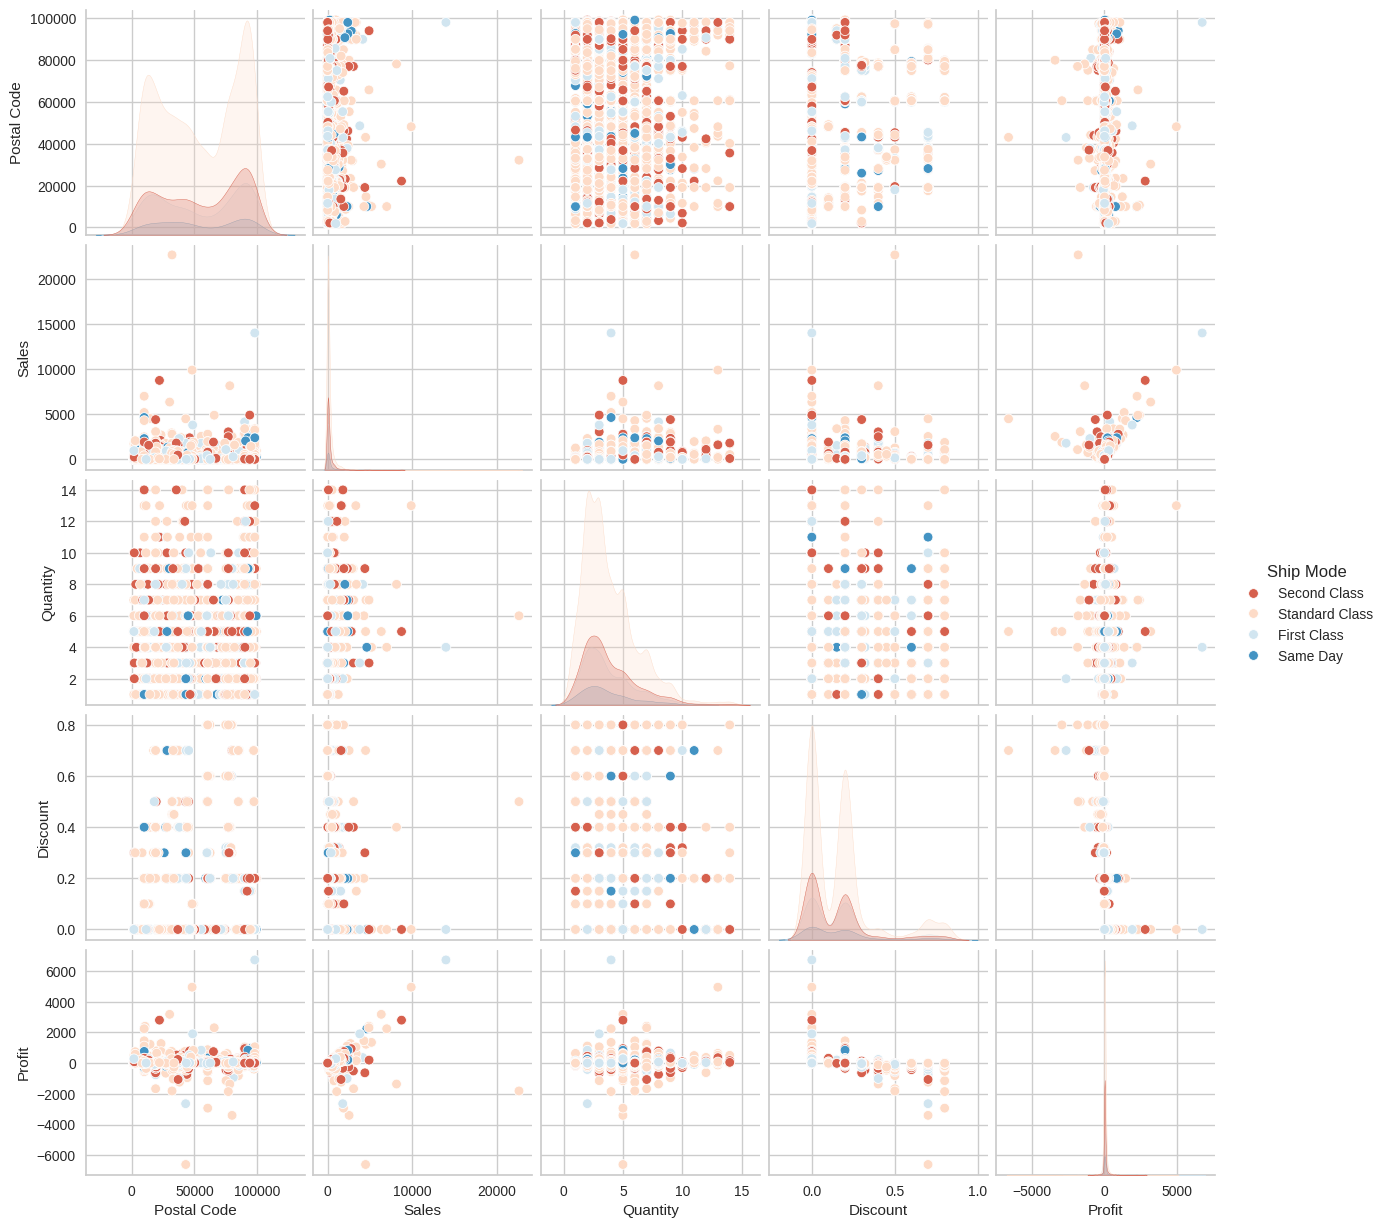

996

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.pairplot(df.sample(n=5000),hue='Ship Mode',palette='RdBu')
plt.show()
plt.close('all')
del fig
gc.collect()

Feature Extraction


In [ ]:
df['Profit Margin'] = df['Profit']/df['Sales']
df['Discounted Profit'] = df['Profit']-df['Profit']*df['Discount']
df['Discount Percentage'] = df['Discount']/df['Sales']*100
df['Operating Expenses'] = df['Sales'] - df['Profit']
df['Net Profit'] = df['Profit'] - df['Discount']
df['Order Date'] = pd.to_datetime(df['Order Date'],errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'],errors='coerce')
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Weekday'] = df['Order Date'].dt.dayofweek
df['Ship Year'] = df['Ship Date'].dt.year
df['Ship Month'] = df['Ship Date'].dt.month
df['Ship Day'] = df['Ship Date'].dt.day
df['Ship Weekday'] = df['Ship Date'].dt.dayofweek
df.drop(['Order Date','Ship Date'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9993
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ship Mode            9993 non-null   object 
 1   Segment              9993 non-null   object 
 2   City                 9993 non-null   object 
 3   State                9993 non-null   object 
 4   Postal Code          9993 non-null   int64  
 5   Region               9993 non-null   object 
 6   Category             9993 non-null   object 
 7   Sub-Category         9993 non-null   object 
 8   Product Name         9993 non-null   object 
 9   Sales                9993 non-null   float64
 10  Quantity             9993 non-null   int64  
 11  Discount             9993 non-null   float64
 12  Profit               9993 non-null   float64
 13  Profit Margin        9993 non-null   float64
 14  Discounted Profit    9993 non-null   float64
 15  Discount Percentage  9993 non-null   float6

Feature Transformation

Skewness of Quantity: 1.2784155399852233
Kurtosis of Quantity: 1.9915827160047757


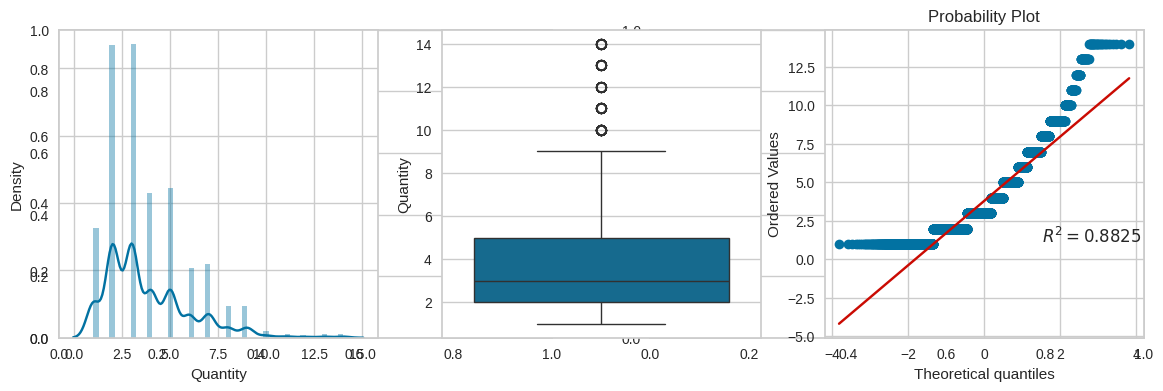

Skewness of Discount: 1.6845084876700462
Kurtosis of Discount: 2.409976524801519


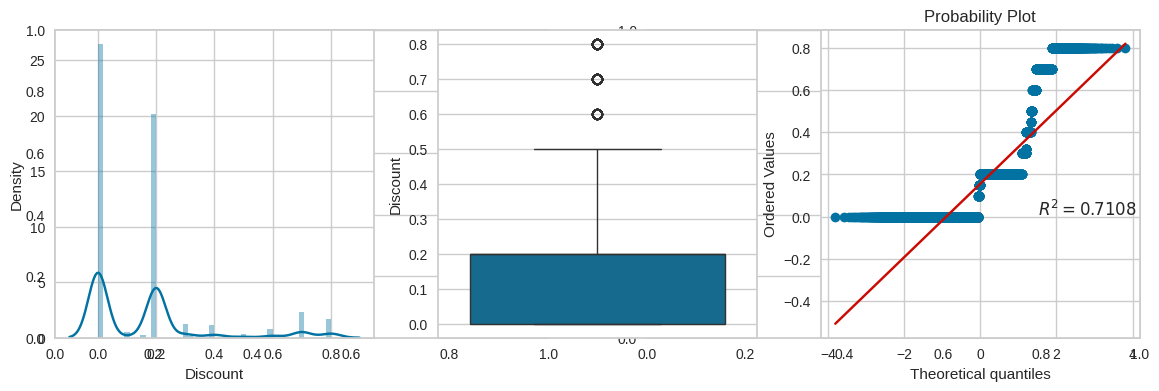

Skewness of Profit: 7.561035996041436
Kurtosis of Profit: 397.15038474389223


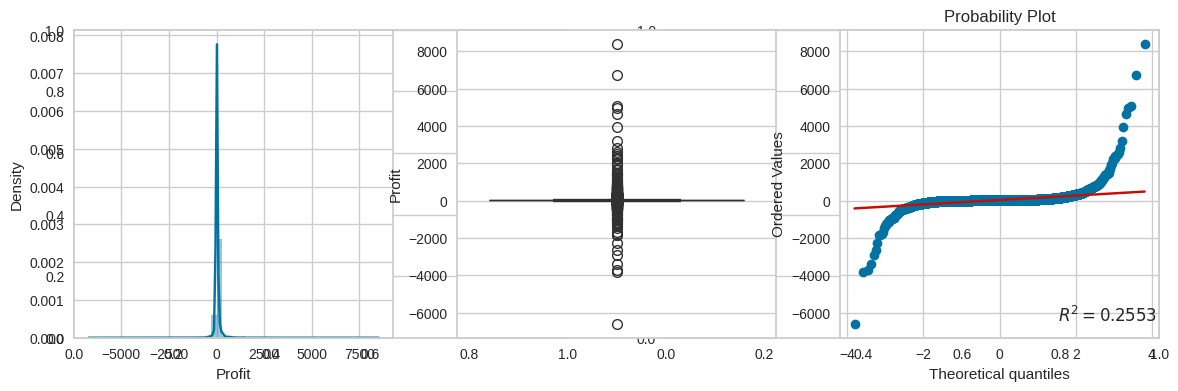

Skewness of Profit Margin: -2.894835315865789
Kurtosis of Profit Margin: 10.172752622828092


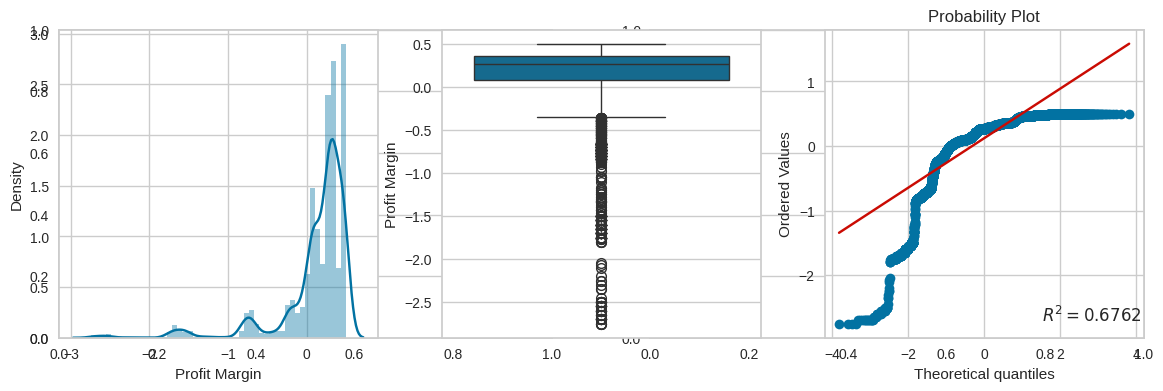

Skewness of Discounted Profit: 19.35659799419806
Kurtosis of Discounted Profit: 617.6369152241313


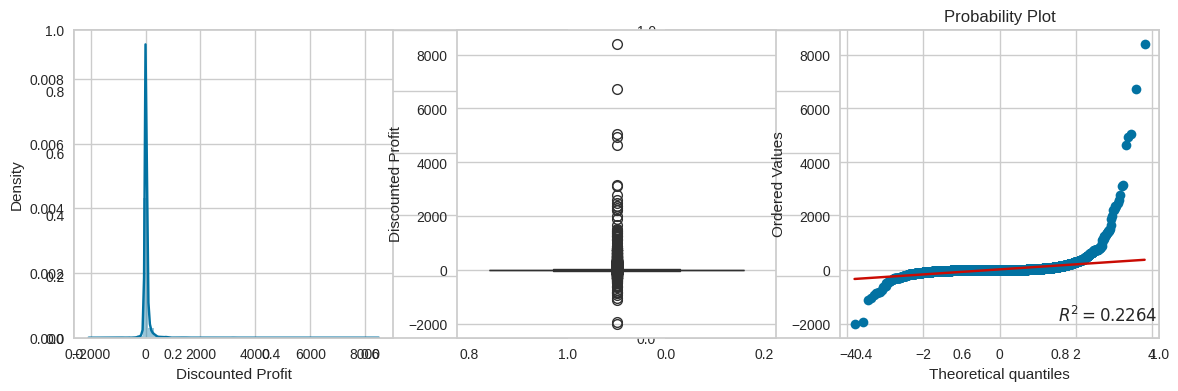

Skewness of Discount Percentage: 10.828151381652273
Kurtosis of Discount Percentage: 188.85920639655157


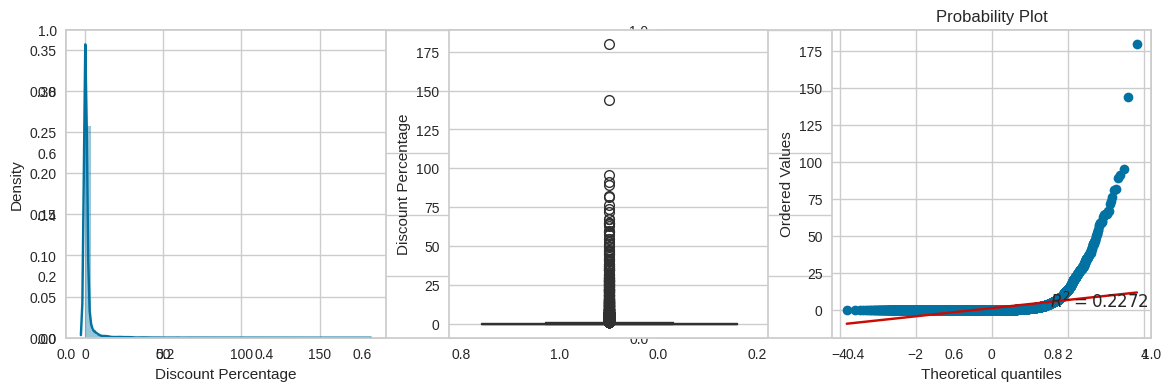

Skewness of Operating Expenses: 14.752446377055431
Kurtosis of Operating Expenses: 454.5499992208234


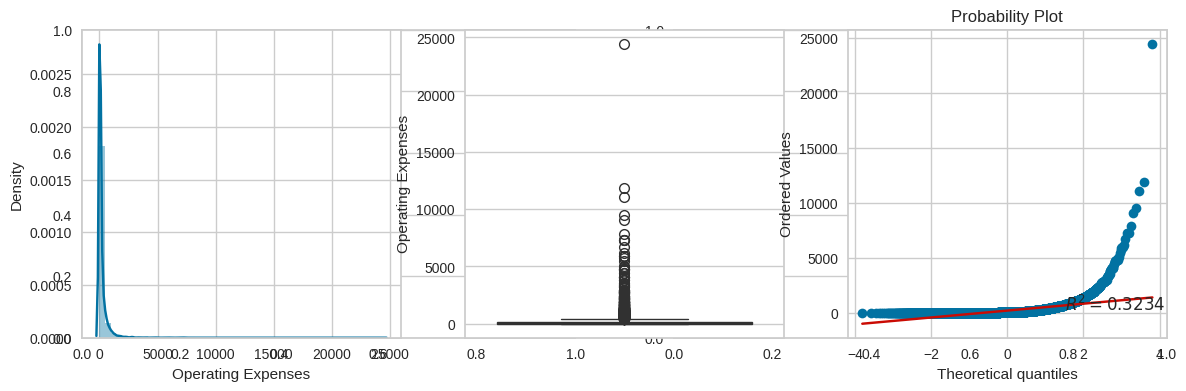

Skewness of Net Profit: 7.555768996026929
Kurtosis of Net Profit: 396.9091881919584


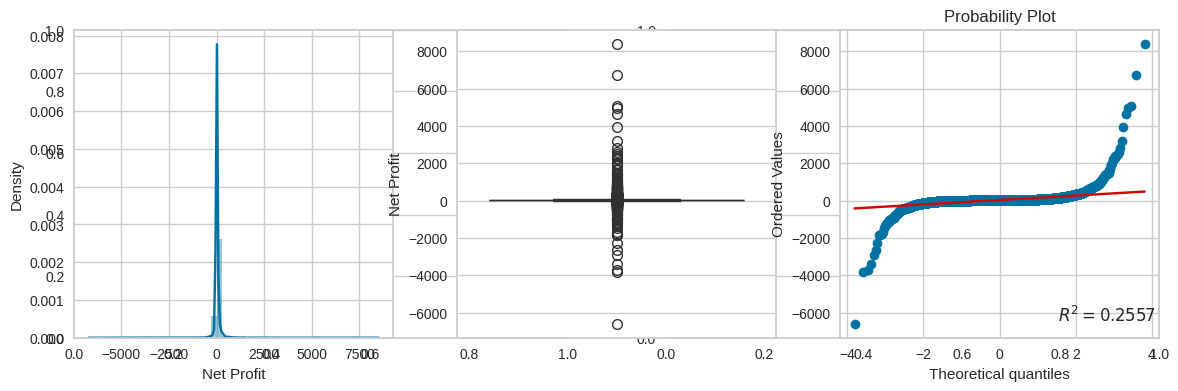

Skewness of Order Day: 0.013550065823461663
Kurtosis of Order Day: -1.1861898468255059


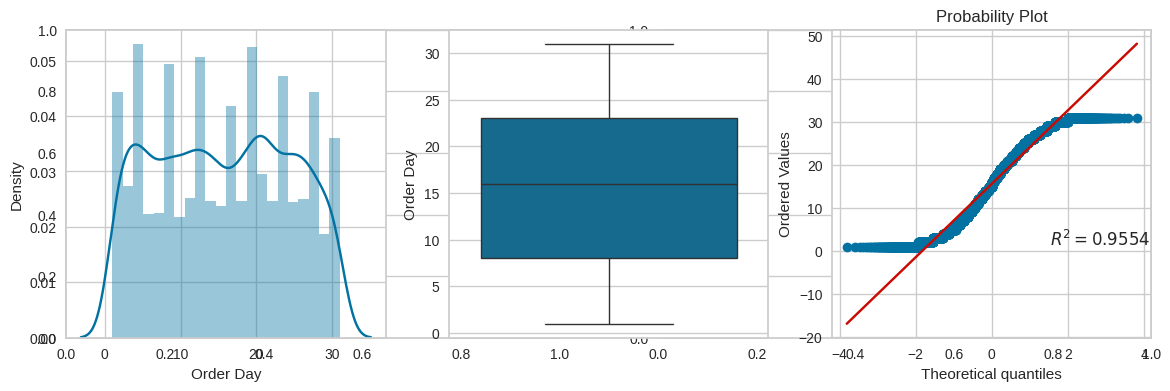

Skewness of Order Weekday: 0.12340952691336028
Kurtosis of Order Weekday: -1.0869179921056922


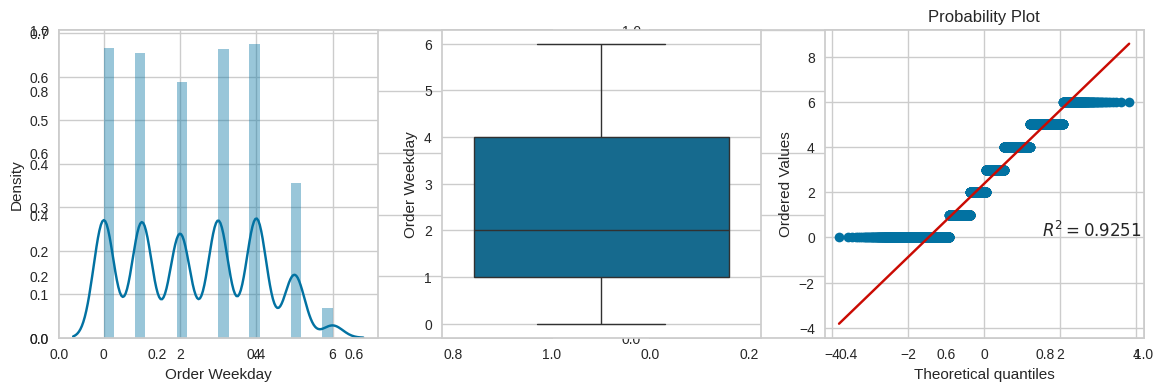

Skewness of Order Month: -0.4329511345177871
Kurtosis of Order Month: -0.9846637321437535


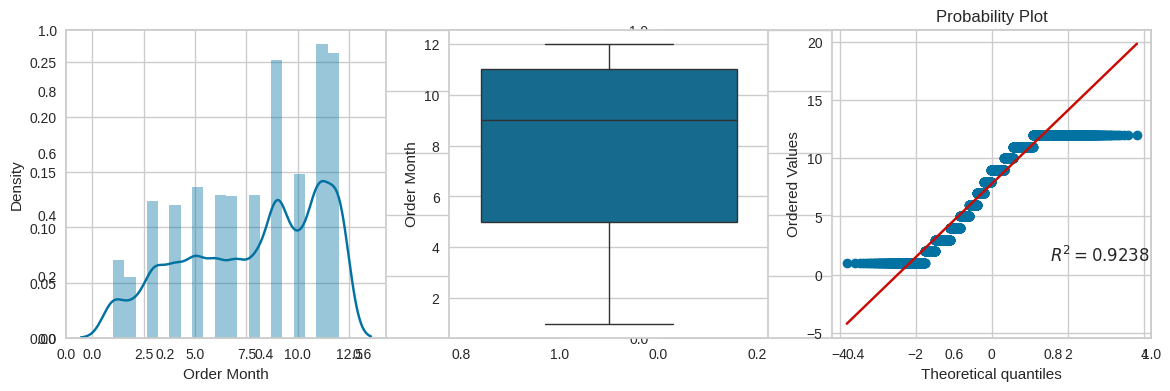

Skewness of Ship Day: -0.012355797229445813
Kurtosis of Ship Day: -1.2070053450291567


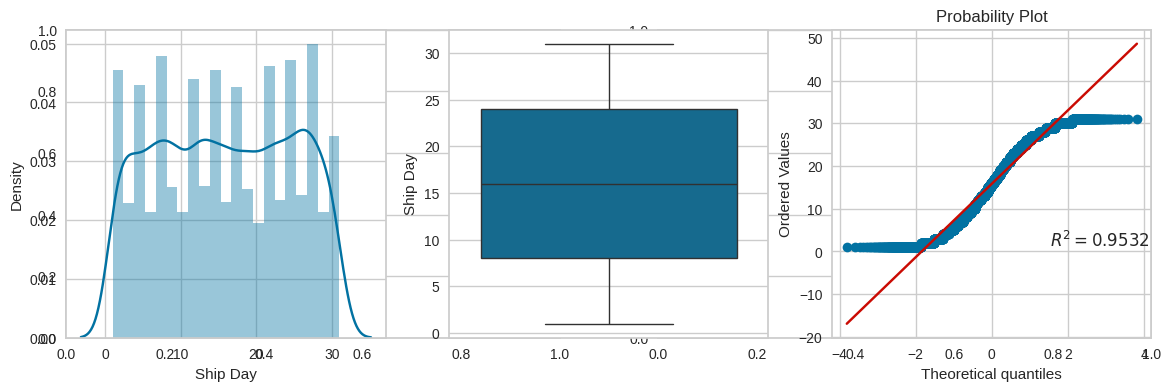

In [ ]:
skewed_cols = ['Quantity',
 'Discount',
 'Profit',
 'Profit Margin',
 'Discounted Profit',
 'Discount Percentage',
 'Operating Expenses',
 'Net Profit',
 'Order Day',
 'Order Weekday',
 'Order Month',
 'Ship Day']
for col in skewed_cols:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurt())
    plt.subplots(nrows=1,ncols=2,figsize=(14,4))
    plt.subplot(1,3,1)
    sns.distplot(df[col])
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    probplot(df[col],plot=plt,dist='norm',rvalue=True)
    plt.show()

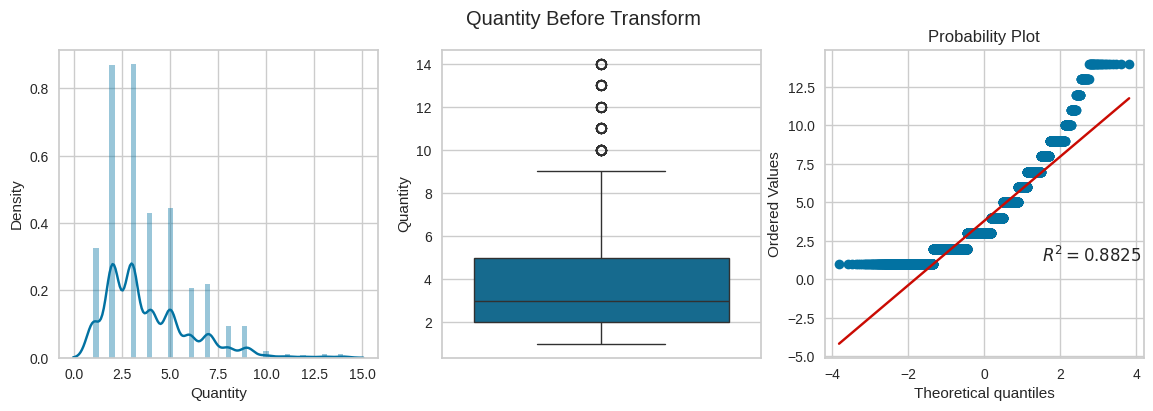

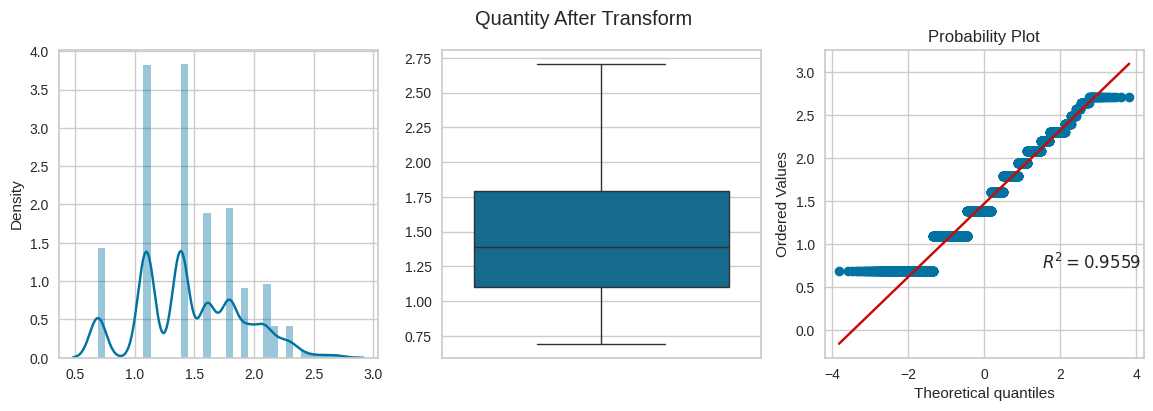

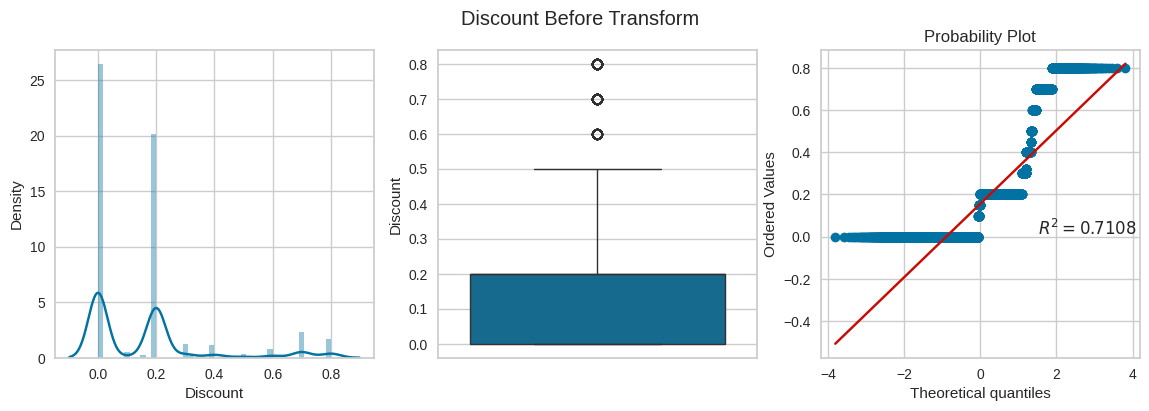

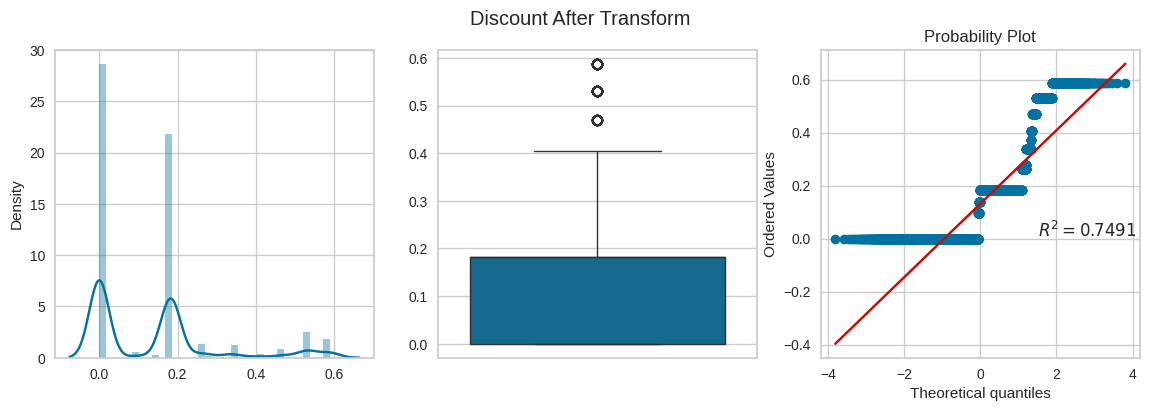

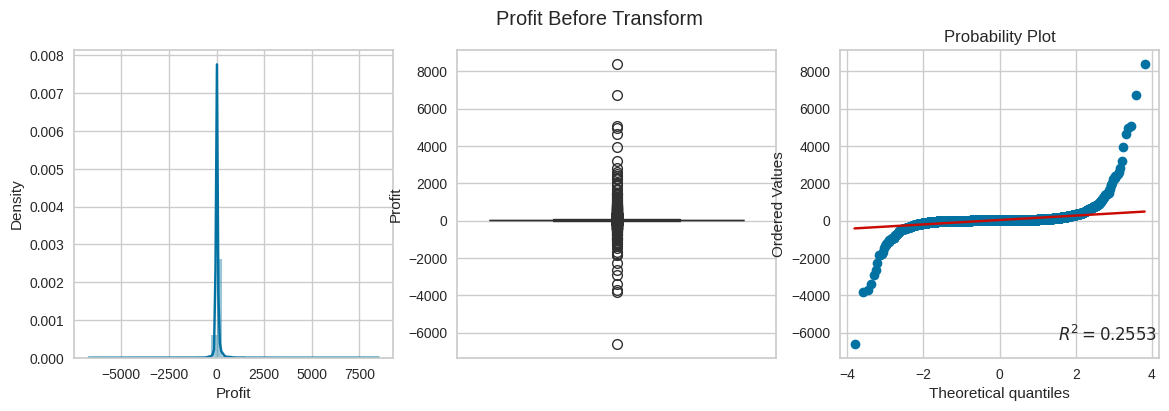

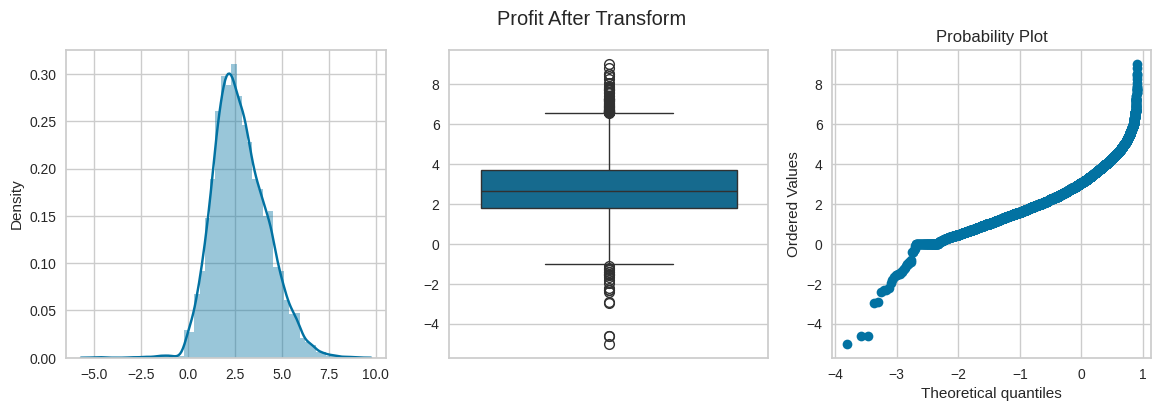

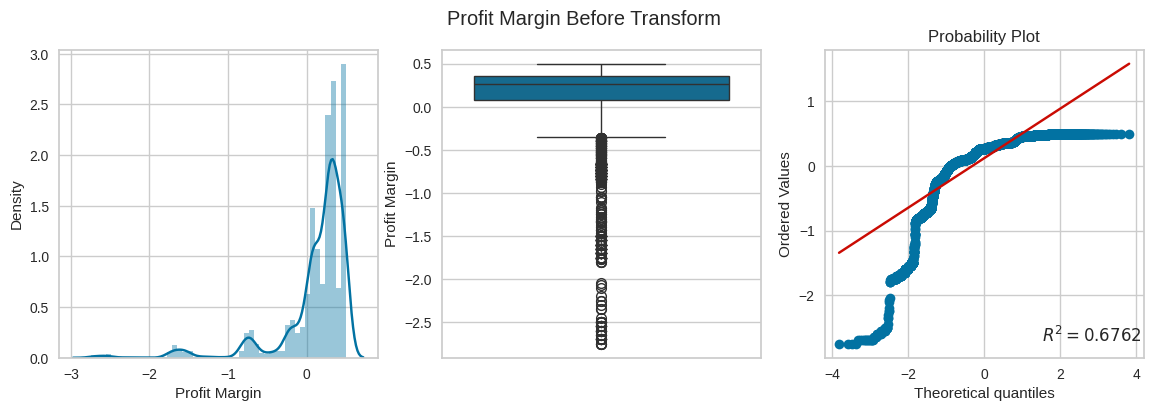

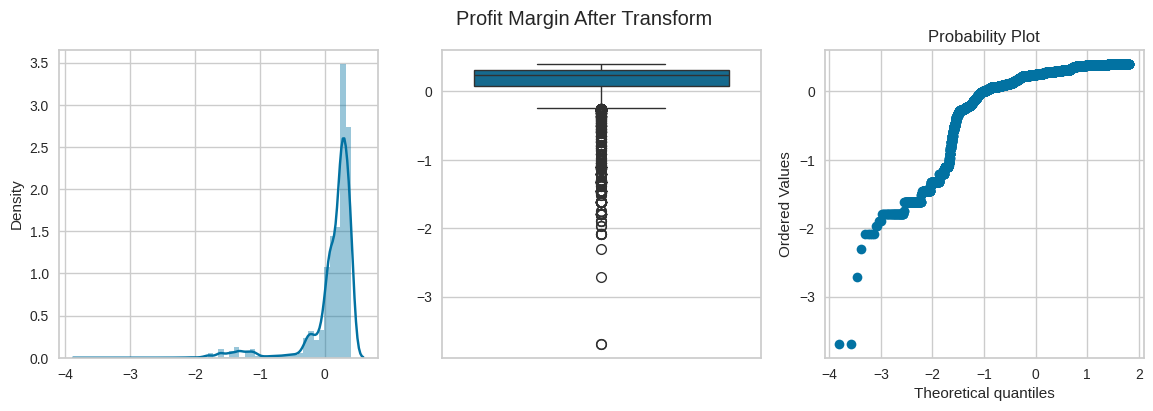

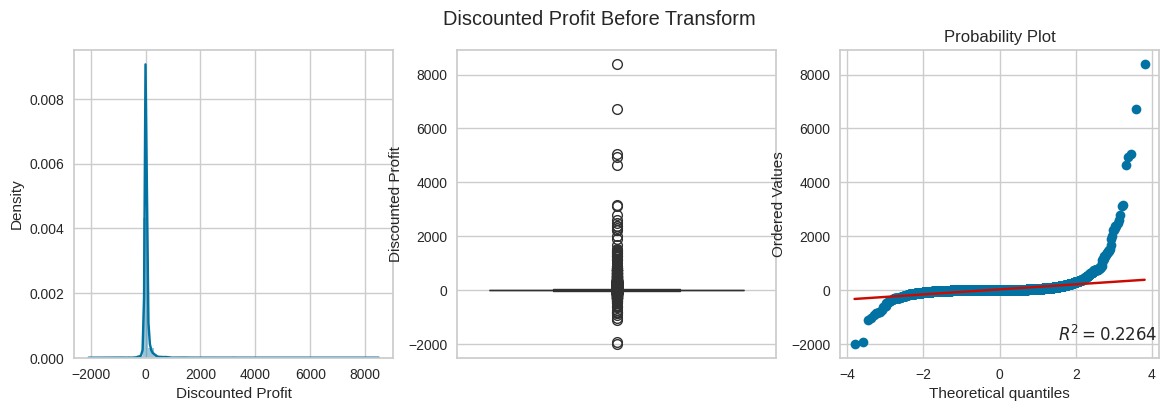

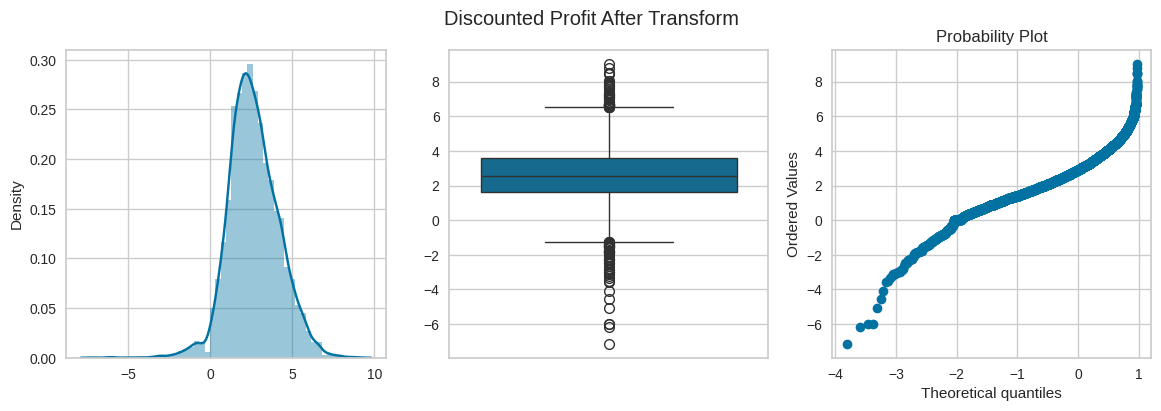

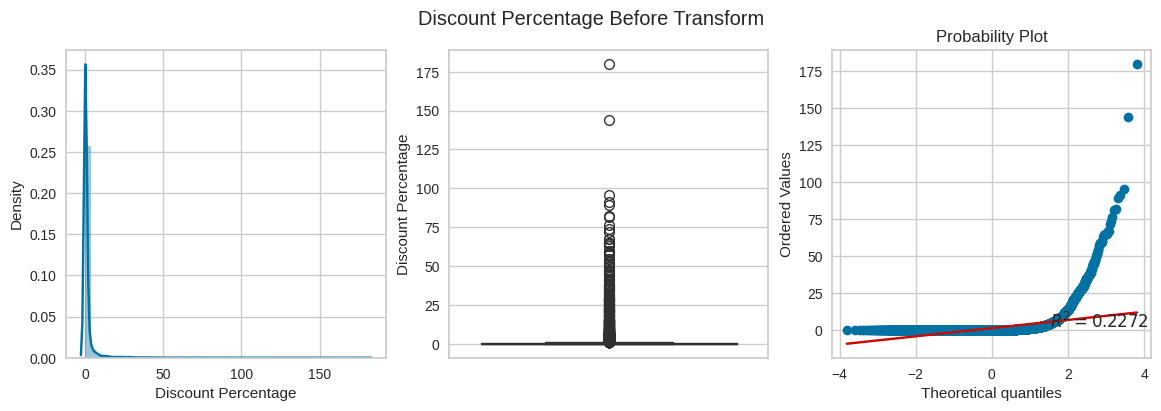

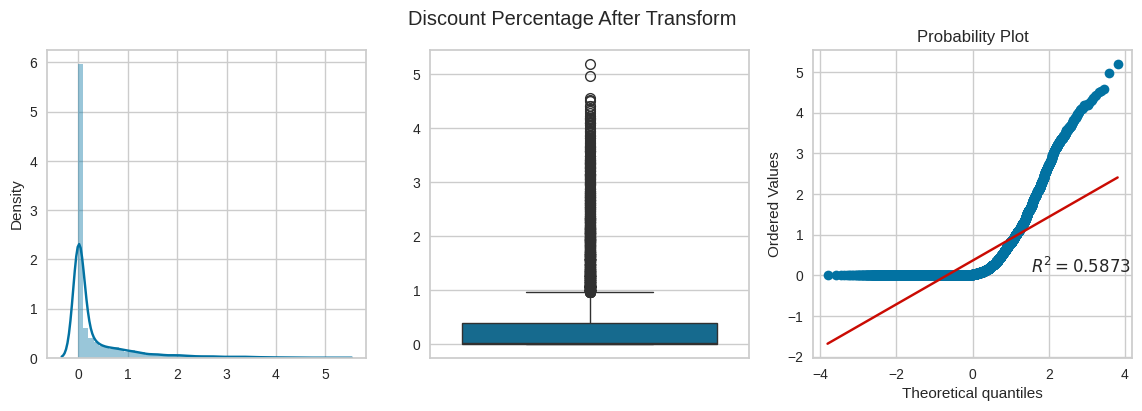

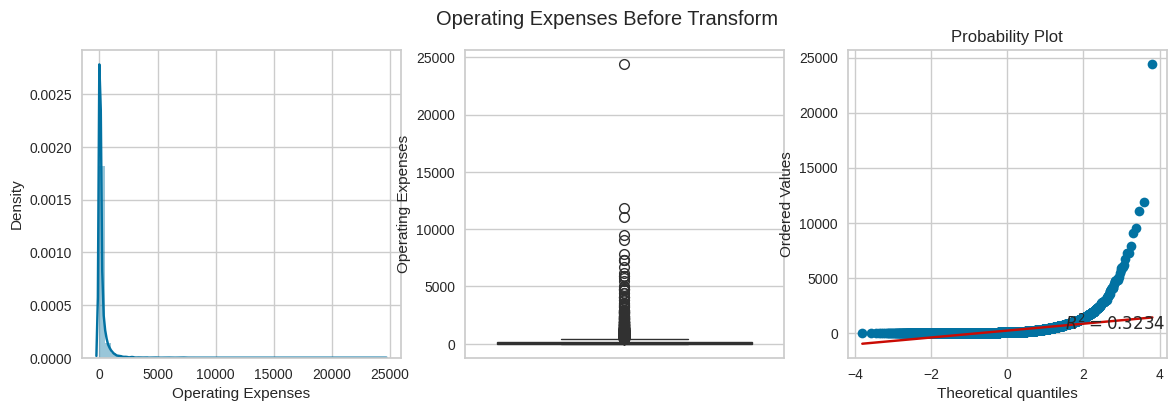

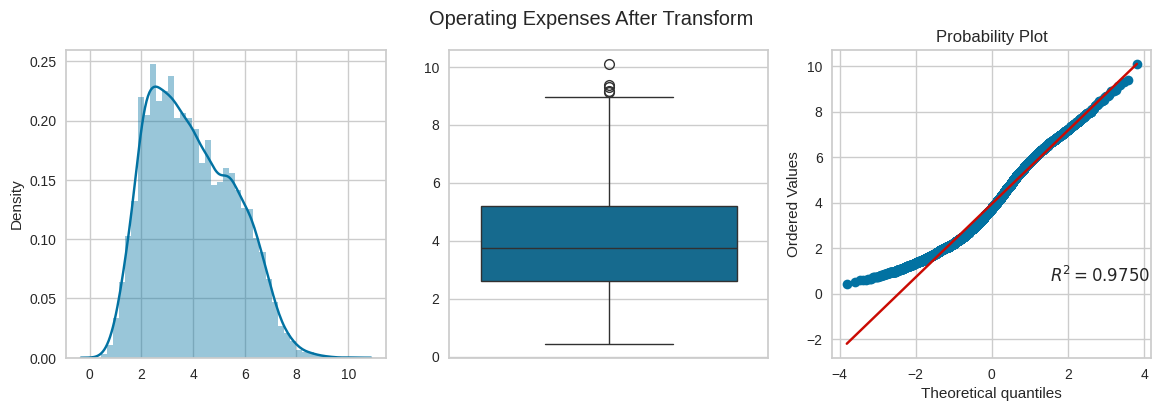

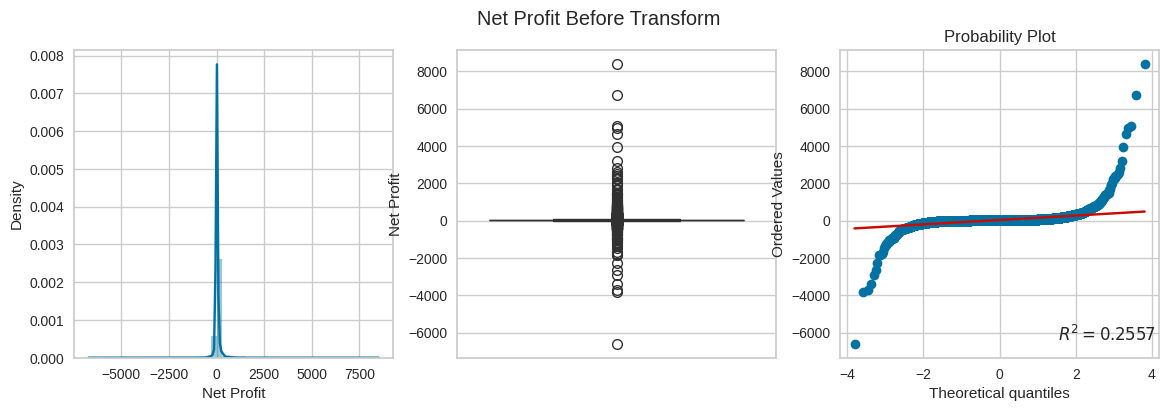

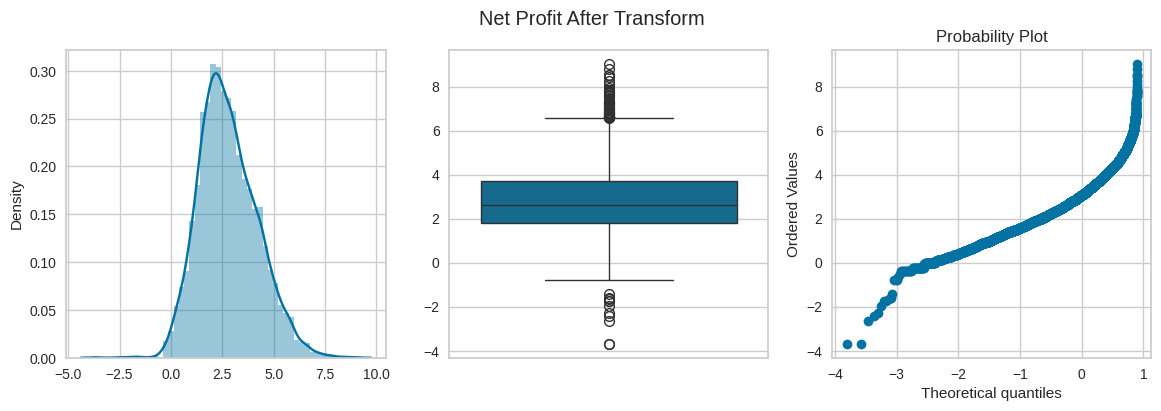

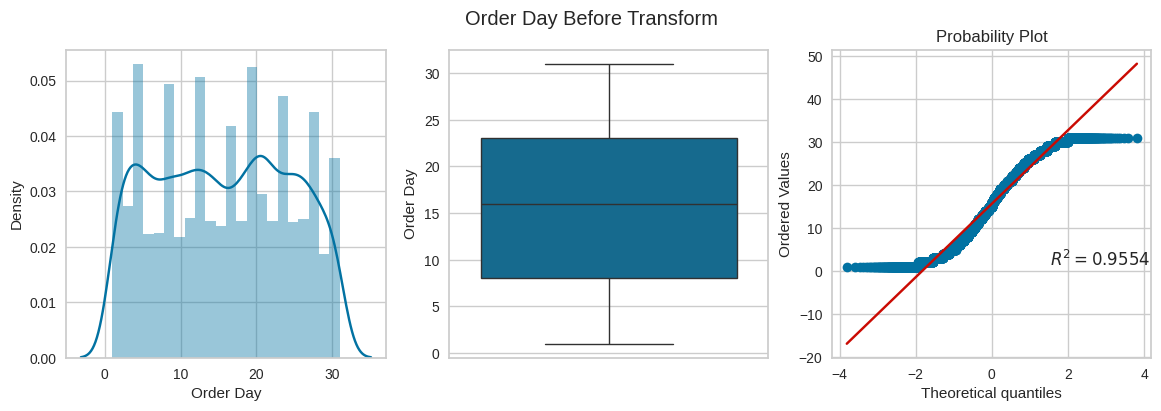

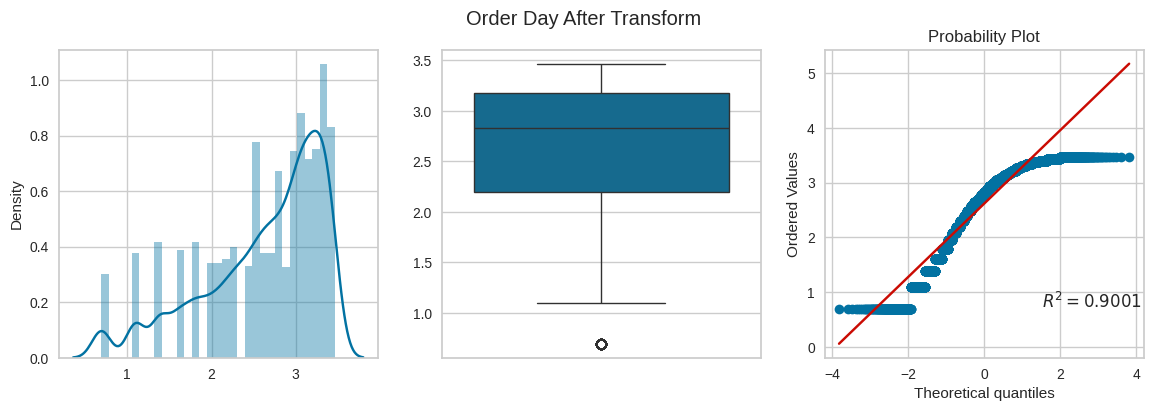

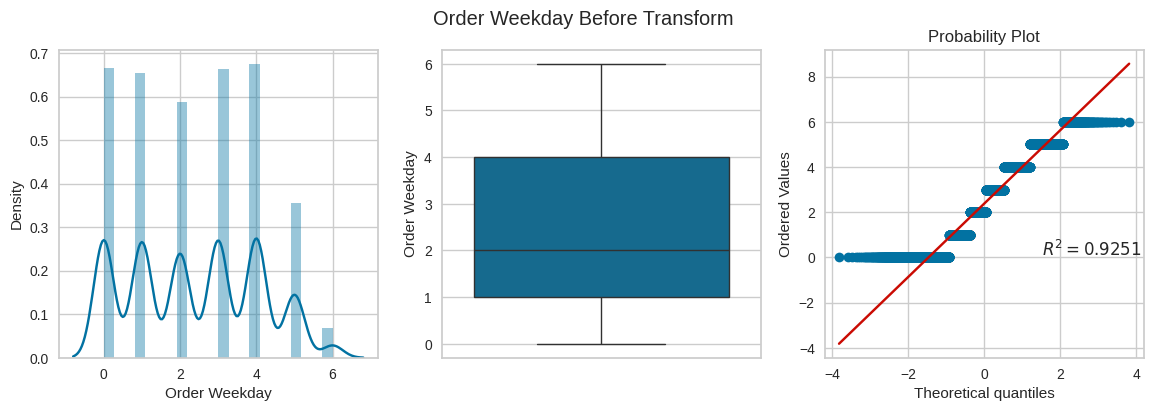

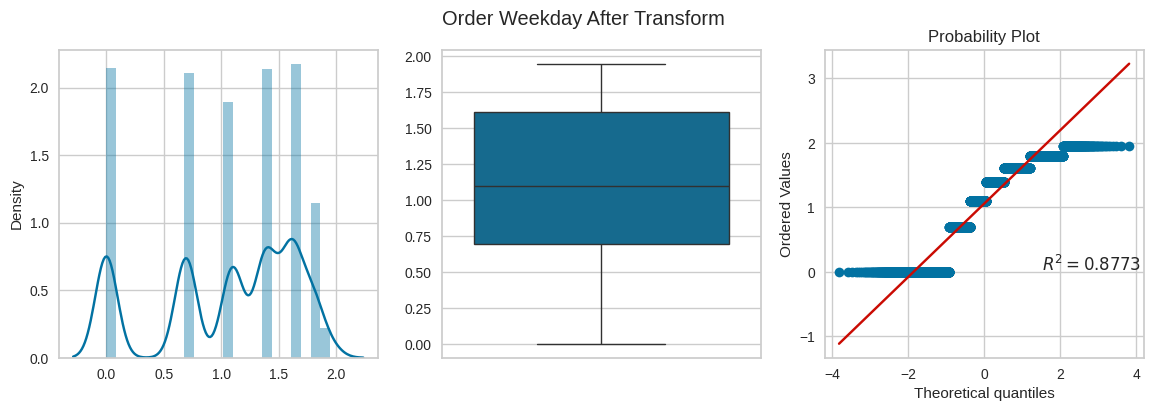

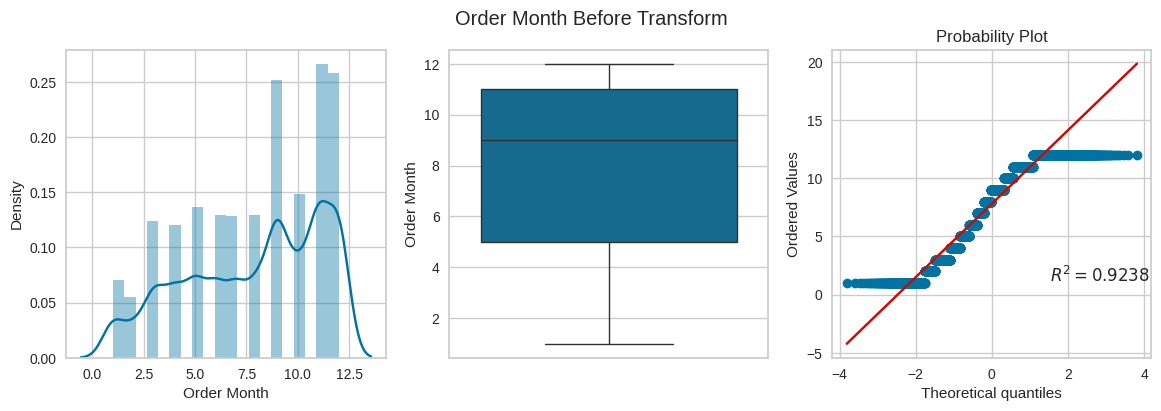

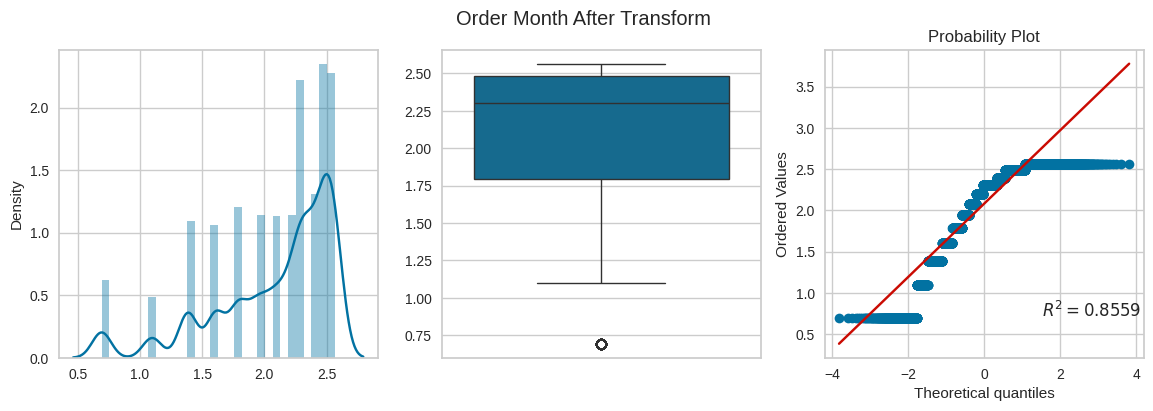

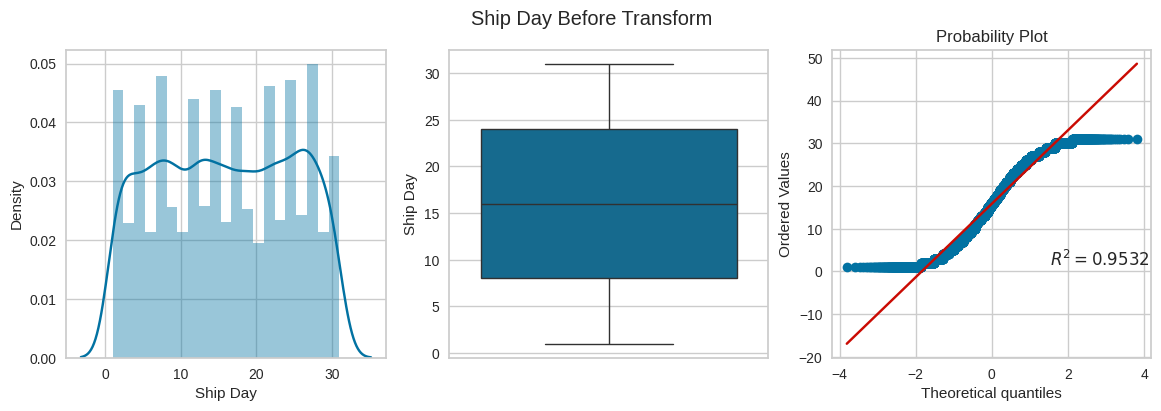

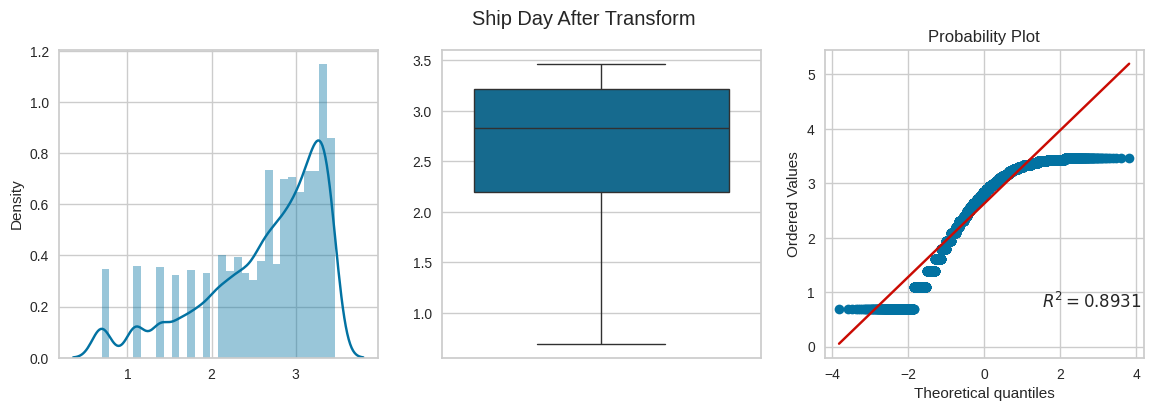

In [ ]:
def apply_transform(data,col,transformer):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(data[col])
    plt.subplot(132)
    sns.boxplot(data[col])
    plt.subplot(133)
    probplot(data[col],rvalue=True,dist='norm',plot=plt)
    plt.suptitle(f"{col} Before Transform")
    plt.show()
    col_tf = transformer.fit_transform(data[[col]])
    col_tf = np.array(col_tf).reshape(col_tf.shape[0])
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(col_tf)
    plt.subplot(132)
    sns.boxplot(col_tf)
    plt.subplot(133)
    probplot(col_tf,rvalue=True,dist='norm',plot=plt)
    plt.suptitle(f"{col} After Transform")
    plt.show()
    gc.collect();
for col in skewed_cols:
    apply_transform(df,col,FunctionTransformer(np.log1p))

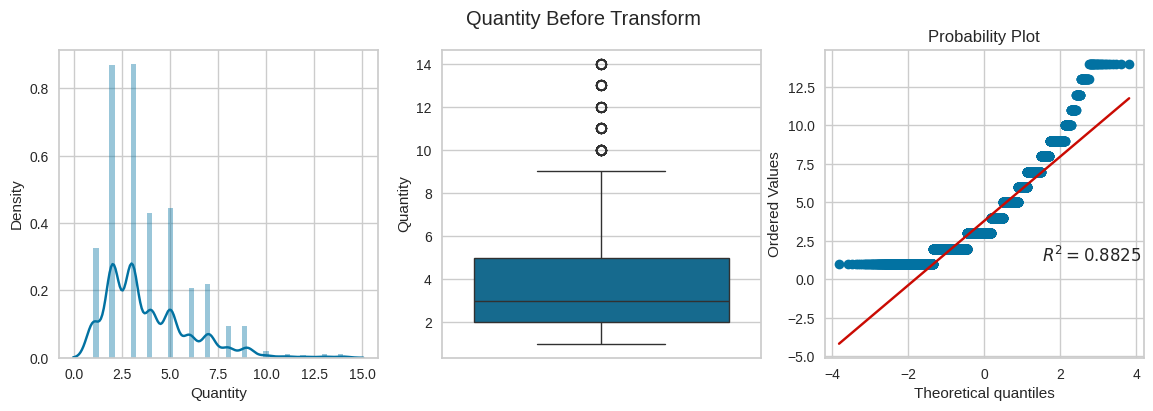

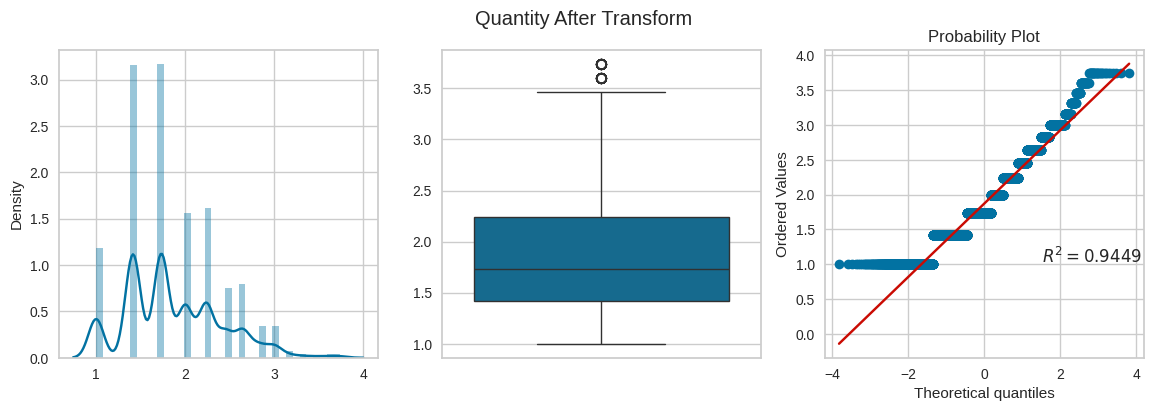

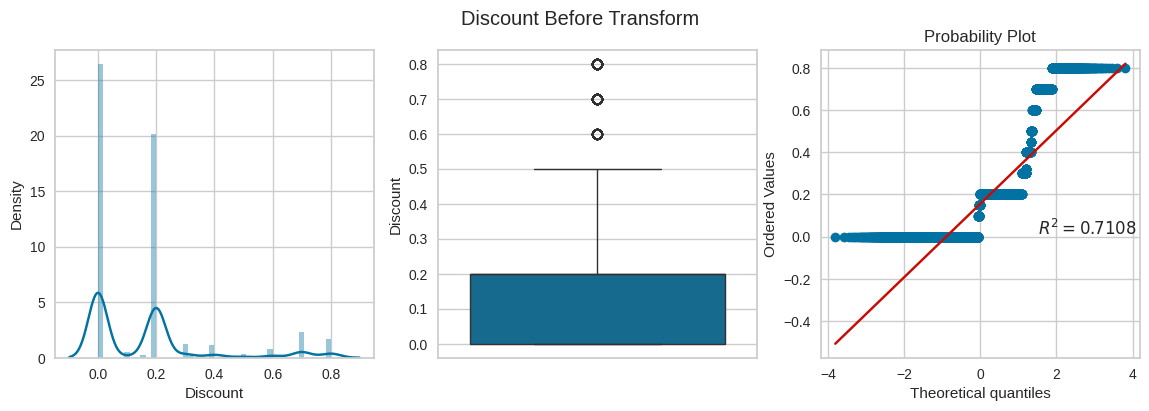

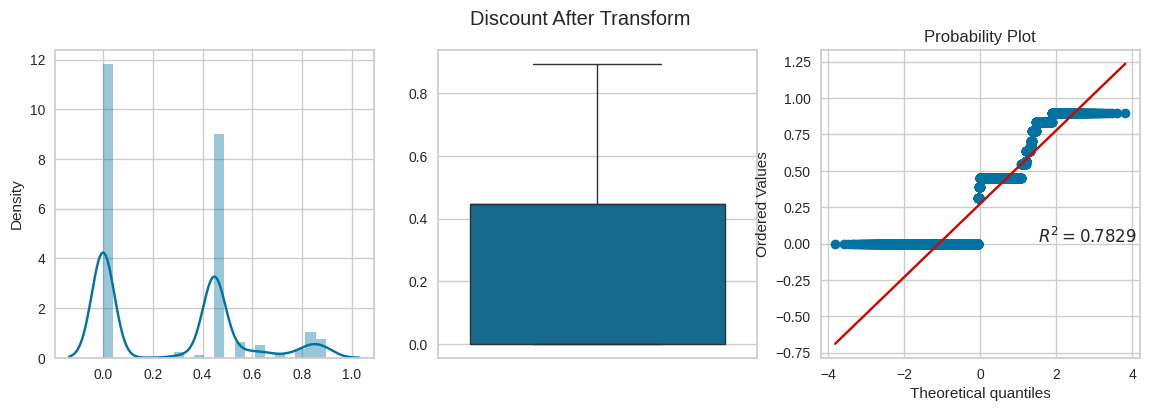

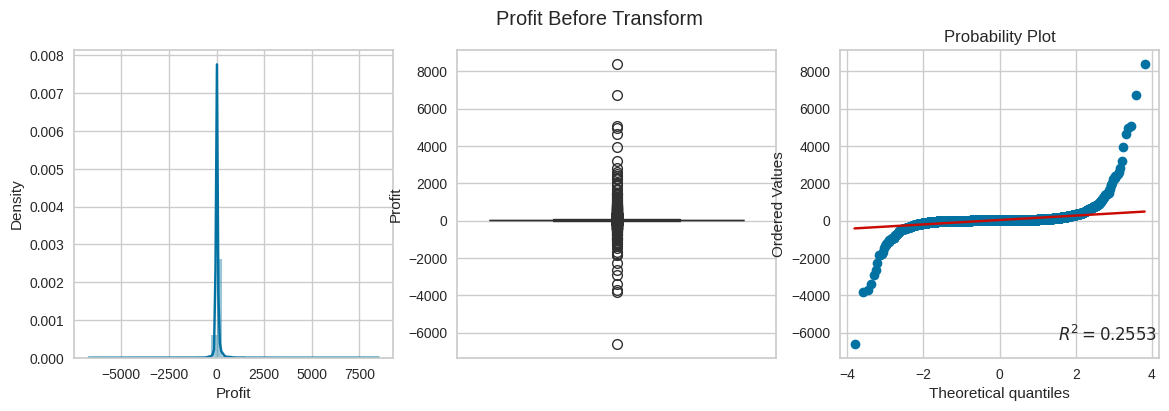

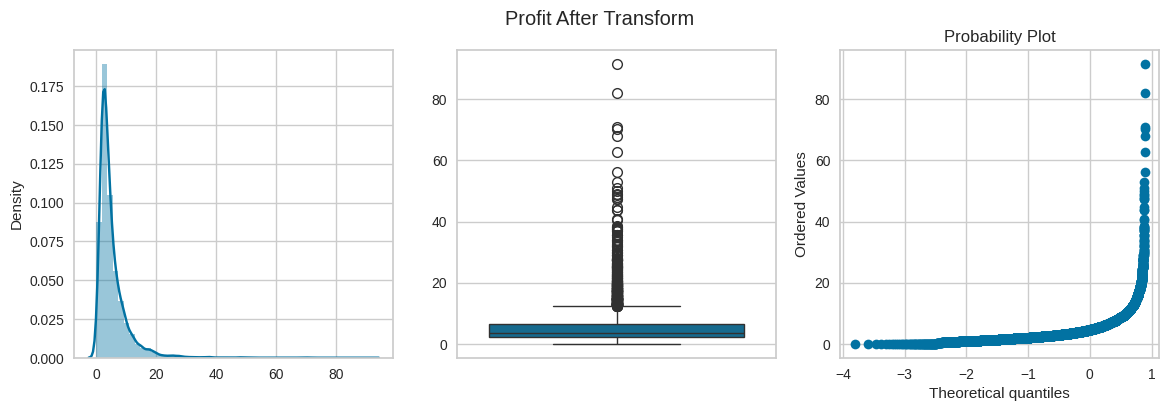

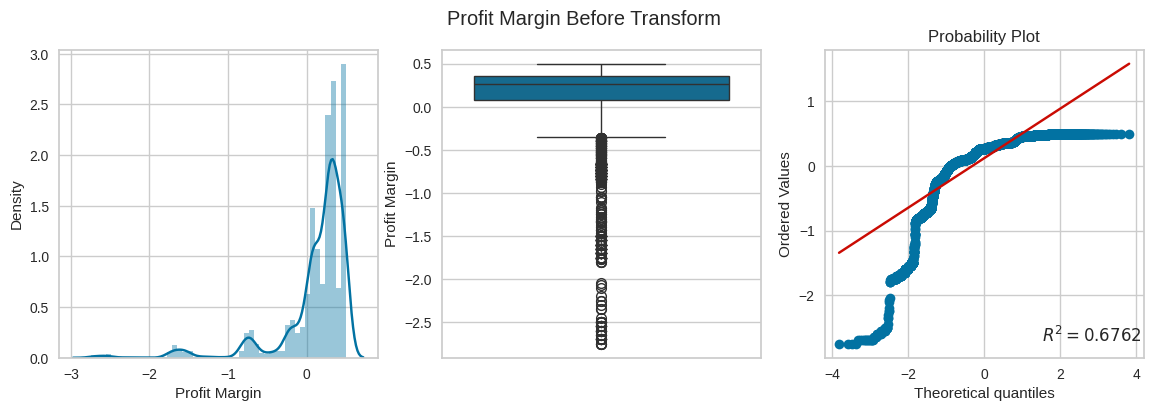

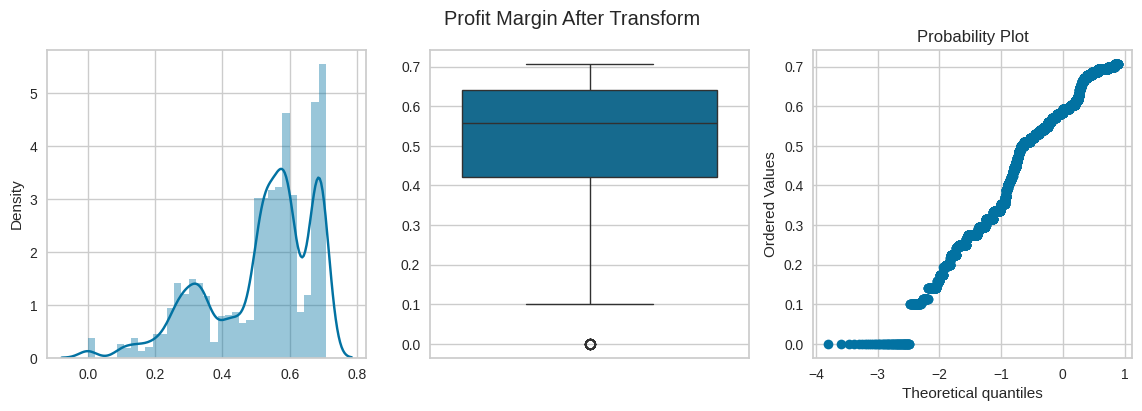

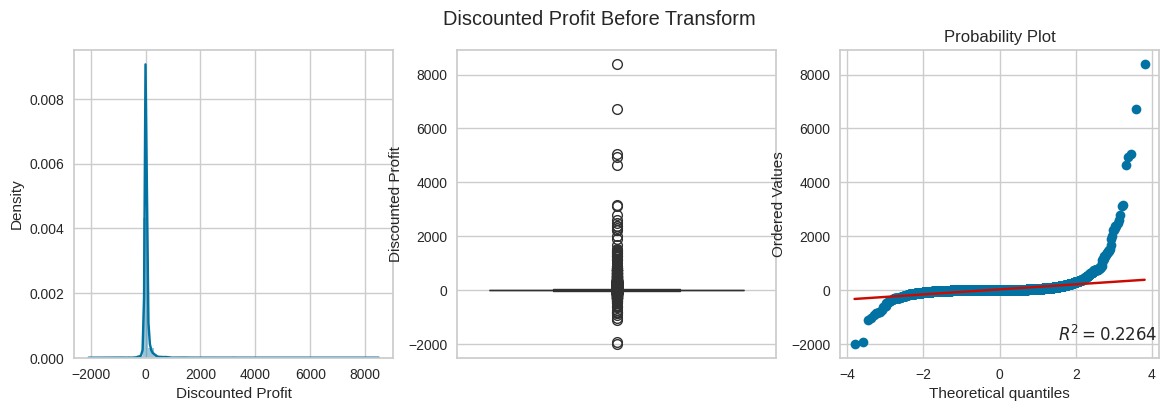

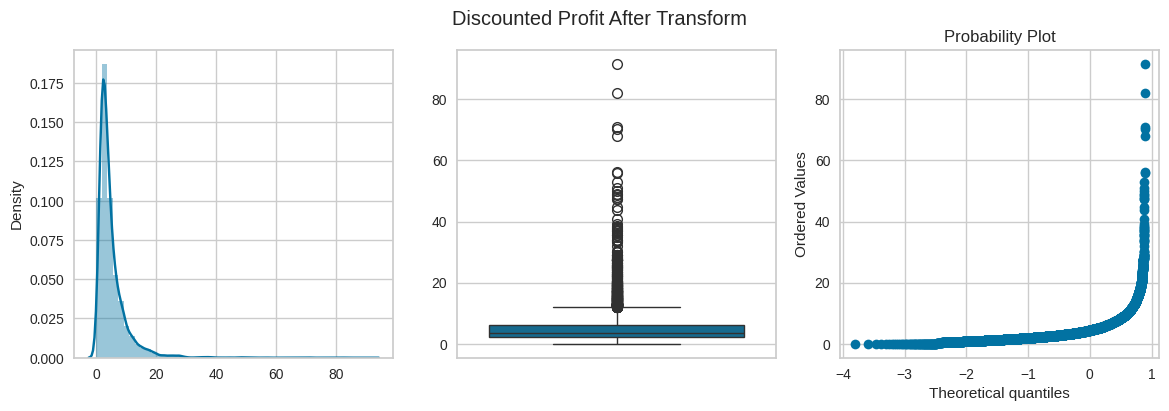

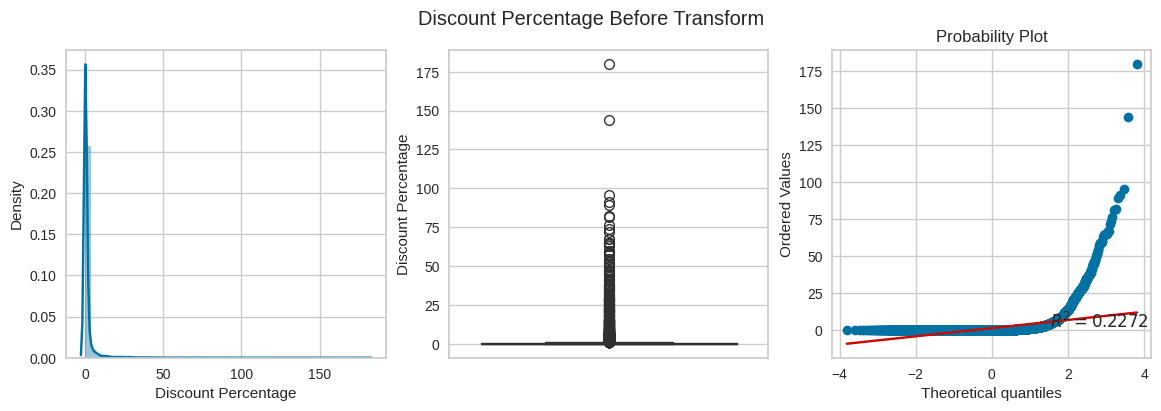

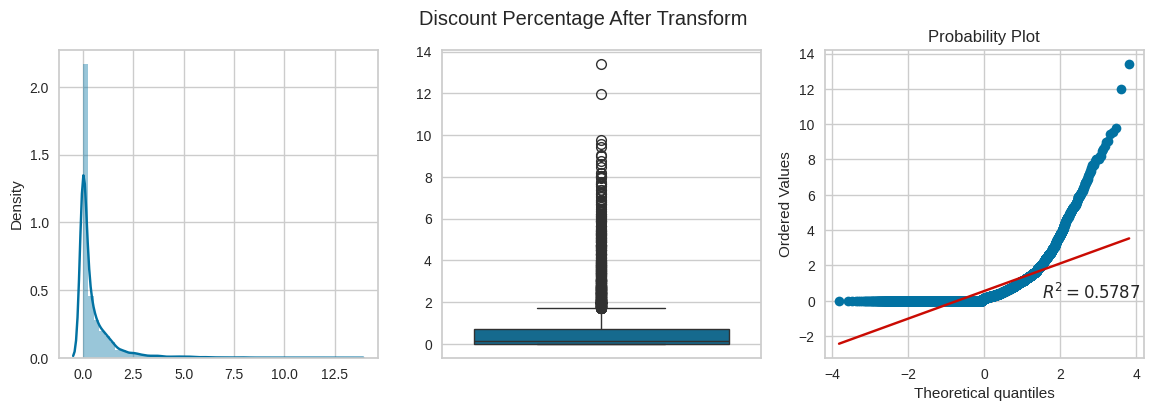

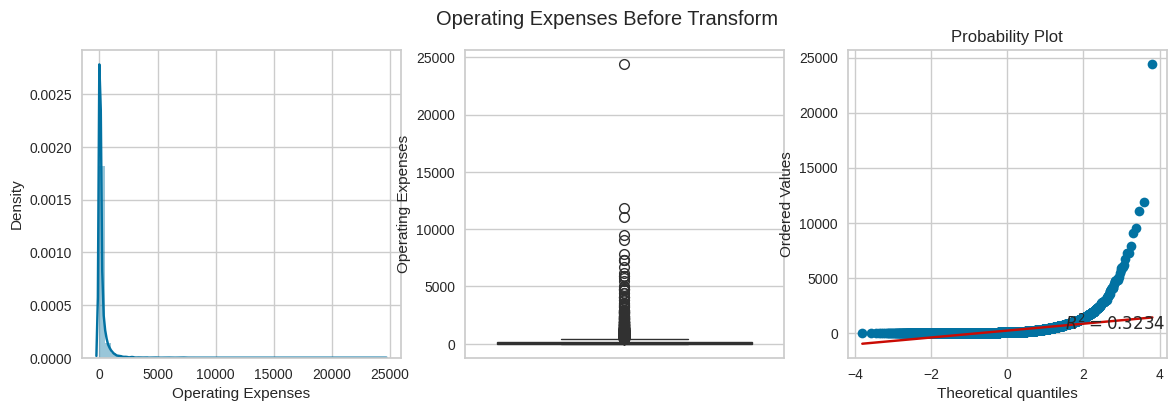

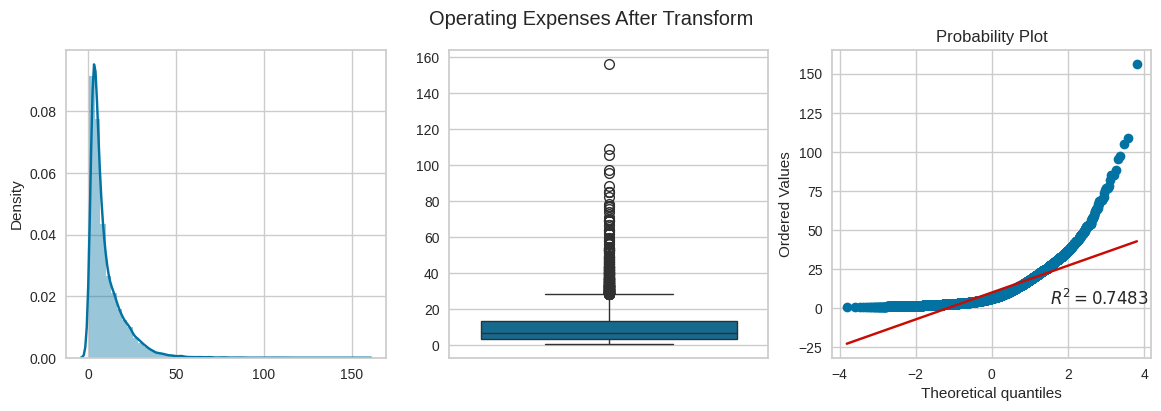

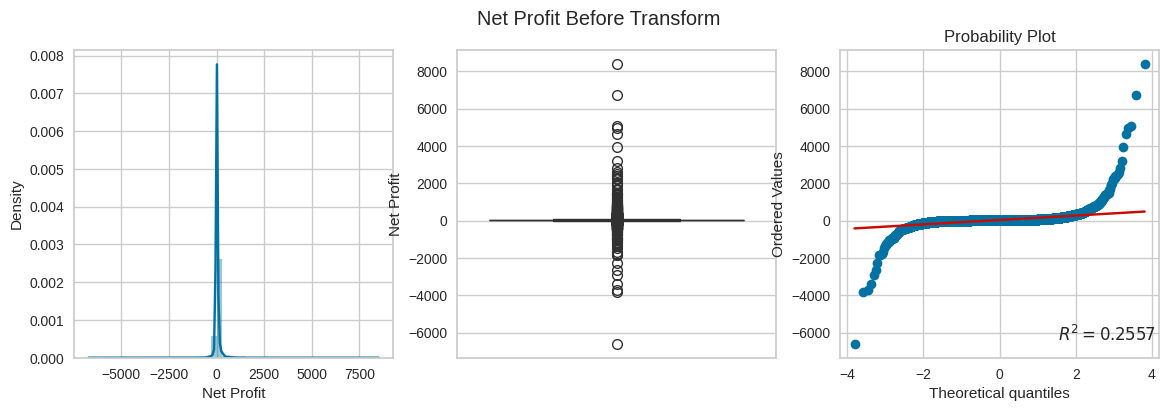

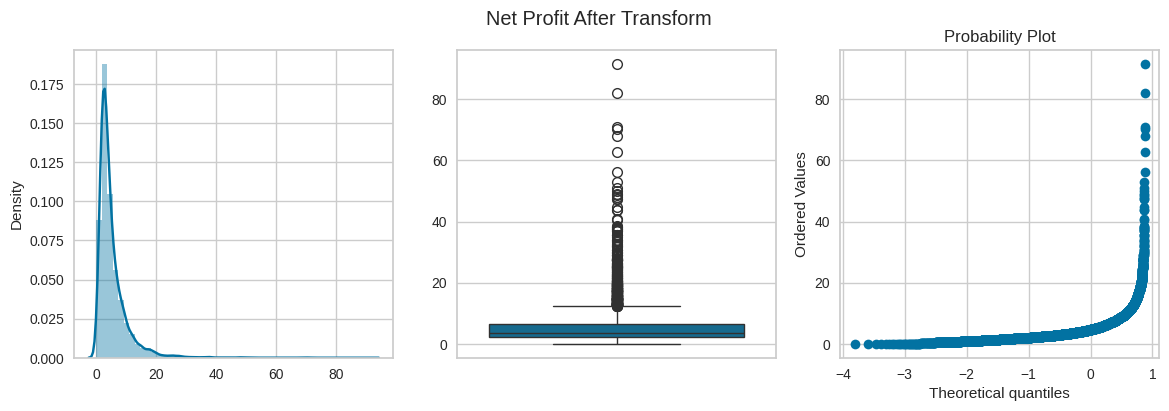

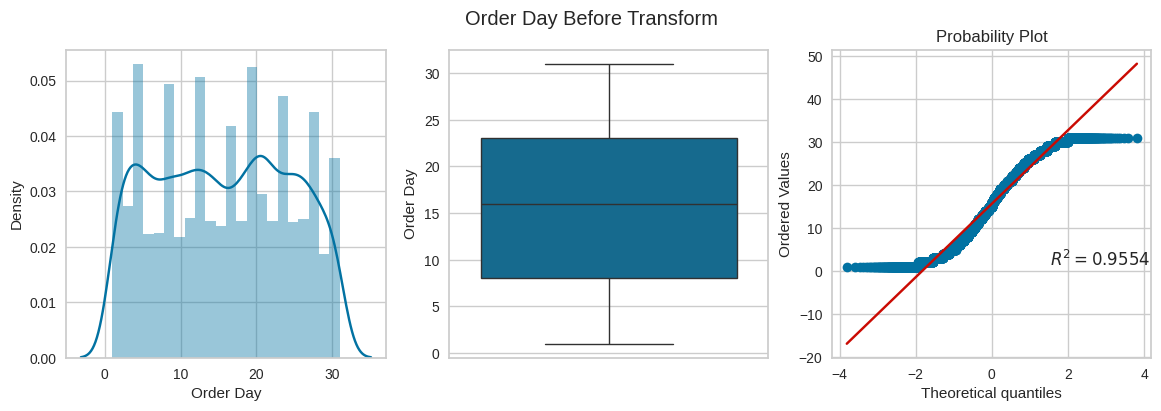

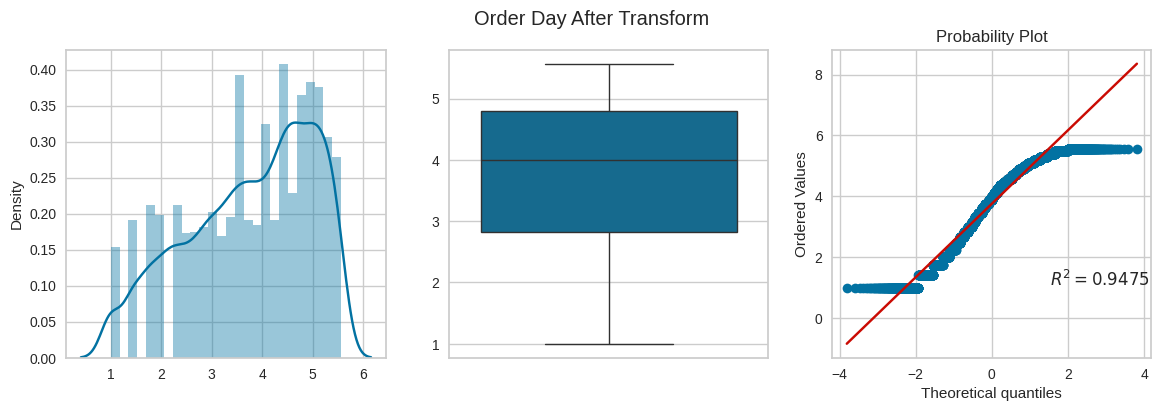

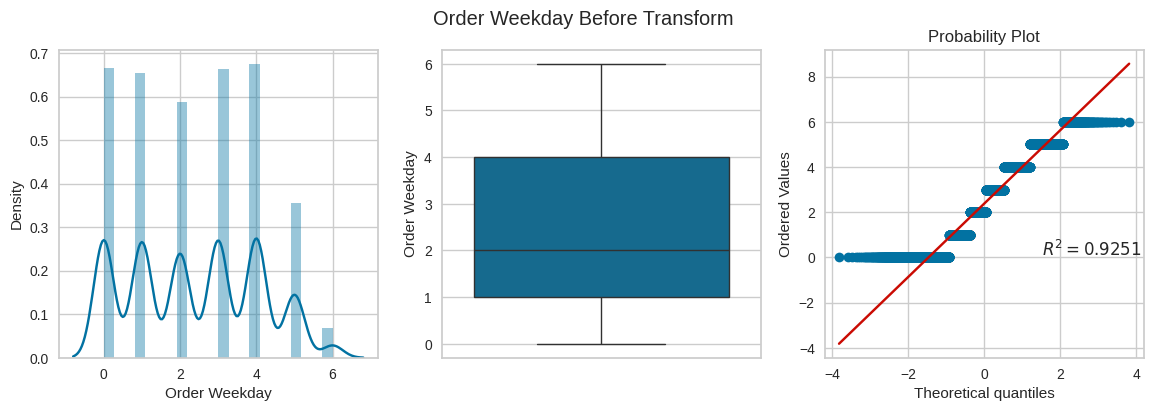

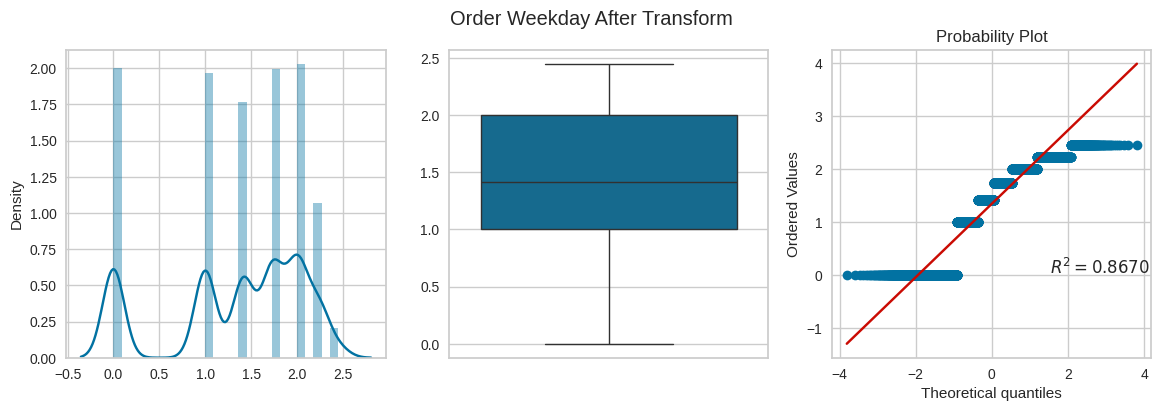

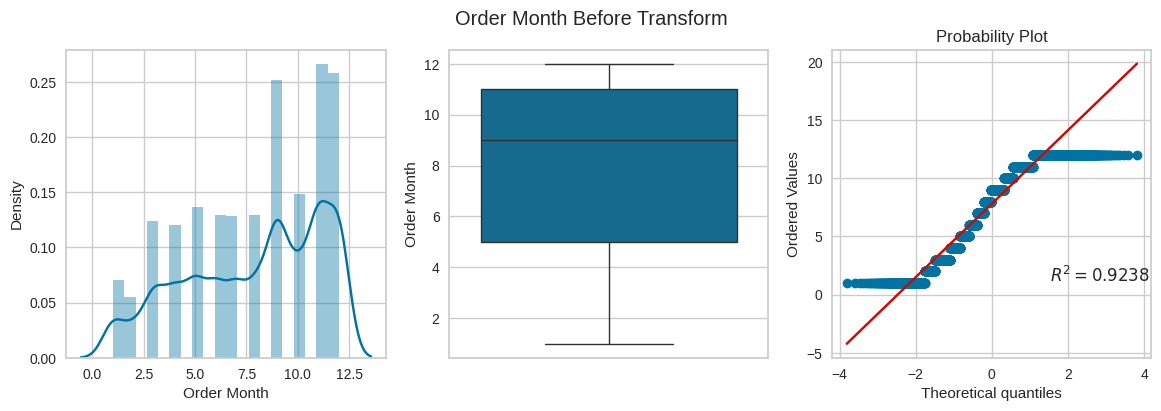

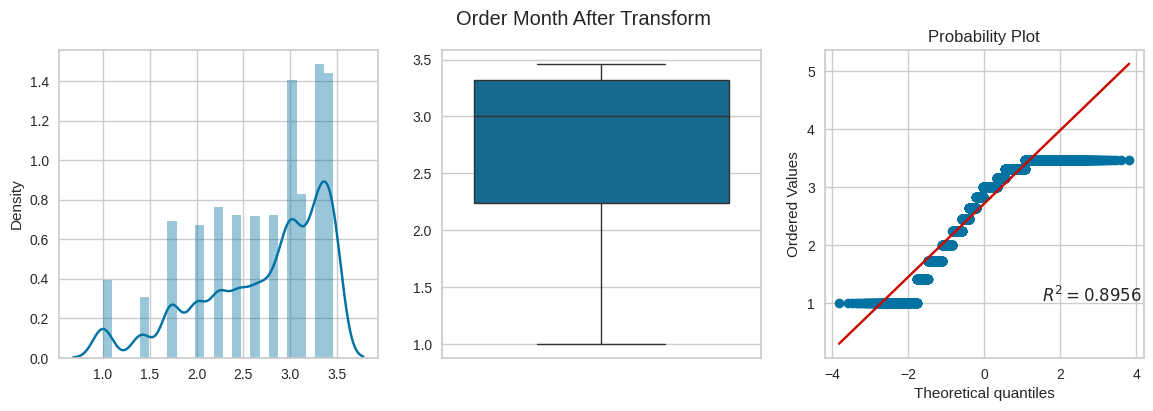

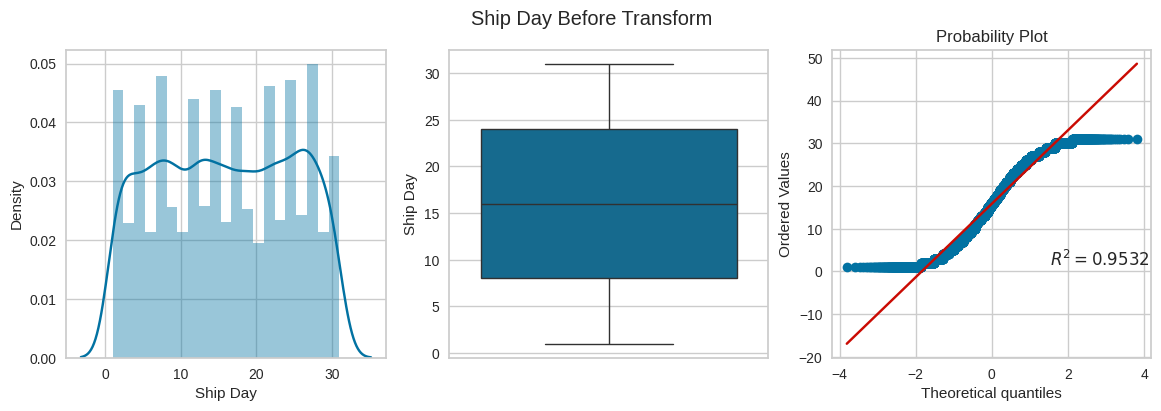

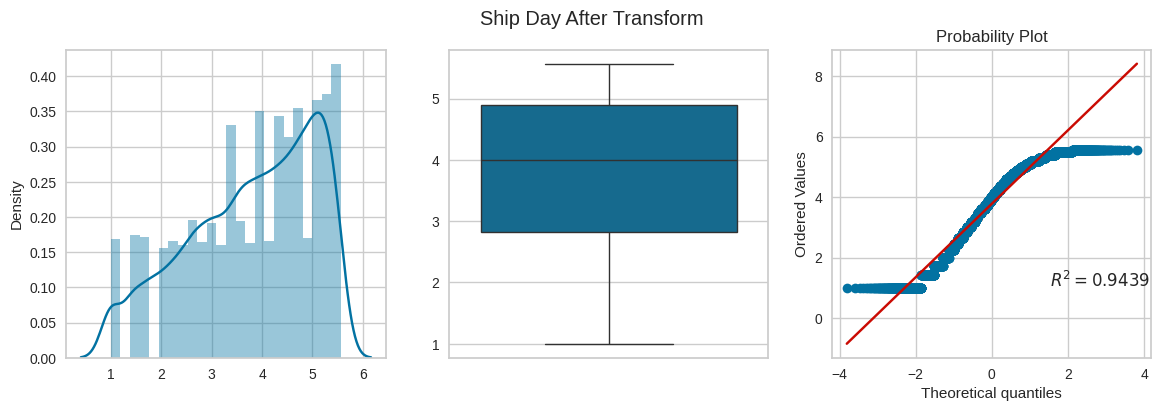

In [ ]:
for col in skewed_cols:
    apply_transform(df,col,FunctionTransformer(np.sqrt))

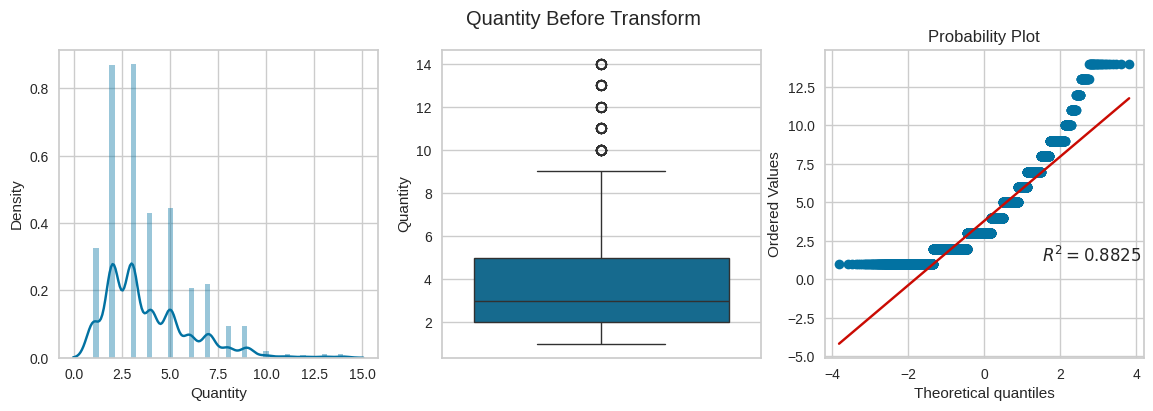

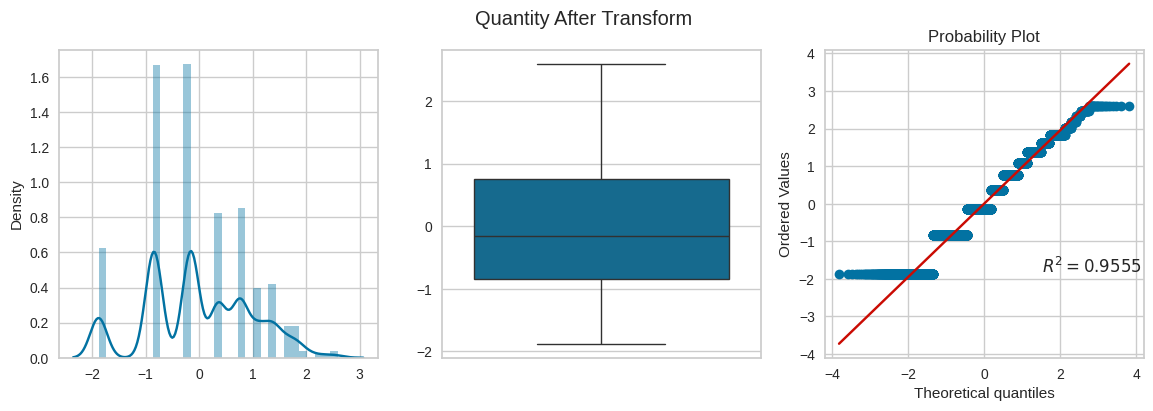

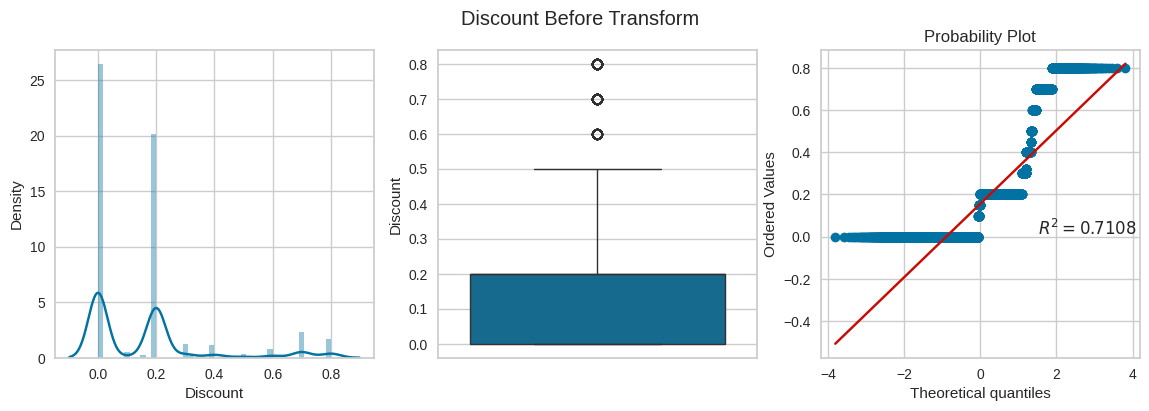

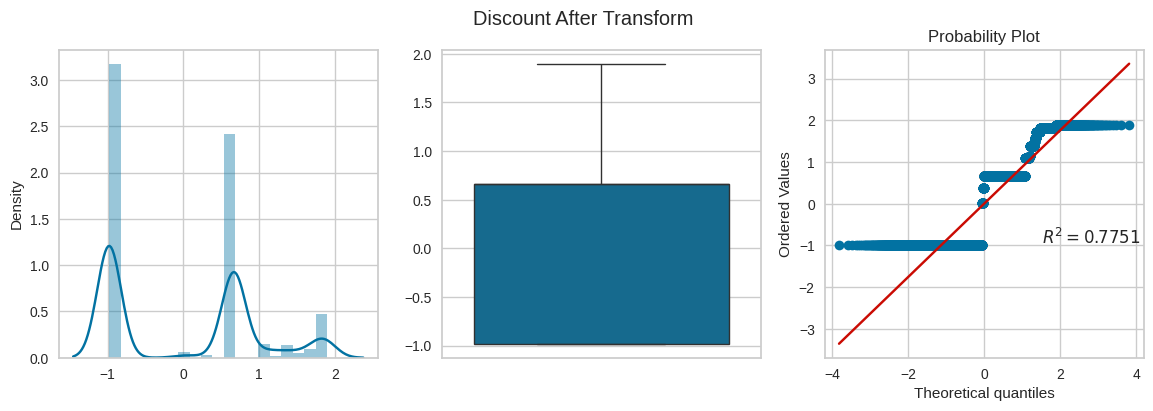

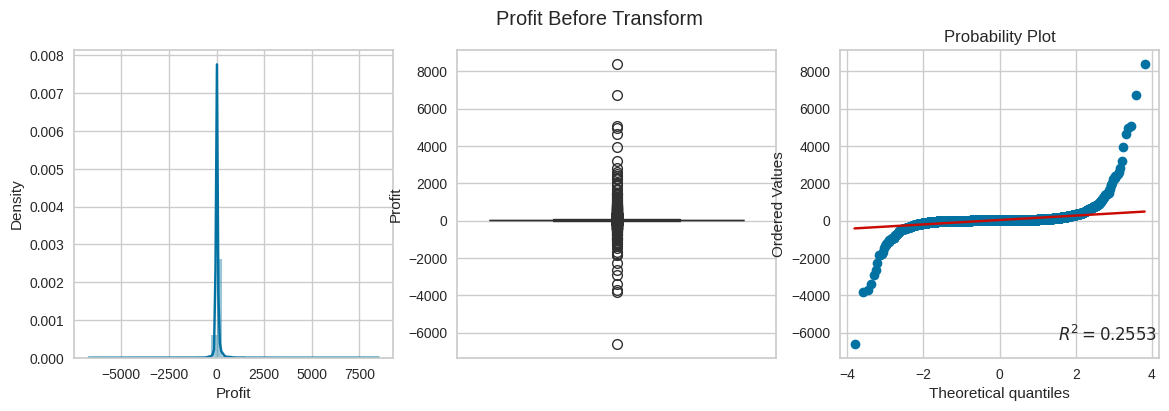

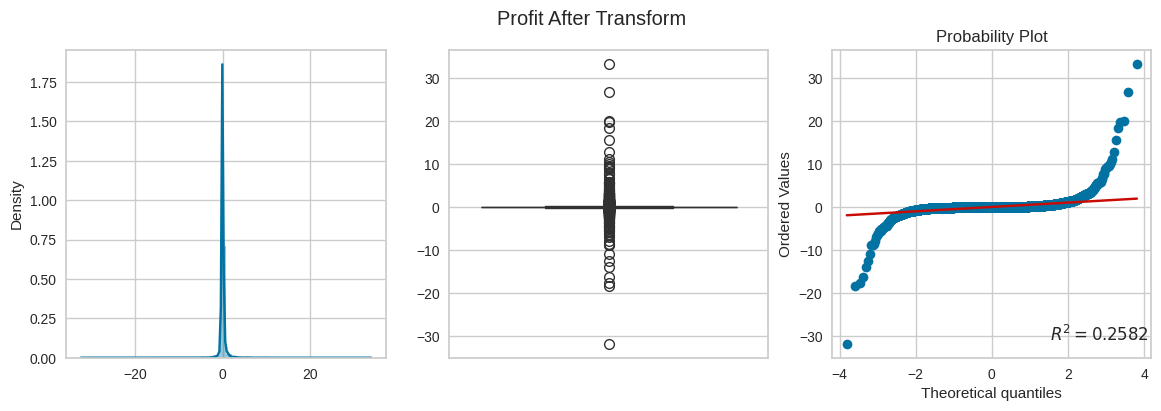

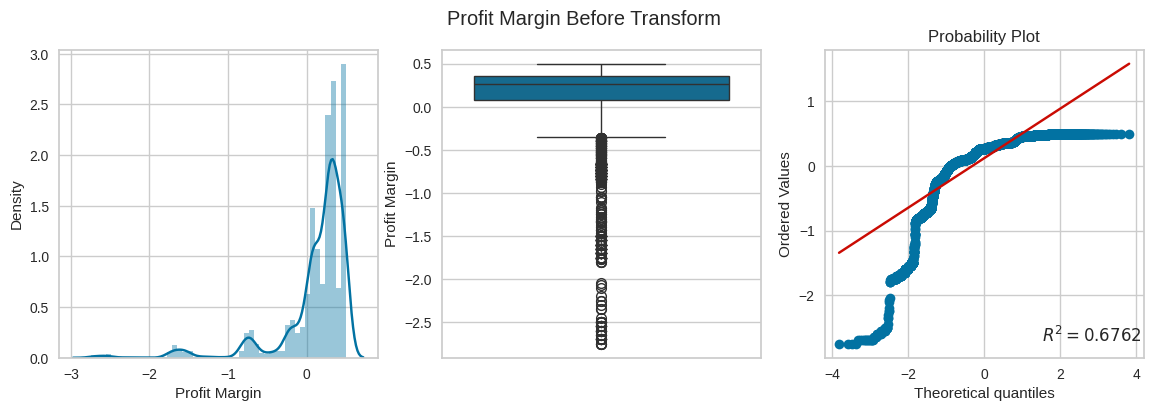

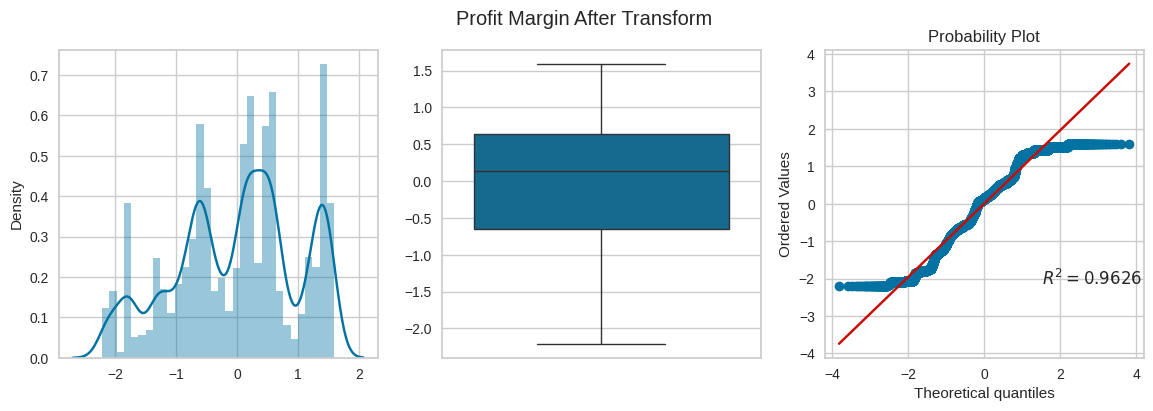

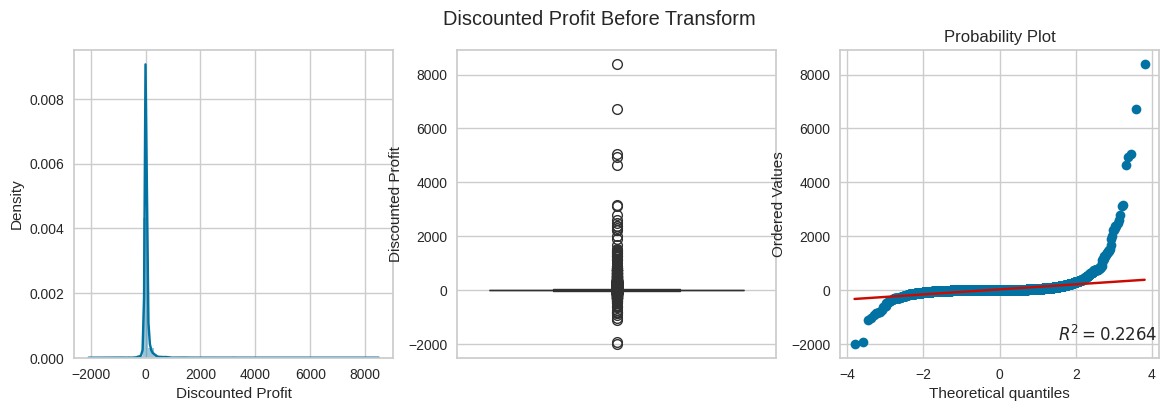

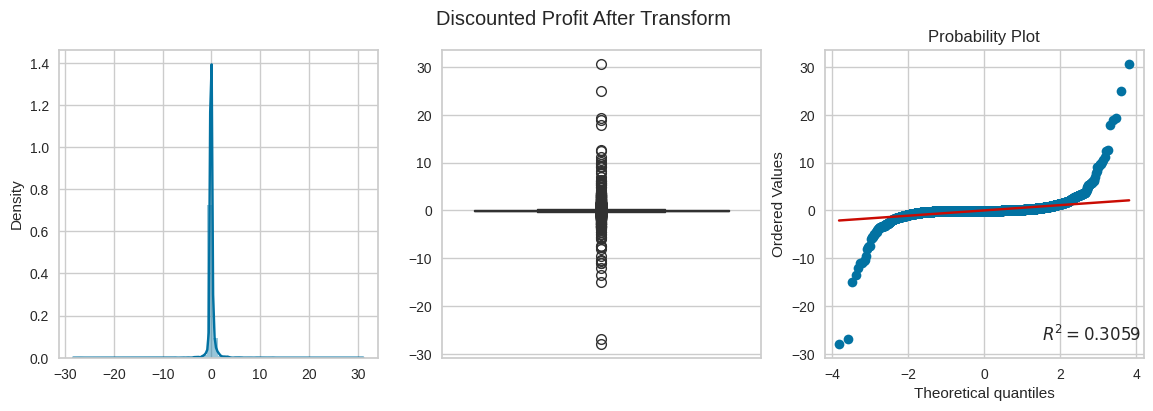

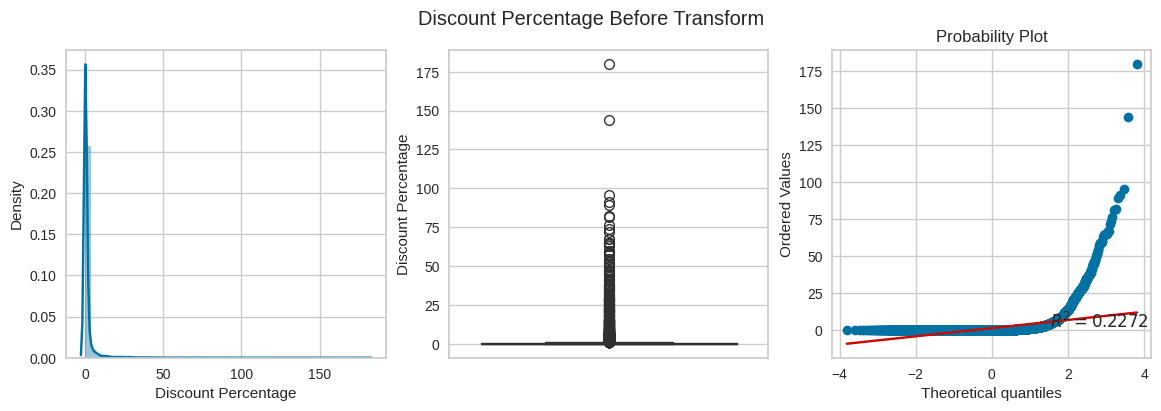

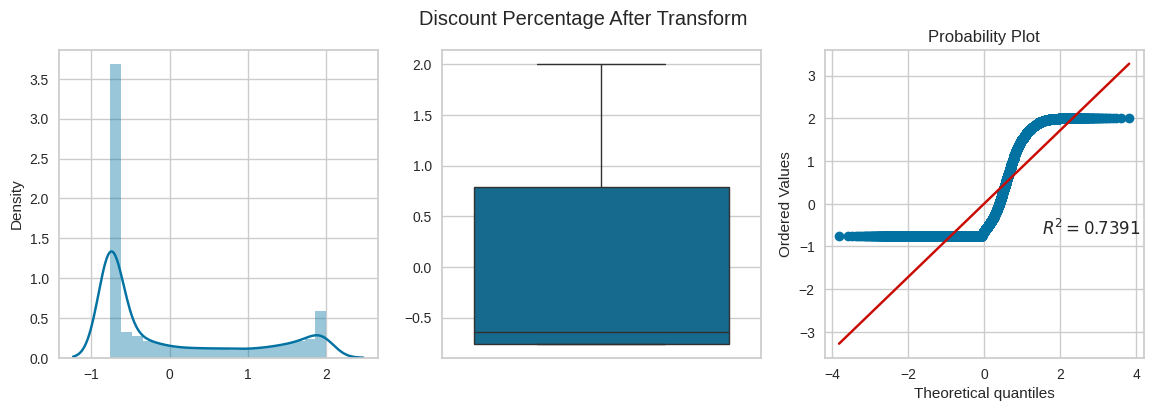

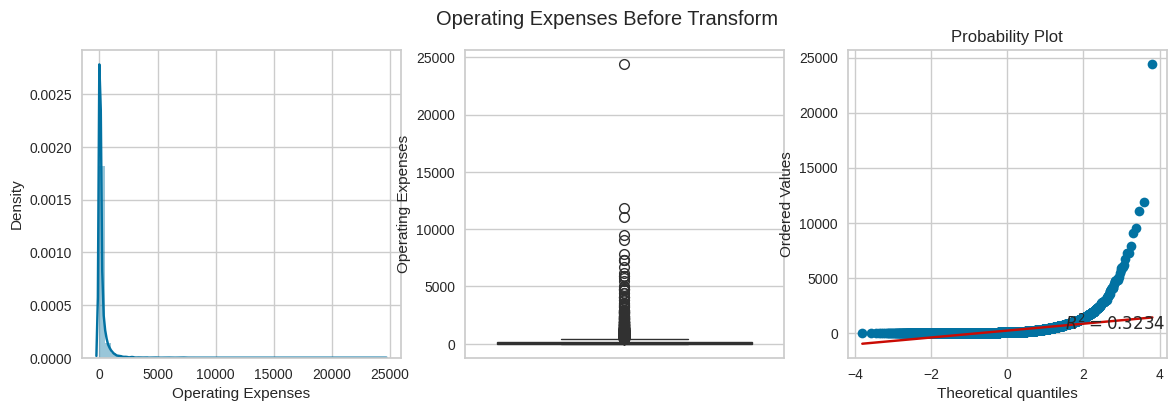

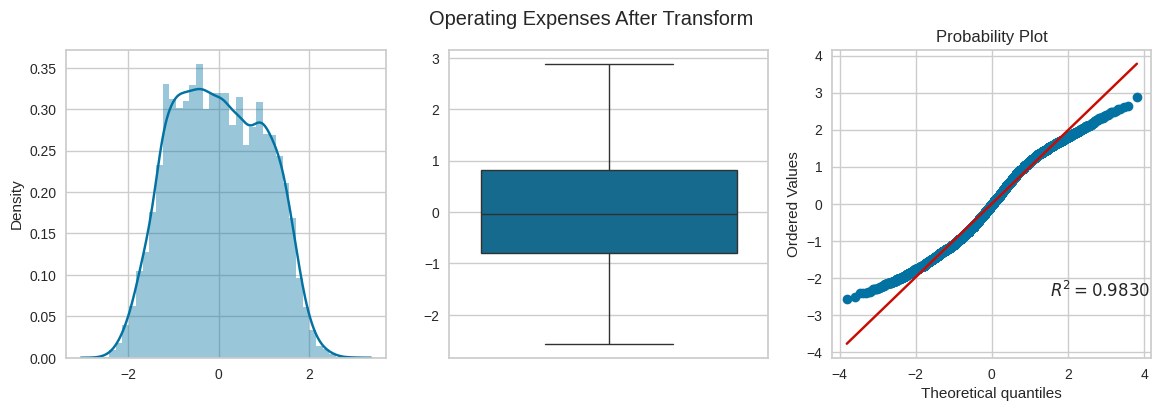

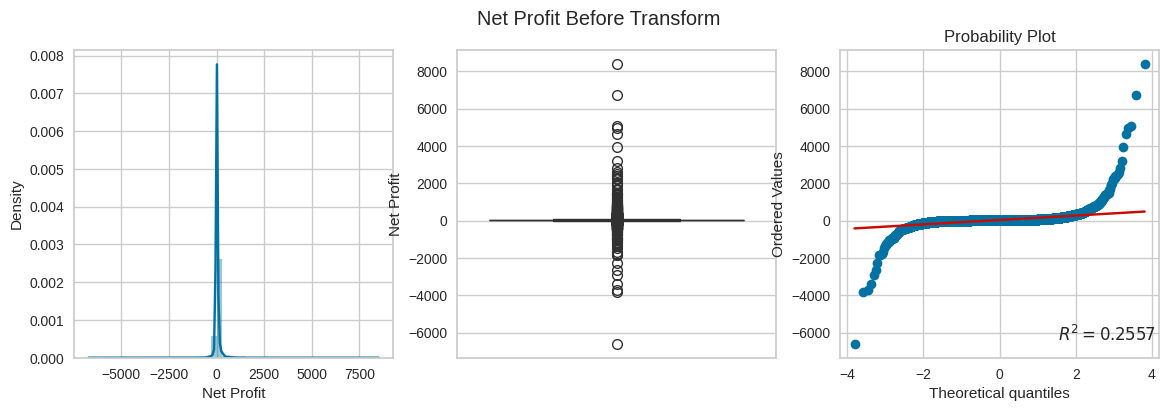

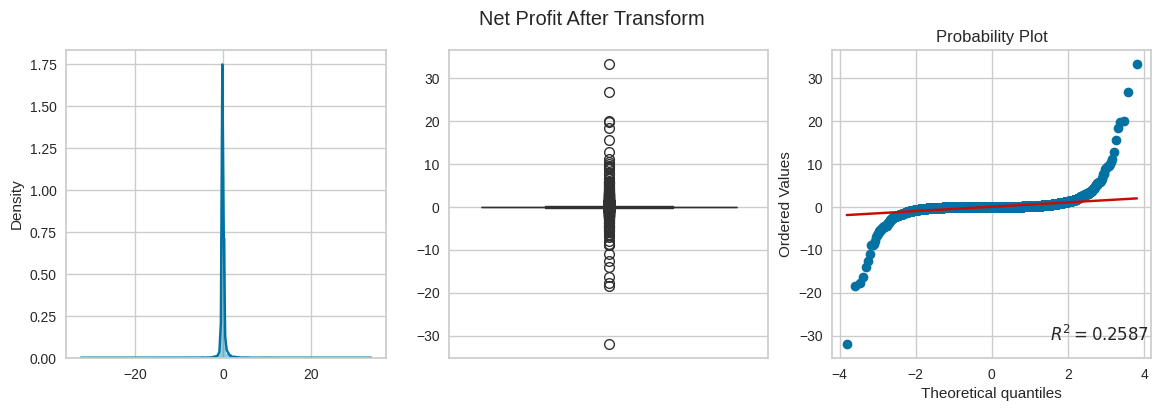

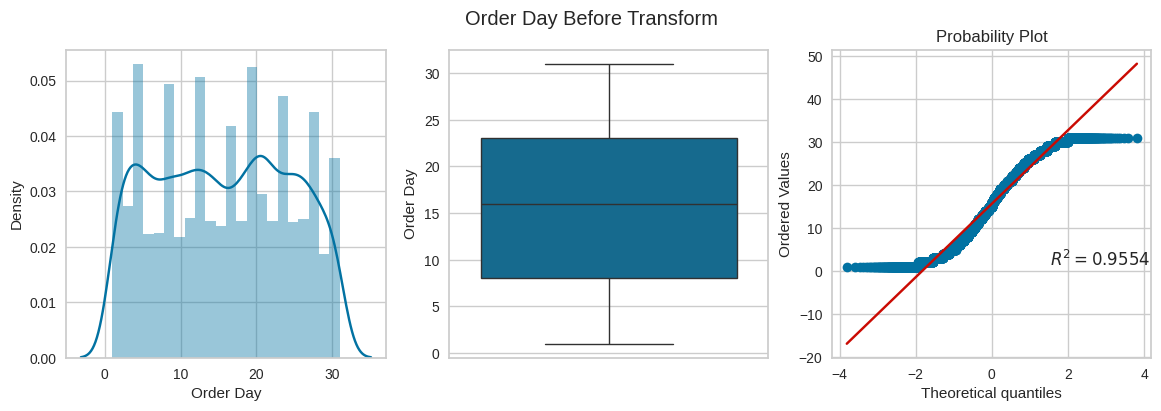

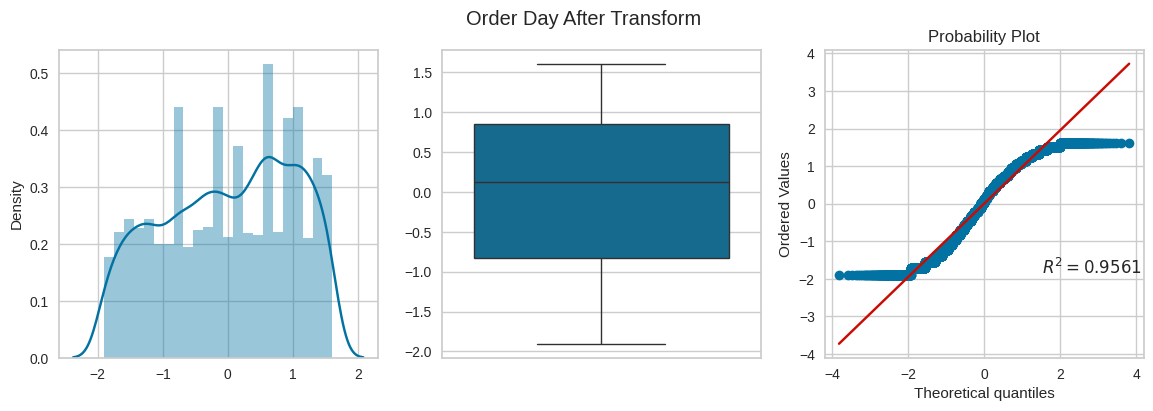

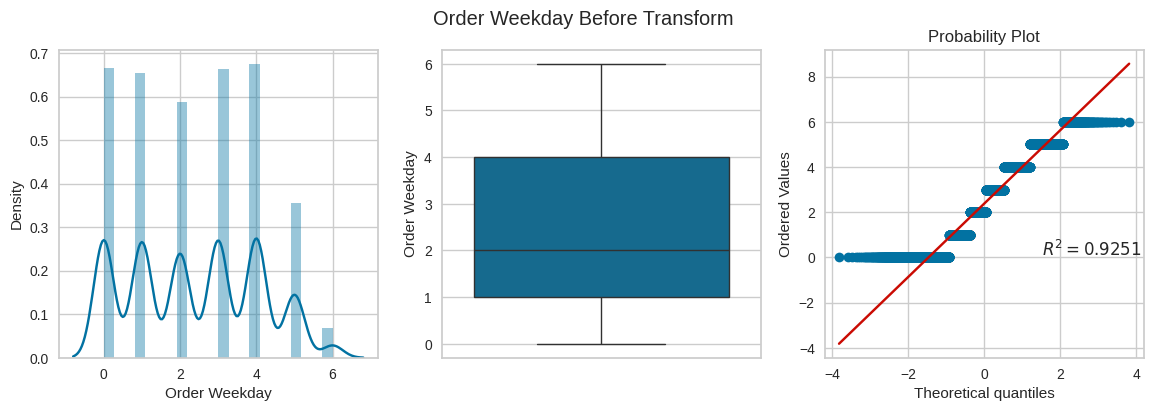

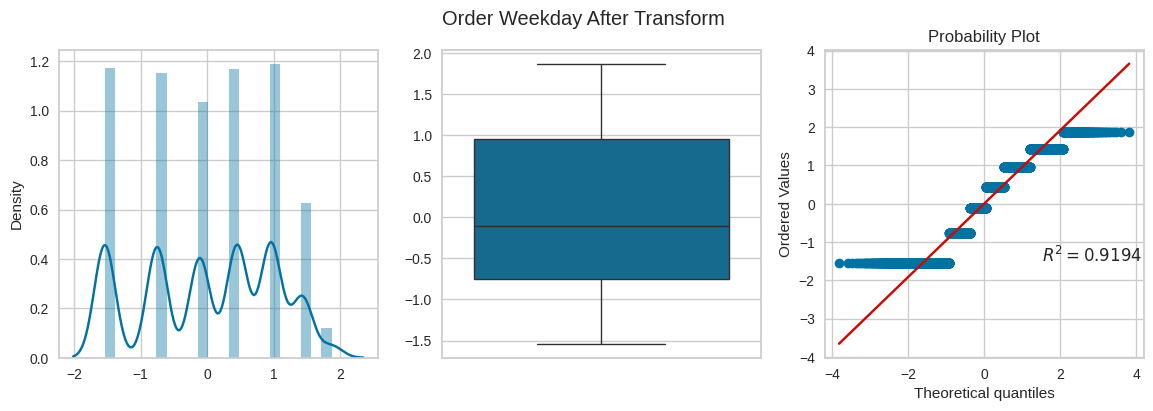

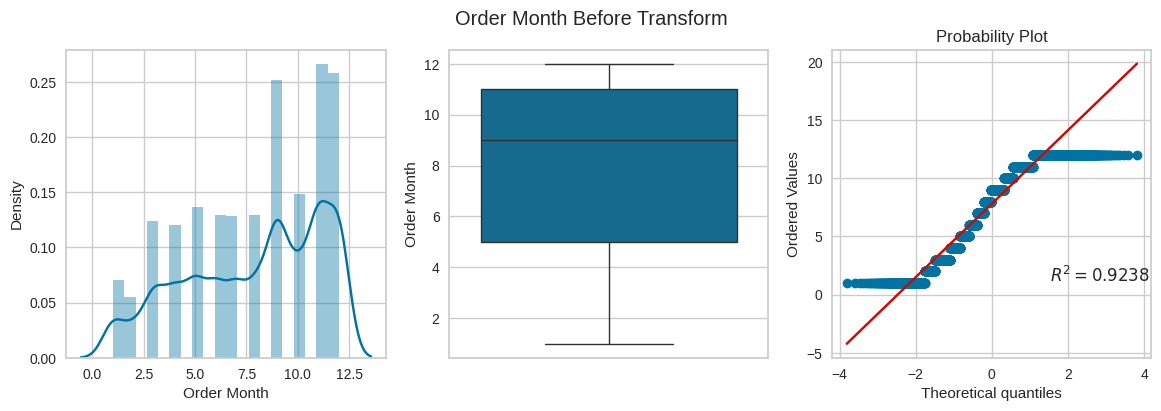

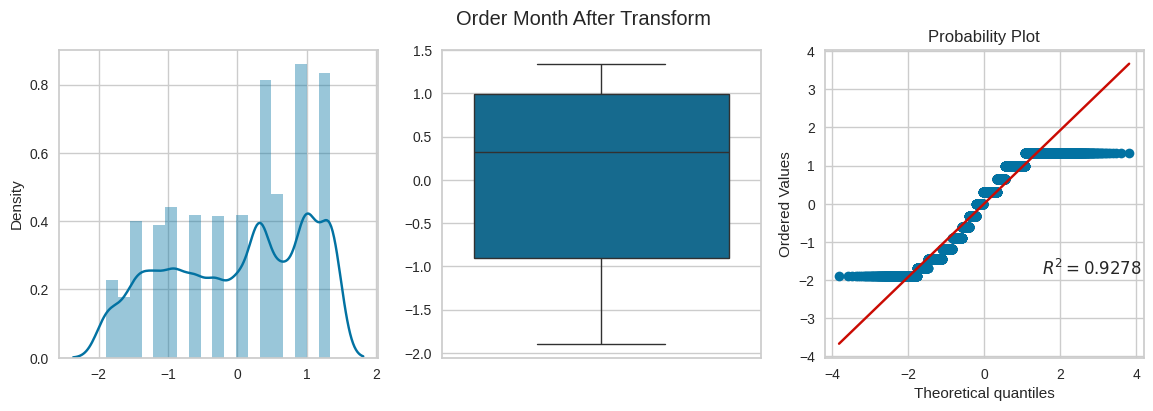

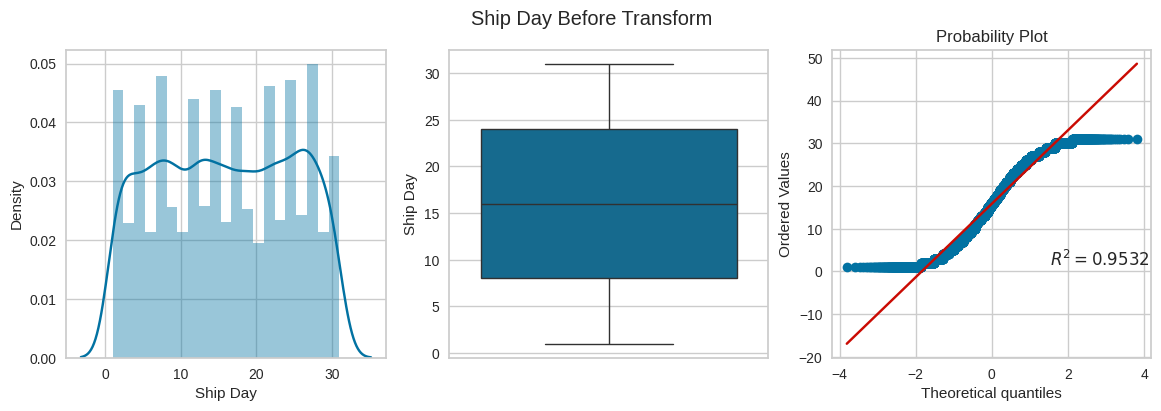

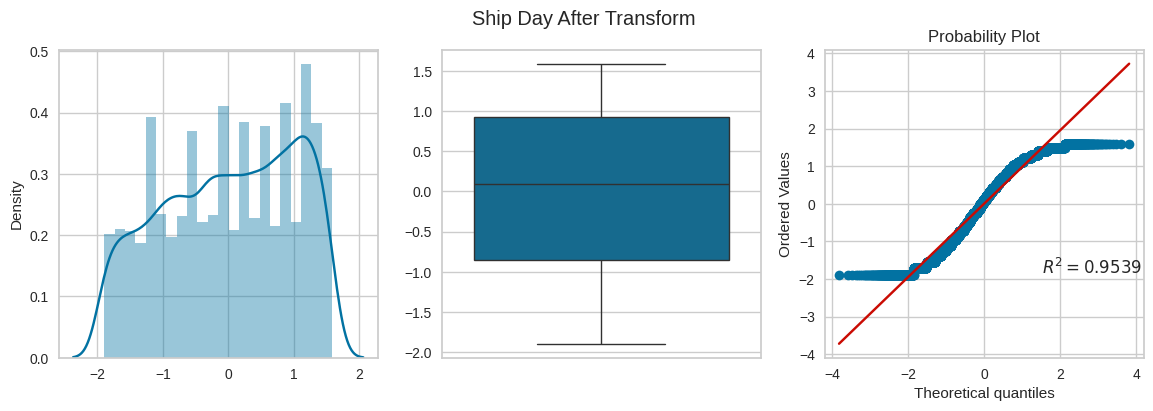

In [ ]:
for col in skewed_cols:
    apply_transform(df,col,PowerTransformer())

**Quantity: Log Transform
Discount: Sqrt Transform
Profit: Log Transform
Profit Margin: Power Transform
Discounted Profit: Log Transform
 Discount Percentage: Power Transform
 Operating Expenses: Power Transform
Net Profit: Log Transform bold text**

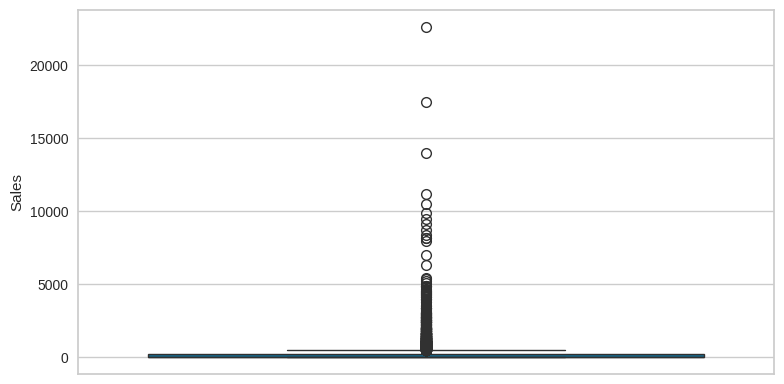

In [ ]:
plt.figure(figsize=(8,4))
fig = sns.boxplot(df['Sales'])
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

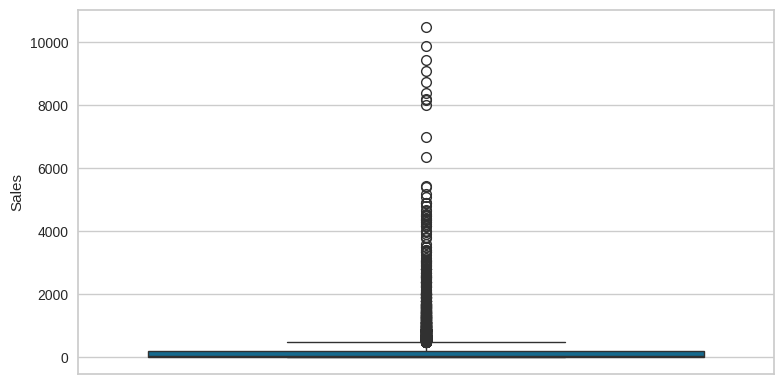

In [ ]:
for idx in list(df[df['Sales'] > 10500].index):
    df.drop(idx,axis=0,inplace=True)
plt.figure(figsize=(8,4))
fig = sns.boxplot(df['Sales'])
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

Feature Splitting

In [ ]:
df.isnull().sum()

Ship Mode              0
Segment                0
City                   0
State                  0
Postal Code            0
Region                 0
Category               0
Sub-Category           0
Product Name           0
Sales                  0
Quantity               0
Discount               0
Profit                 0
Profit Margin          0
Discounted Profit      0
Discount Percentage    0
Operating Expenses     0
Net Profit             0
Order Year             0
Order Month            0
Order Day              0
Order Weekday          0
Ship Year              0
Ship Month             0
Ship Day               0
Ship Weekday           0
dtype: int64

In [ ]:
df = df.dropna()
df.shape

(9989, 26)

In [ ]:
X = df.drop('Sales',axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Feature** **Selection**

In [ ]:
X_train.shape, X_test.shape

((6992, 25), (2997, 25))

In [ ]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('duplicate',DropDuplicateFeatures()),
    ('correlated',DropCorrelatedFeatures())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
X_train.shape, X_test.shape

((6992, 20), (2997, 20))

In [ ]:
def plot_feature_importances(xgb, feat_imp_type: str): # Added xgb as an argument
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())[:10]
    values = list(feat_imps.values())[:10]
    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
    plt.figure(figsize=(12,8))
    fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df,orient='horizontal',palette='viridis')
    plt.title(f"{feat_imp_type.title()} Feature Importance")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect();

In [ ]:
plot_feature_importances('total_gain')

TypeError: plot_feature_importances() missing 1 required positional argument: 'feat_imp_type'

In [ ]:
final_selected_features = ['Profit',
                           'Discount Percentage',
                           'Postal Code',
                           'Discount',
                           'Order Day',
                           'Order Month',
                           'Quantity',
                           'Operating Expenses',
                           'Ship Day',
                           'Order Weekday']

final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

In [ ]:
gc.collect()

31

In [ ]:
final_X_train.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
5215  13.4550             0.000000        92374       0.0         27   
4750  62.8200             0.023878        99207       0.2          8   
2728  94.4937             0.063496        43615       0.4         23   
477    7.1820             0.208855        90008       0.2         13   
1329  16.3020             0.000000        94109       0.0         24   

      Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
5215            9         5             16.4450        27              4  
4750           10         3            774.7800        10              1  
2728           12         7            535.4643        25              1  
477             7         6             88.5780        20              5  
1329            5         3             20.7480        28              4

In [ ]:
final_X_test.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
5842    6.0980             0.000000        92105       0.0         17   
3060   22.4955             0.166700        43055       0.2          8   
8751   31.4712             0.214482        32303       0.2          6   
2665   -2.0108            25.528811        38109       0.7          2   
35    123.4737             0.018223        75080       0.2          9   

      Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
5842           11         5            298.8020        21              5  
3060           11         3             97.4805        13              4  
8751            5         4             61.7768        10              0  
2665            5         2              4.7528         5              3  
35             12         7            974.0703        11              0

In [ ]:
transformer = ColumnTransformer(transformers=[
    ('log_transform',FunctionTransformer(np.log1p),['Quantity','Profit']),
    ('sqrt_transform',FunctionTransformer(np.sqrt),['Discount']),
    ('power_transform',PowerTransformer(),['Discount Percentage','Operating Expenses'])
],remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('log_transform',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['Quantity', 'Profit']),
                                ('sqrt_transform',
                                 FunctionTransformer(func=<ufunc 'sqrt'>),
                                 ['Discount']),
                                ('power_transform', PowerTransformer(),
                                 ['Discount Percentage',
                                  'Operating Expenses'])])

In [ ]:
final_X_train = transformer.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=final_selected_features)
final_X_test = transformer.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=final_selected_features)
final_X_train.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
0  3.332205             1.026672          NaN -0.058055   0.326532   
1  2.197225             0.869742          NaN  0.966424   0.657177   
2  3.178054             1.124748          NaN  1.236290   1.343484   
3  2.639057             1.080418     0.393332 -0.466267  -0.306684   
4  3.218876             0.869742          NaN  0.068872  -0.896824   

   Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
0     0.000000 -0.629495             92374.0      27.0            4.0  
1     0.447214  1.562865             99207.0      10.0            1.0  
2     0.632456  1.387351             43615.0      25.0            1.0  
3     0.447214  0.427733             90008.0      20.0            5.0  
4     0.000000 -0.475783             94109.0      28.0            4.0

In [ ]:
final_X_test.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
0  2.890372             1.026672          NaN -0.569896   0.996334   
1  2.197225             0.869742     0.101695  0.282894   0.996334   
2  1.945910             0.959135     0.415700  0.506651  -0.896824   
3  1.098612             0.741276     1.414628       NaN  -0.896824   
4  2.302585             1.124748          NaN  1.412170   1.343484   

   Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
0     0.000000  1.095709             92105.0      21.0            5.0  
1     0.447214  0.483367             43055.0      13.0            4.0  
2     0.447214  0.213772             32303.0      10.0            0.0  
3     0.836660 -1.461668             38109.0       5.0            3.0  
4     0.447214  1.668160             75080.0      11.0            0.0

Missing Value Imputation

In [ ]:
final_X_train.isna().sum()

Profit                    0
Discount Percentage       0
Postal Code            4570
Discount               1284
Order Day                 0
Order Month               0
Quantity                  0
Operating Expenses        0
Ship Day                  0
Order Weekday             0
dtype: int64

In [ ]:
final_X_test.isnull().sum()

Profit                    0
Discount Percentage       0
Postal Code            1976
Discount                550
Order Day                 0
Order Month               0
Quantity                  0
Operating Expenses        0
Ship Day                  0
Order Weekday             0
dtype: int64

In [ ]:
imputer = SimpleImputer(strategy='median')
final_X_train['Discount Percentage'] = imputer.fit_transform(final_X_train[['Discount Percentage']])
final_X_test['Discount Percentage'] = imputer.fit_transform(final_X_test[['Discount Percentage']])
for col in final_X_train.columns:
    imputer = SimpleImputer(strategy='median')
    final_X_train[col] = imputer.fit_transform(final_X_train[[col]])
final_X_train.isna().sum()

Profit                 0
Discount Percentage    0
Postal Code            0
Discount               0
Order Day              0
Order Month            0
Quantity               0
Operating Expenses     0
Ship Day               0
Order Weekday          0
dtype: int64

In [ ]:
final_X_test.isnull().sum()

Profit                    0
Discount Percentage       0
Postal Code            1976
Discount                550
Order Day                 0
Order Month               0
Quantity                  0
Operating Expenses        0
Ship Day                  0
Order Weekday             0
dtype: int64

**Outlier Treatment**

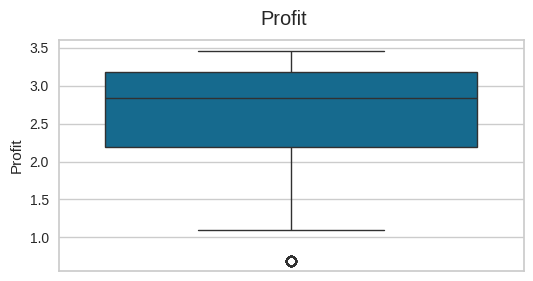

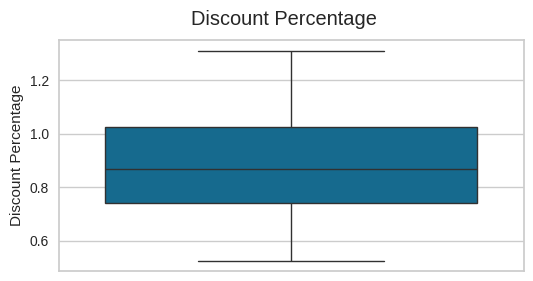

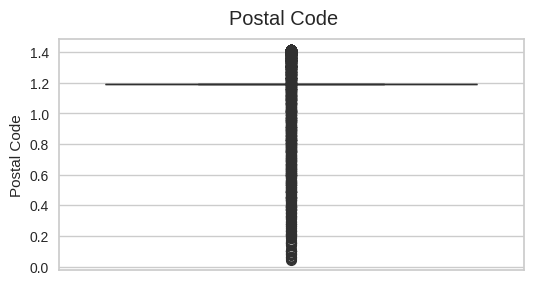

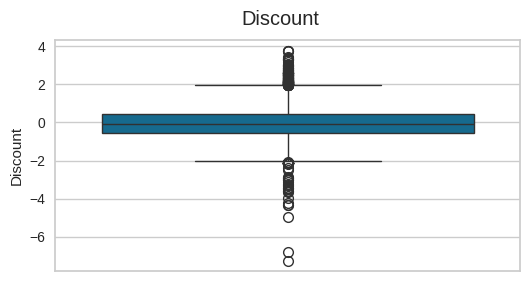

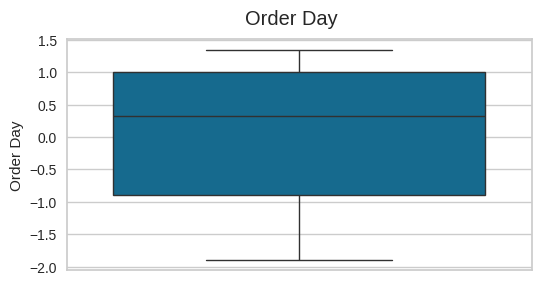

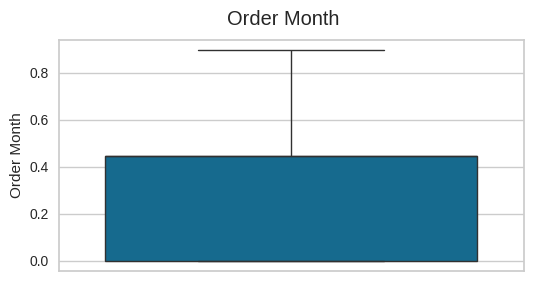

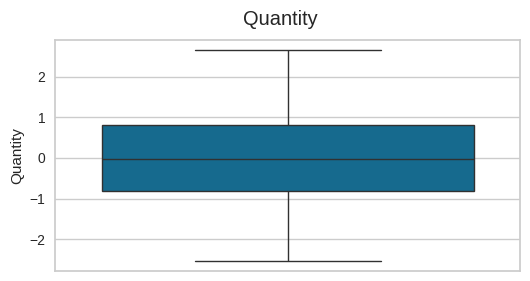

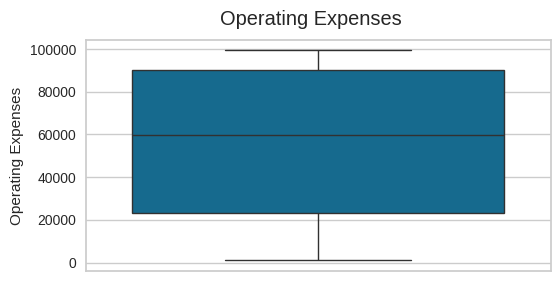

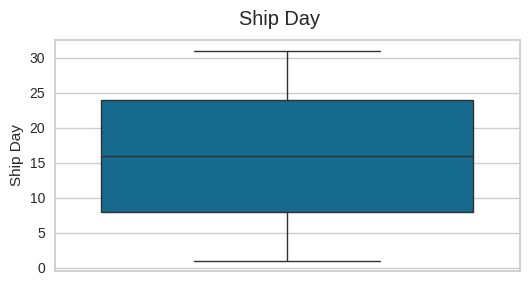

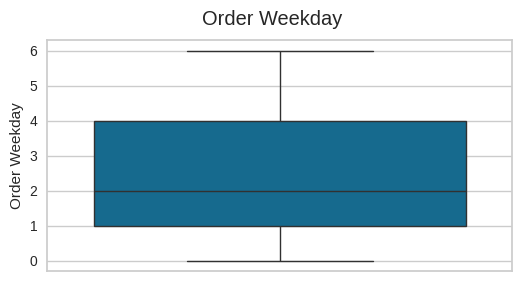

In [ ]:
for col in final_X_train.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(final_X_train[col])
    plt.suptitle(col)
    plt.show()

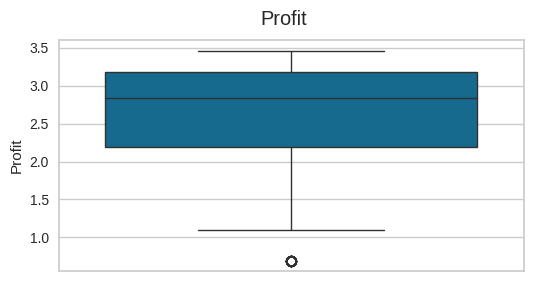

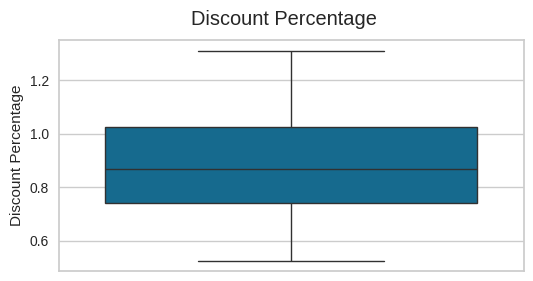

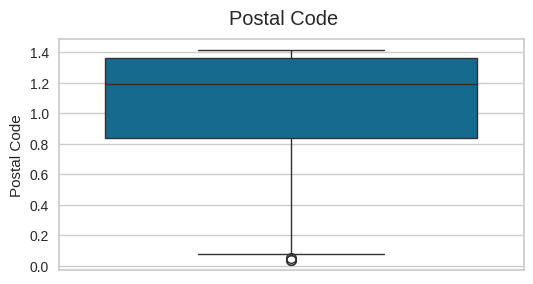

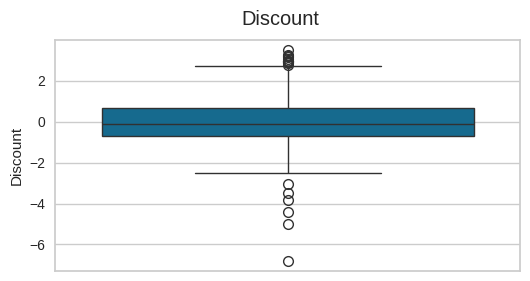

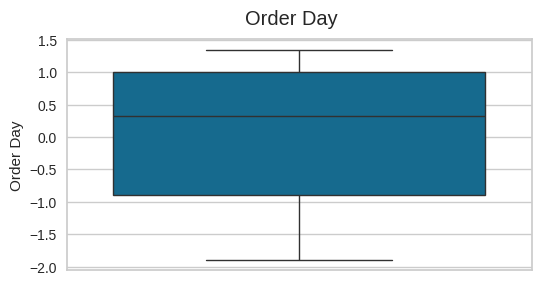

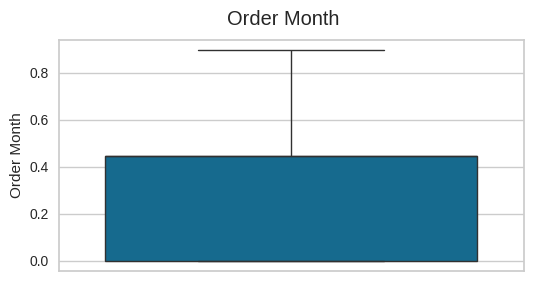

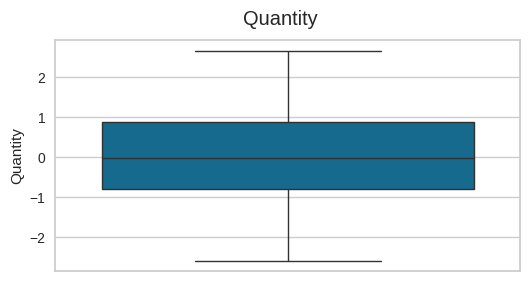

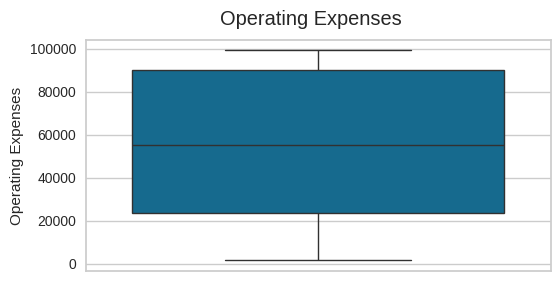

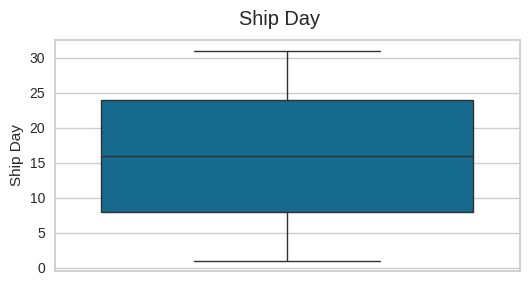

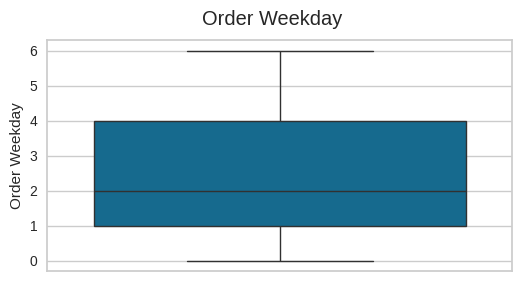

In [ ]:
for col in final_X_test.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(final_X_test[col])
    plt.suptitle(col)
    plt.show()

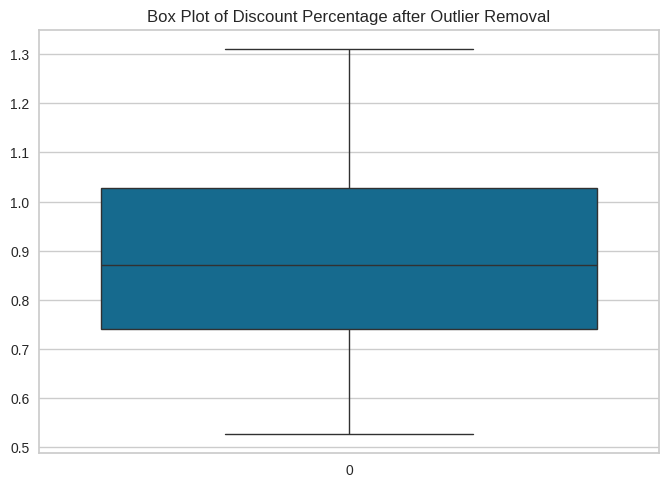

In [ ]:
def impute_outliers(data,col):
    winsorizer = Winsorizer(capping_method='iqr',fold=1.5,tail='both')
    fig = sns.boxplot(winsorizer.fit_transform(data[[col]]).values)
    plt.title(f"Box Plot of {col} after Outlier Removal")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect()
impute_outliers(final_X_train,'Discount Percentage')

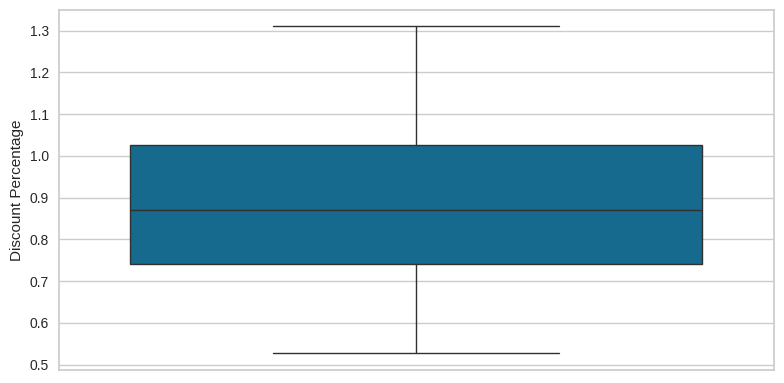

In [ ]:
winsorizer = Winsorizer(capping_method='iqr',fold=1.5,tail='both')
final_X_train['Discount Percentage'] = winsorizer.fit_transform(final_X_train[['Discount Percentage']])
final_X_test['Discount Percentage'] = winsorizer.transform(final_X_test[['Discount Percentage']])
plt.figure(figsize=(8,4))
fig = sns.boxplot(final_X_train['Discount Percentage'])
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

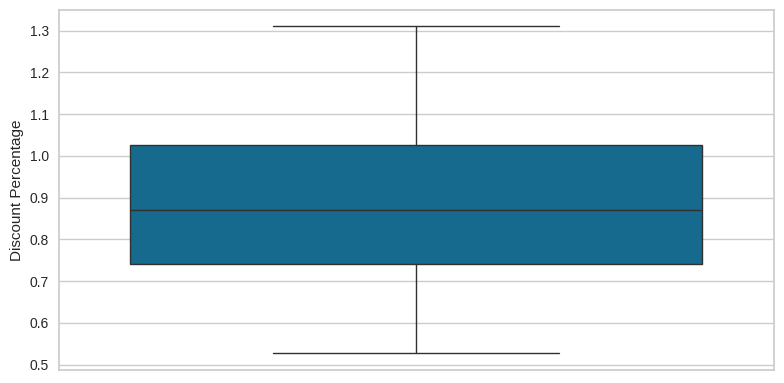

In [ ]:
plt.figure(figsize=(8,4))
fig = sns.boxplot(final_X_test['Discount Percentage'])
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

**Feature Scaling**

In [ ]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
0  1.010139             0.776414     0.202794 -0.048293   0.326532   
1 -0.603258            -0.095233     0.202794  1.084934   0.657177   
2  0.791010             1.321165     0.202794  1.383447   1.343484   
3  0.024816             1.074938    -3.600817 -0.499836  -0.306684   
4  0.849040            -0.095233     0.202794  0.092107  -0.896824   

   Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
0    -0.954332 -0.629495            1.157397  1.267756       0.950772  
1     0.614219  1.562865            1.370418 -0.658716      -0.824025  
2     1.263934  1.387351           -0.362680  1.041112      -0.824025  
3     0.614219  0.427733            1.083637  0.474503       1.542370  
4    -0.954332 -0.475783            1.211486  1.381078       0.950772

In [ ]:

final_X_test.head()

Profit  Discount Percentage  Postal Code  Discount  Order Day  \
0  0.382064             0.776414          NaN -0.614465   0.996334   
1 -0.603258            -0.095233    -4.991053  0.328848   0.996334   
2 -0.960507             0.401289    -3.494189  0.576357  -0.896824   
3 -2.164958            -0.808775     1.267703       NaN  -0.896824   
4 -0.453486             1.321165          NaN  1.577996   1.343484   

   Order Month  Quantity  Operating Expenses  Ship Day  Order Weekday  
0    -0.954332  1.095709            1.149011  0.587825       1.542370  
1     0.614219  0.483367           -0.380138 -0.318750       0.950772  
2     0.614219  0.213772           -0.715335 -0.658716      -1.415623  
3     1.980159 -1.461668           -0.534331 -1.225325       0.359173  
4     0.614219  1.668160            0.618251 -0.545394      -1.415623

In [ ]:
imputer = SimpleImputer(strategy='mean')
y_train = imputer.fit_transform(y_train.values.reshape(-1,1))
y_test = imputer.transform(y_test.values.reshape(-1,1))

**Model Training & Evaluation**

In [ ]:
models = []
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []
training_times = []

In [ ]:
def train_and_evaluate_model(model):
    start_time = time.time()
    model.fit(final_X_train,y_train)
    duration = time.time() - start_time
    y_pred = model.predict(final_X_test)
    r2 = r2_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mape = mean_absolute_percentage_error(y_test,y_pred)
    print("Mean Absolute Error:",mae)
    print("Mean Squared Error:",mse)
    print("Root Mean Squared Error:",rmse)
    print("Mean Absolute Percentage Error:",mape)
    print("R2 Score:",r2)
    print("Training Time:",duration)
    training_times.append(duration)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)
    models.append(model)

    try:
        prediction_error = PredictionError(estimator=model)
        prediction_error.score(final_X_test,y_test)
        prediction_error.show()
        res_plot = ResidualsPlot(estimator=model)
        res_plot.score(final_X_test,y_test)
        res_plot.show()
        del r2, mae, mape, rmse, duration, prediction_error, res_plot
    except Exception as e:
        pass

    gc.collect()

Mean Absolute Error: 205.9358986451666
Mean Squared Error: 151704.6501321474
Root Mean Squared Error: 389.4928113998349
Mean Absolute Percentage Error: 9.992026731228757
R2 Score: 0.41503103209920167
Training Time: 0.009024858474731445


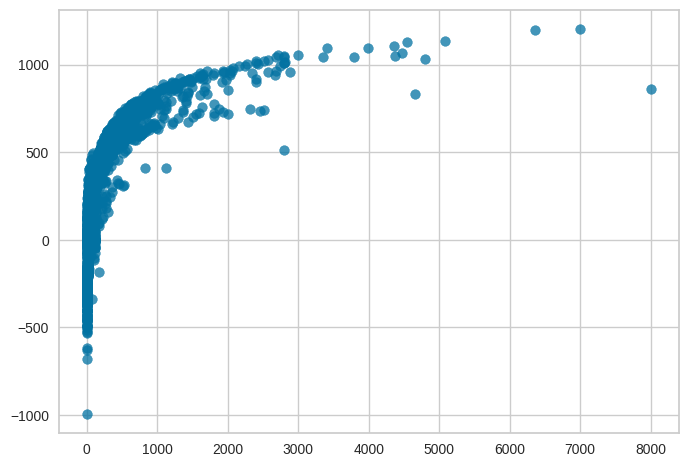

In [ ]:
train_and_evaluate_model(LinearRegression())

Mean Absolute Error: 153.7040779279091
Mean Squared Error: 193959.9617967774
Root Mean Squared Error: 440.40885753669556
Mean Absolute Percentage Error: 4.26364097831675
R2 Score: 0.25209570987108454
Training Time: 0.029607772827148438


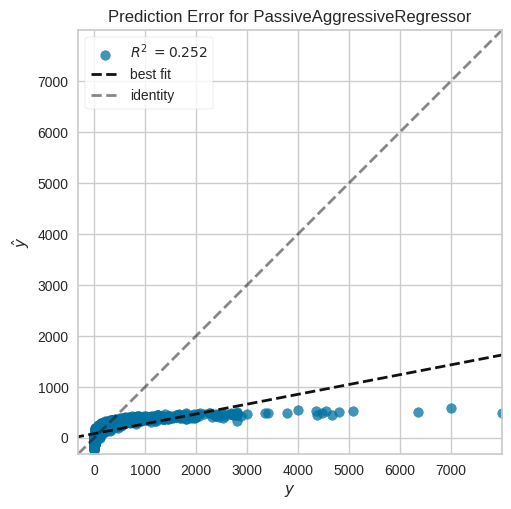

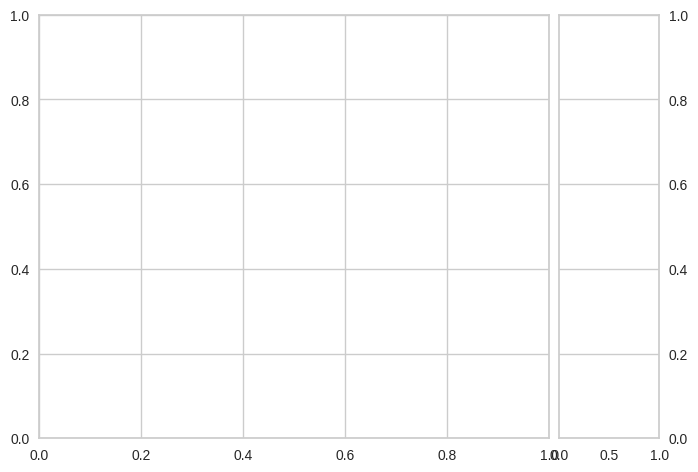

In [ ]:
train_and_evaluate_model(PassiveAggressiveRegressor())


Mean Absolute Error: 208.5413916532708
Mean Squared Error: 151728.48903221538
Root Mean Squared Error: 389.52341268814047
Mean Absolute Percentage Error: 10.345296400388177
R2 Score: 0.4149391099547155
Training Time: 0.02832794189453125


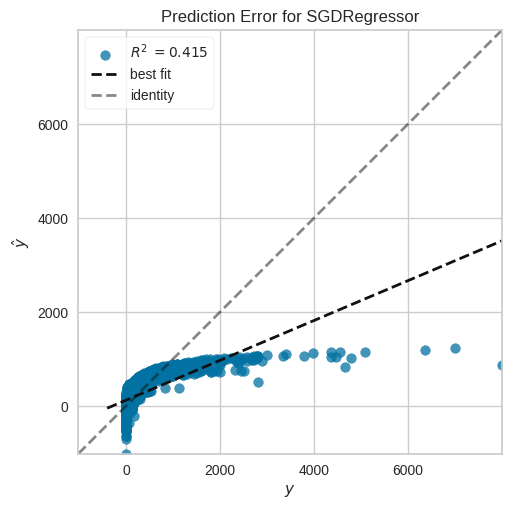

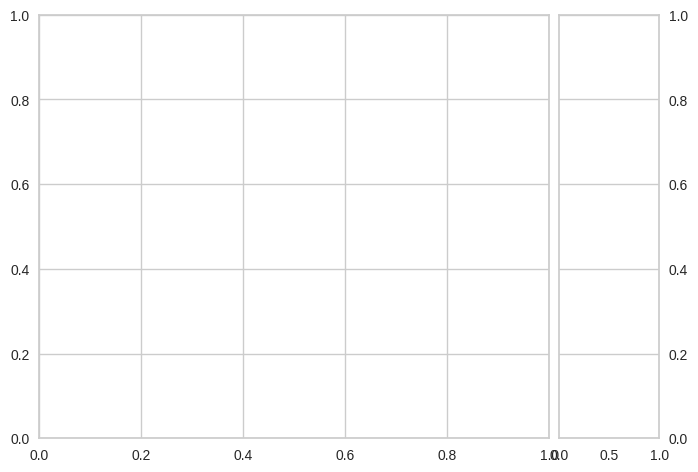

In [ ]:
train_and_evaluate_model(SGDRegressor())


Mean Absolute Error: 205.93588290677508
Mean Squared Error: 151704.650210784
Root Mean Squared Error: 389.49281150078235
Mean Absolute Percentage Error: 9.99202537208929
R2 Score: 0.415031031795981
Training Time: 0.01658773422241211


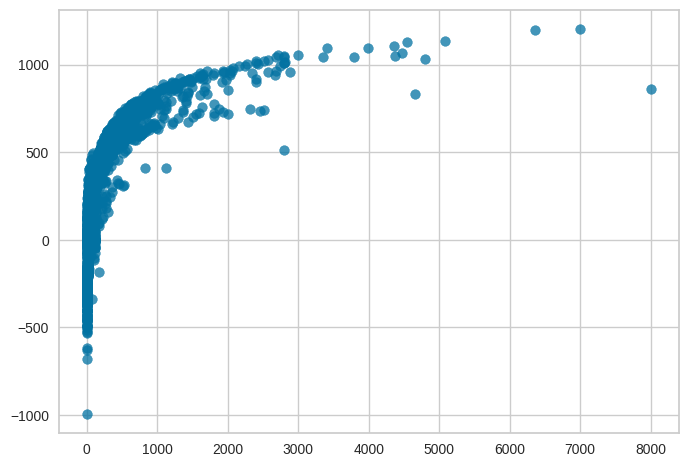

In [ ]:
train_and_evaluate_model(Ridge(alpha=0.001))


Mean Absolute Error: 183.76627405325692
Mean Squared Error: 163492.72762707825
Root Mean Squared Error: 404.3423396418909
Mean Absolute Percentage Error: 6.48153964685905
R2 Score: 0.3695765287617123
Training Time: 0.024323225021362305


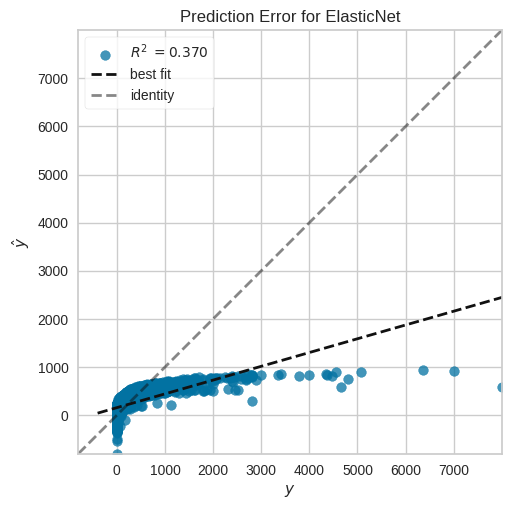

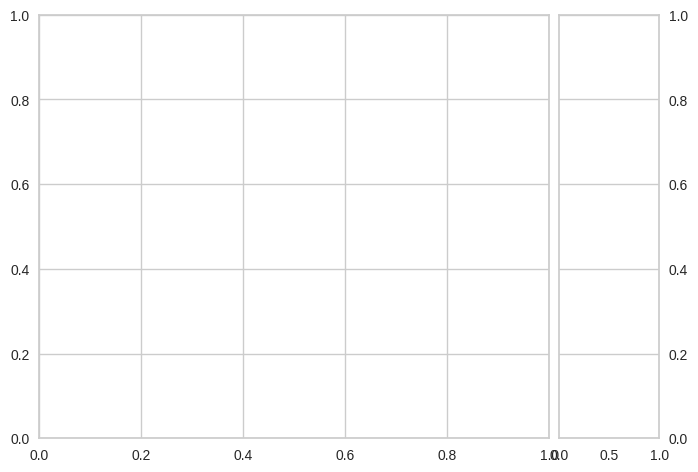

In [ ]:
train_and_evaluate_model(ElasticNet(l1_ratio=0.3))


In [ ]:

train_and_evaluate_model(PoissonRegressor())


Mean Absolute Error: 32.433088748707874
Mean Squared Error: 14283.012921154701
Root Mean Squared Error: 119.51155978044426
Mean Absolute Percentage Error: 0.29742903902596235
R2 Score: 0.9449250941238543
Training Time: 0.0814363956451416


Mean Absolute Error: 146.26374092100147
Mean Squared Error: 221738.81422854026
Root Mean Squared Error: 470.8915100408376
Mean Absolute Percentage Error: 1.2794668808447638
R2 Score: 0.14498121718861245
Training Time: 6.015796184539795


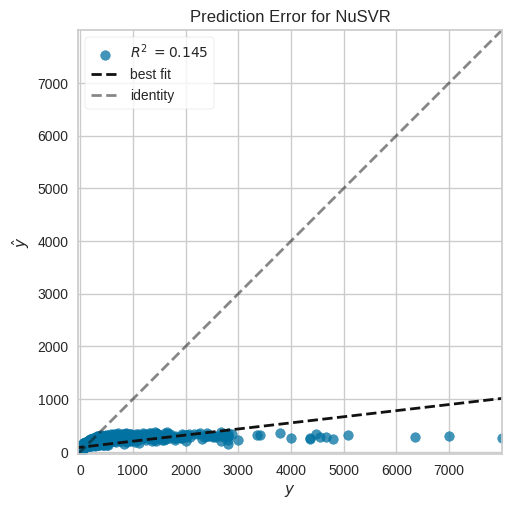

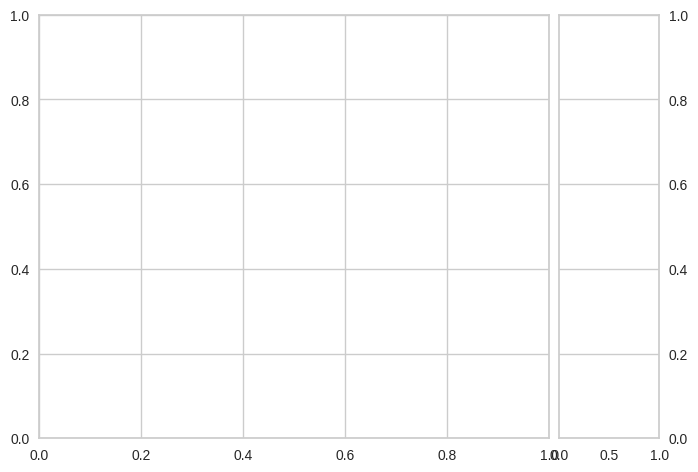

In [ ]:
train_and_evaluate_model(NuSVR())

Mean Absolute Error: 15.114074174174176
Mean Squared Error: 5690.279721568855
Root Mean Squared Error: 75.43394276828472
Mean Absolute Percentage Error: 0.05663027600610358
R2 Score: 0.9780584375436517
Training Time: 0.11312103271484375


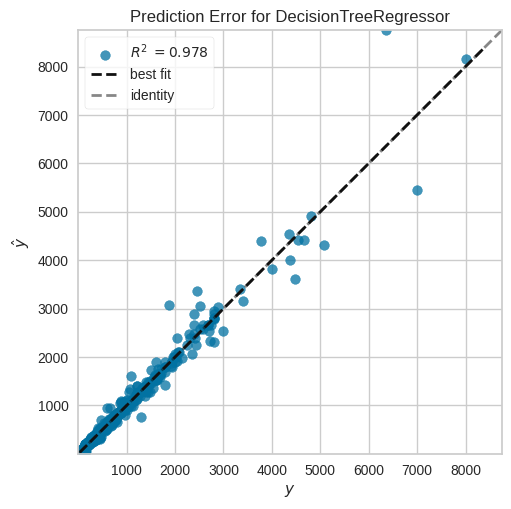

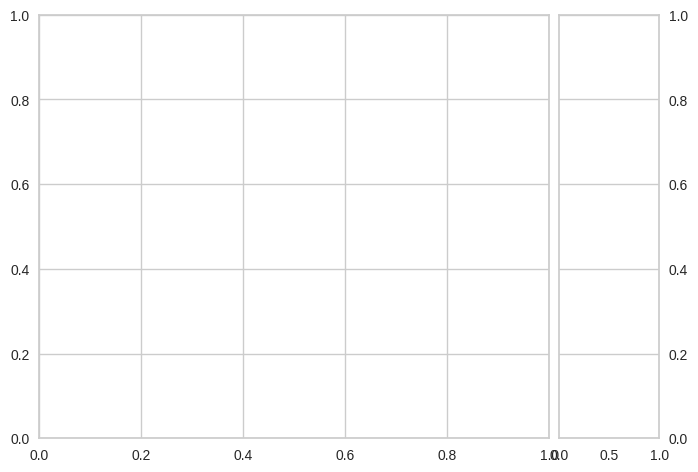

In [ ]:
train_and_evaluate_model(DecisionTreeRegressor())


Mean Absolute Error: 7.054811714714728
Mean Squared Error: 2722.418755159864
Root Mean Squared Error: 52.17680284532451
Mean Absolute Percentage Error: 0.01689582815705697
R2 Score: 0.9895024279874585
Training Time: 4.550817251205444


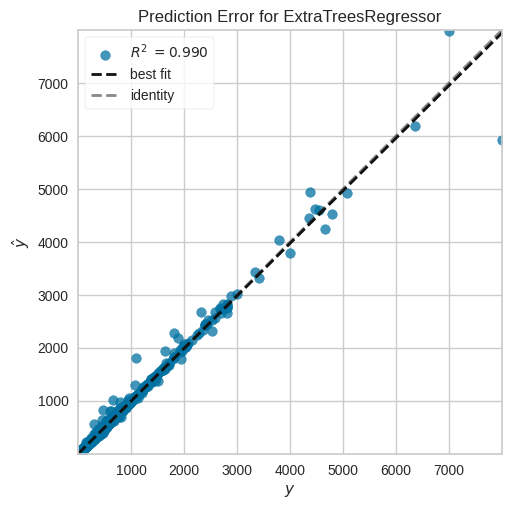

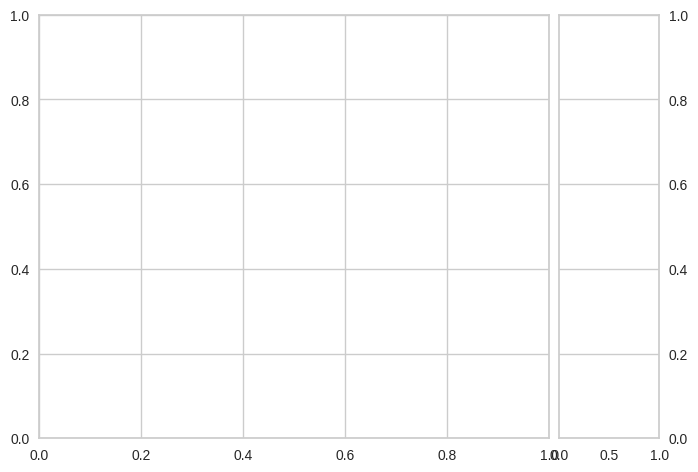

In [ ]:
train_and_evaluate_model(ExtraTreesRegressor())


Mean Absolute Error: 10.570274848181516
Mean Squared Error: 2488.246980616479
Root Mean Squared Error: 49.88233134704591
Mean Absolute Percentage Error: 0.03656679272908295
R2 Score: 0.9904053879240643
Training Time: 0.6882069110870361


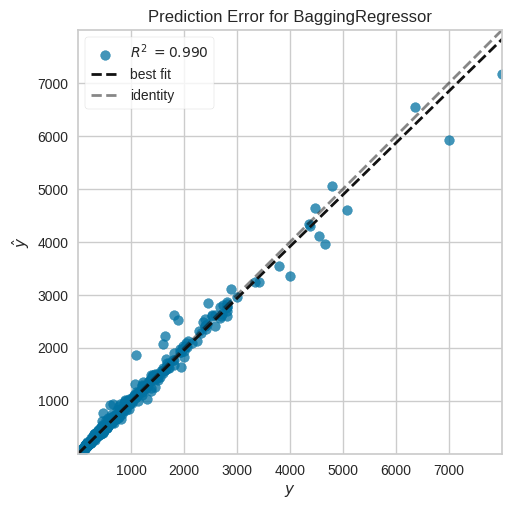

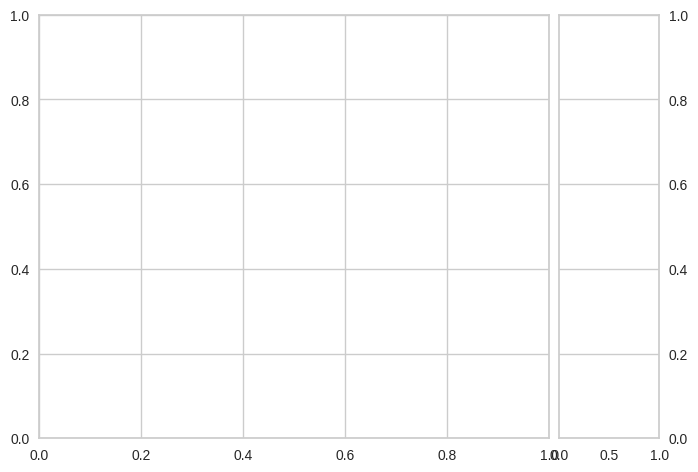

In [ ]:
train_and_evaluate_model(BaggingRegressor())


Mean Absolute Error: 14.516893223847664
Mean Squared Error: 3578.4311535031707
Root Mean Squared Error: 59.819989581269326
Mean Absolute Percentage Error: 0.16815320100428627
R2 Score: 0.9862016676697425
Training Time: 2.35265851020813


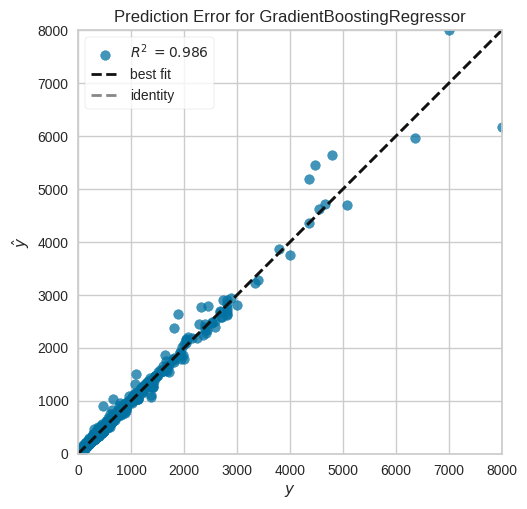

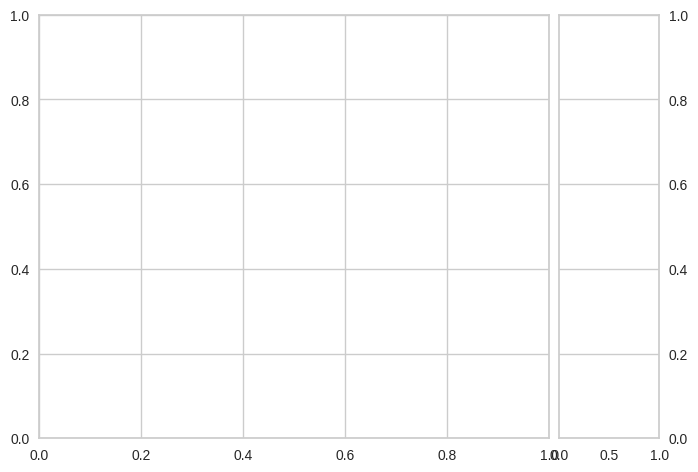

In [ ]:
train_and_evaluate_model(GradientBoostingRegressor())


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 6992, number of used features: 10
[LightGBM] [Info] Start training from score 220.541836
Mean Absolute Error: 16.360537097493452
Mean Squared Error: 10222.153540363353
Root Mean Squared Error: 101.10466626404221
Mean Absolute Percentage Error: 0.13662140283186405
R2 Score: 0.960583656459963
Training Time: 0.4871025085449219


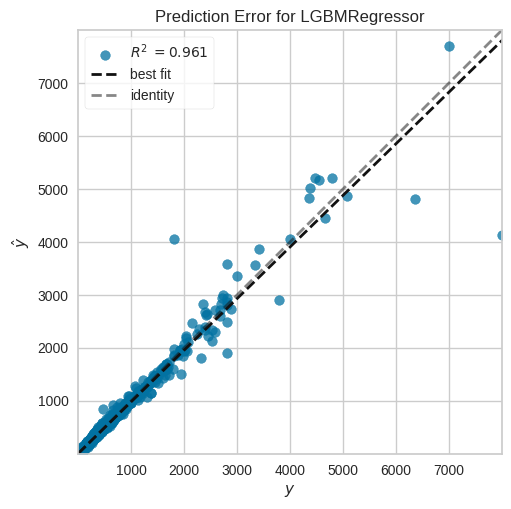

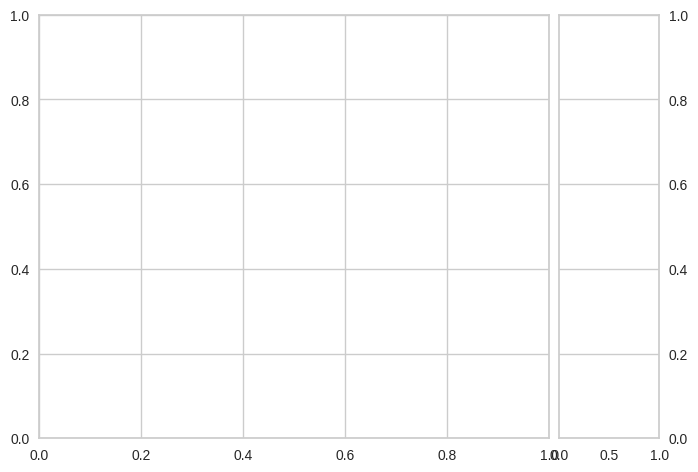

In [ ]:
train_and_evaluate_model(LGBMRegressor())


**Performance** **Comparison**

In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'R2': r2_scores,
                            'MAE': mape_scores,
                            'MSE': mse_scores,
                            'RMSE': rmse_scores,
                            'Training Time': training_times}).sort_values('R2',ascending=False).reset_index(drop=True)
model_perfs

Model        R2        MAE  \
0   (DecisionTreeRegressor(random_state=553987810)...  0.990405   0.036567   
1   (ExtraTreeRegressor(random_state=1853559396), ...  0.989502   0.016896   
2   ([DecisionTreeRegressor(criterion='friedman_ms...  0.986202   0.168153   
3                             DecisionTreeRegressor()  0.978058   0.056630   
4                                     LGBMRegressor()  0.960584   0.136621   
5                                  PoissonRegressor()  0.944925   0.297429   
6                                  LinearRegression()  0.415031   9.992027   
7                                  Ridge(alpha=0.001)  0.415031   9.992025   
8                                      SGDRegressor()  0.414939  10.345296   
9                            ElasticNet(l1_ratio=0.3)  0.369577   6.481540   
10                       PassiveAggressiveRegressor()  0.252096   4.263641   
11                                            NuSVR()  0.144981   1.279467   

              MSE        RMSE  Training Time  
0     2488.246981   49.882331       0.688207  
1     2722.418755   52.176803       4.550817  
2     3578.431154   59.819990       2.352659  
3     5690.279722   75.433943       0.113121  
4    10222.153540  101.104666       0.487103  
5    14283.012921  119.511560       0.081436  
6   151704.650132  389.492811       0.009025  
7   151704.650211  389.492812       0.016588  
8   151728.489032  389.523413       0.028328  
9   163492.727627  404.342340       0.024323  
10  193959.961797  440.408858       0.029608  
11  221738.814229  470.891510       6.015796

**Cross Validation & Hyperparameter Tuning**

In [ ]:
print(f"Mean cross validation training R2 score of Extra Trees Regressor: {round(np.mean(cross_val_score(model_perfs['Model'].iloc[0],final_X_train,y_train,cv=5,scoring='r2',verbose=0))*100,2)}%")


Mean cross validation training R2 score of Extra Trees Regressor: 93.04%


In [ ]:
print(f"Mean cross validation test R2 score of Extra Trees Regressor: {round(np.mean(cross_val_score(model_perfs['Model'].iloc[0],final_X_test,y_test,cv=5,scoring='r2',verbose=0))*100,2)}%")


Mean cross validation test R2 score of Extra Trees Regressor: 90.4%


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=2, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=2, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=2, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=2, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=2, p=1, weights=distance; total time=   0.2s
[CV] END algorithm=brute, metric=euclidean, n_neighbors=20, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=brute, metric=euclidean, n_neighbors=20, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=brute, metric=euclidean, n_neighbors=20, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=brute, metric=euclidean, n_neighbors=20, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=b

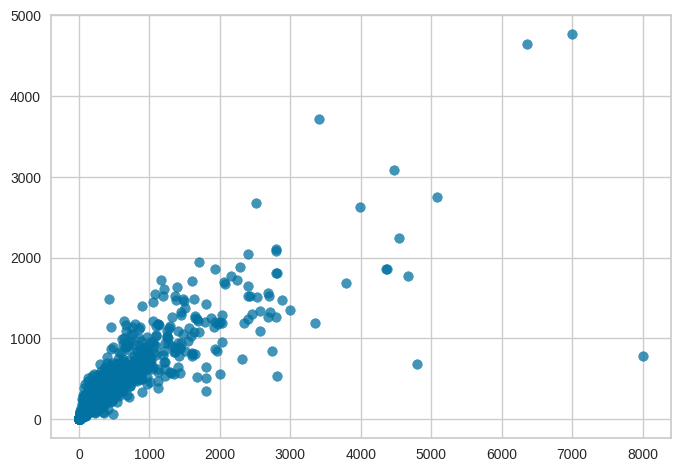

In [ ]:
param_grid = {'n_neighbors': [2,8,12,20],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree', 'brute', 'kd_tree'],
              'metric': ['minkowski','manhattan','euclidean','chebyshev'],
              'p': [1,2]
             }

grid_knn = RandomizedSearchCV(KNeighborsRegressor(),param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_knn)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=quantile, max_bins=0; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=quantile, max_bins=0; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=quantile, max_bins=0; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=quantile, max_bins=0; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=quantile, max_bins=0; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=0.8, loss=absolute_error, max_bins=200; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=0.8, loss=absolute_error, max_bins=200; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=0.8, loss=absolute_error, max_bins=200; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=0.8, loss=ab

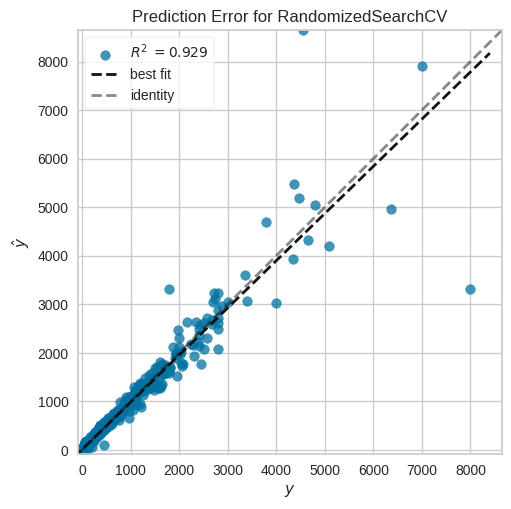

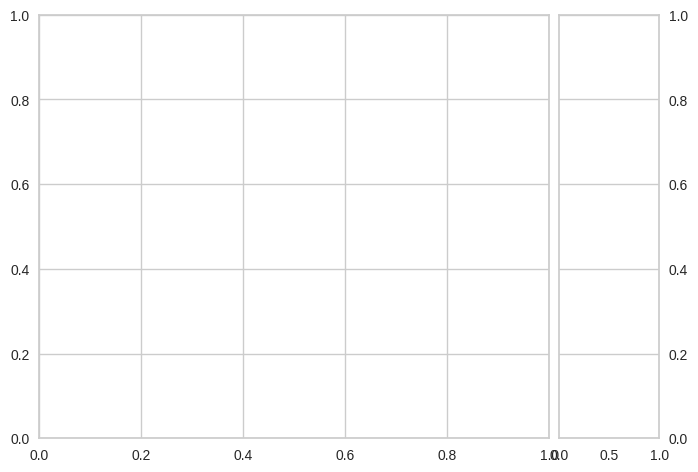

In [ ]:
param_grid = {'learning_rate': [0.2,0.4,0.5,0.8,1.0],
              'loss': ['squared_error','absolute_error','poisson','quantile'],
              'max_bins': np.arange(0,255,50),
              'interaction_cst': ['pairwise','no_interaction']}

grid_hgb = RandomizedSearchCV(HistGradientBoostingRegressor(),param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_hgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 205.84058596076403
Mean Squared Error: 151706.96157971438
Root Mean Squared Error: 389.4957786417131
Mean Absolute Percentage Error: 9.98941104886152
R2 Score: 0.4150221192208129
Training Time: 18.939171075820923


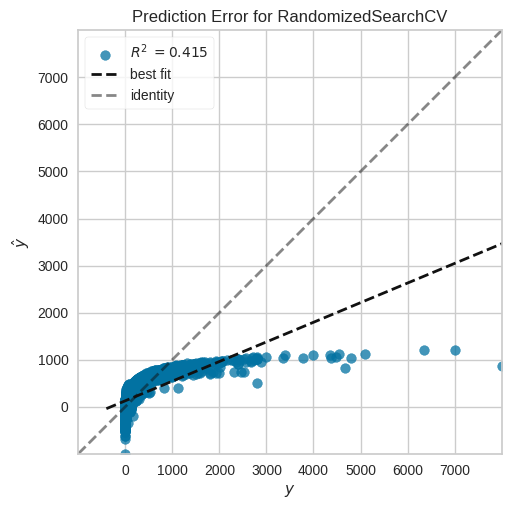

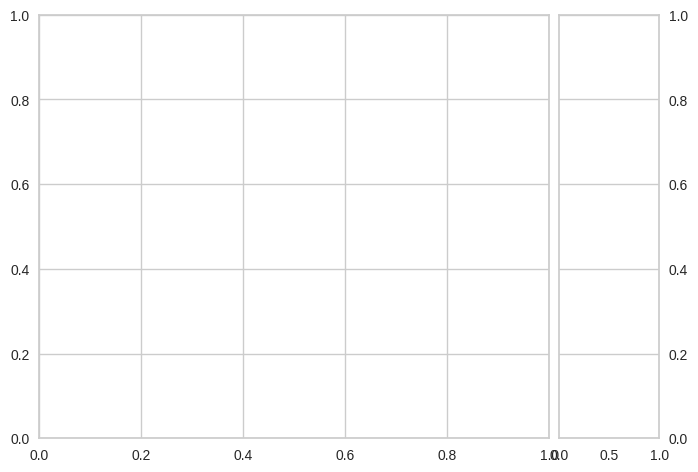

In [ ]:
param_grid = {'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
             'C': [0.0001,0.001,0.01,0.1,1],
             'epsilon': np.linspace(0.001,1,5)}

grid_lsvr = RandomizedSearchCV(LinearSVR(),param_grid,cv=5,verbose=2,n_jobs=10)
train_and_evaluate_model(grid_lsvr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=poisson, max_features=log2, splitter=best; total time=   0.1s
[CV] END criterion=poisson, max_features=log2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_features=log2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_features=log2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_features=log2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=auto, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=auto, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=auto, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=auto, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=auto, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_features=log2, splitter=best; total time=   0.0s
[CV] END

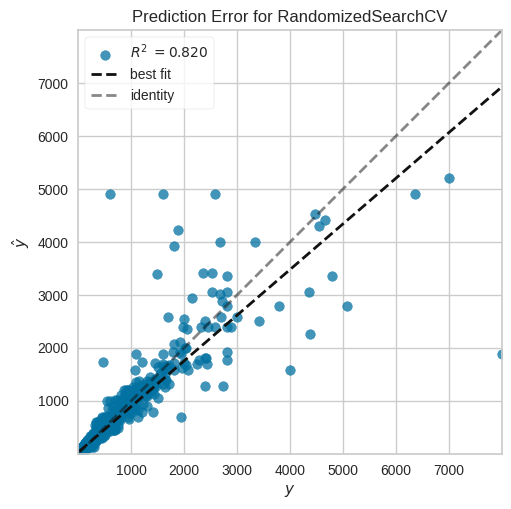

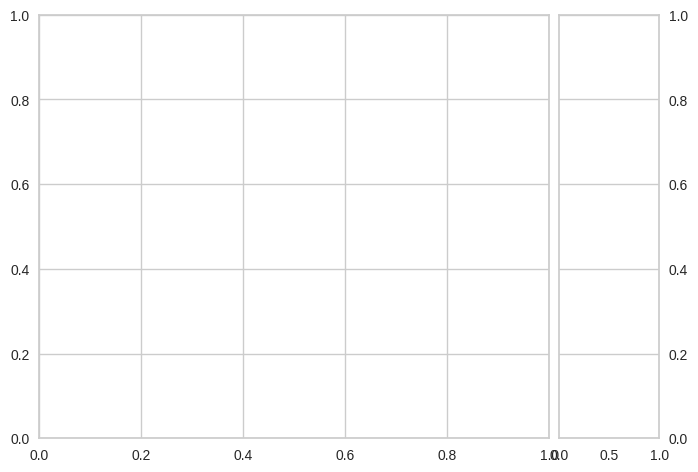

In [ ]:
param_grid = {'criterion': ['squared_error','friedman_mse','absolute_error','poisson'],
              'splitter': ['best','random'],
              'max_features': ['auto','sqrt','log2']
             }

grid_dt = RandomizedSearchCV(DecisionTreeRegressor(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_dt)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Start training from score 220.746981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

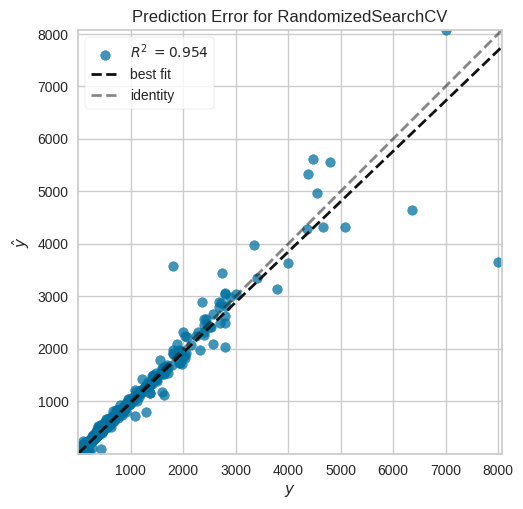

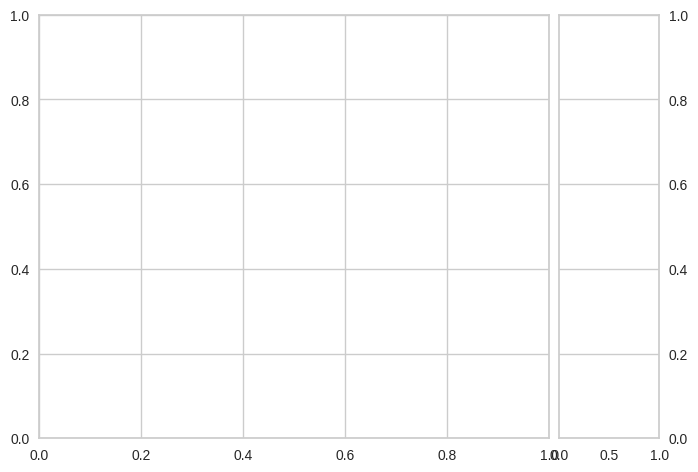

In [ ]:
param_grid = {'boosting_type': ['gbdt','dart','goss','rf'],
            'learning_rate': np.linspace(0,1,6)[1:],
            'n_estimators': [100,300,500,800,1000],
            'importance_type': ['split','gain'],
            'min_split_gain': [0.68,0.79,0.87,1]}

grid_lgbm = RandomizedSearchCV(LGBMRegressor(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END booster=gblinear, importance_type=weight, learning_rate=1, n_estimators=500; total time=   0.1s
[CV] END booster=gblinear, importance_type=weight, learning_rate=1, n_estimators=500; total time=   0.1s
[CV] END booster=gblinear, importance_type=weight, learning_rate=1, n_estimators=500; total time=   0.0s
[CV] END booster=gblinear, importance_type=weight, learning_rate=1, n_estimators=500; total time=   0.2s
[CV] END booster=gblinear, importance_type=weight, learning_rate=1, n_estimators=500; total time=   0.0s
[CV] END booster=gblinear, importance_type=gain, learning_rate=0.1, n_estimators=800; total time=   0.0s
[CV] END booster=gblinear, importance_type=gain, learning_rate=0.1, n_estimators=800; total time=   0.0s
[CV] END booster=gblinear, importance_type=gain, learning_rate=0.1, n_estimators=800; total time=   0.0s
[CV] END booster=gblinear, importance_type=gain, learning_rate=0.1, n_estimators=800; total time=  

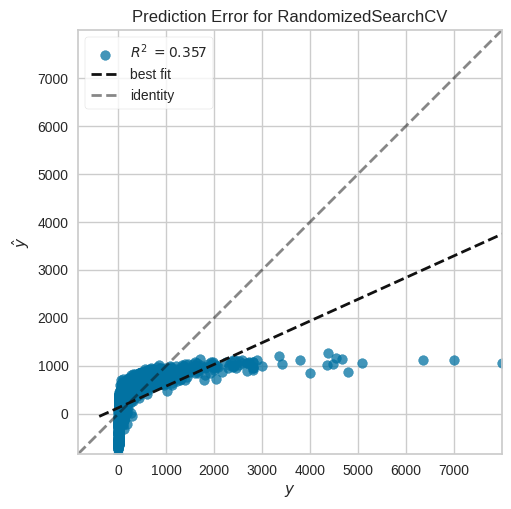

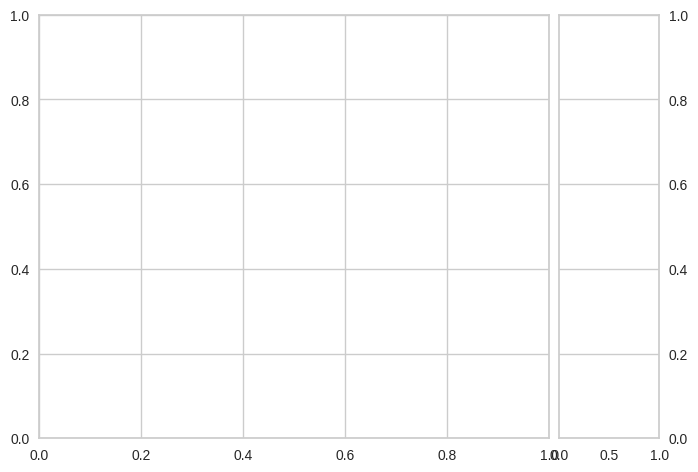

In [ ]:
param_grid = {
    'n_estimators': [200,500,800,1000],
    'learning_rate': [0.001,0.01,0.1,1],
    'booster': ['gbtree','dart','gblinear'],
    'importance_type': ['gain','weight','cover','total_gain','total_cover']
}

grid_xgbrf = RandomizedSearchCV(estimator=XGBRFRegressor(),param_distributions=param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_xgbrf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.25, n_estimators=1000, oob_score=False, warm_start=True; total time=  11.0s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.25, n_estimators=1000, oob_score=False, warm_start=True; total time=  11.0s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.25, n_estimators=1000, oob_score=False, warm_start=True; total time=  11.1s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.25, n_estimators=1000, oob_score=False, warm_start=True; total time=  11.0s
[CV] END bootstrap=False, bootstrap_features=True, max_features=0.5, max_samples=0.25, n_estimators=1000, oob_score=False, warm_start=True; total time=  10.0s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.75, n_estimators=1000, oob_score=True, warm_start=False; total

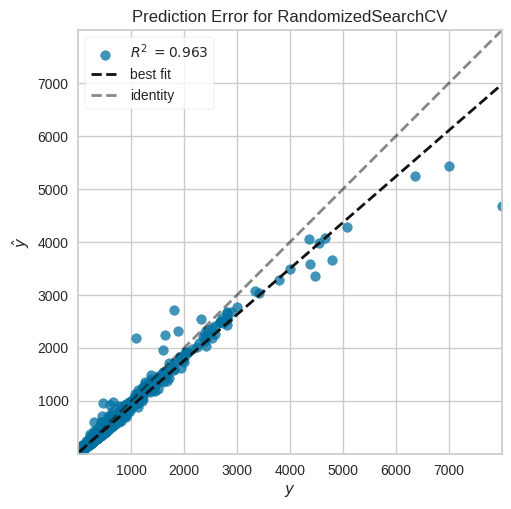

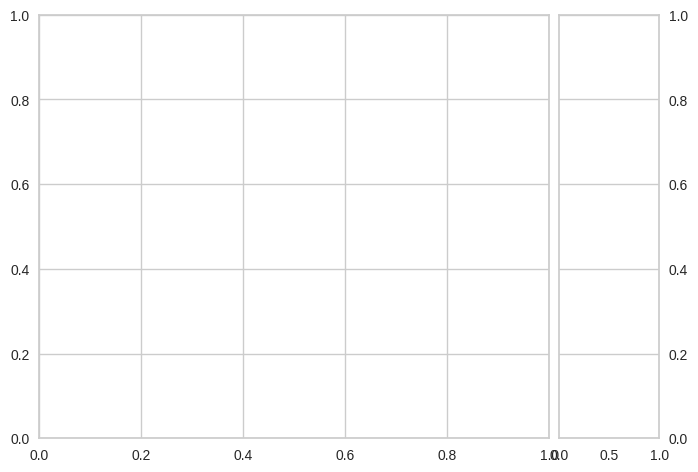

In [ ]:
param_grid = {
    'n_estimators': [200,500,800,1000],
    'max_samples': [0.25,0.5,0.75,1],
    'max_features': [0.5,0.65,0.85,1],
    'bootstrap': [True,False],
    'oob_score': [True,False],
    'bootstrap_features': [True,False],
    'warm_start': [True,False]
}

grid_bag = RandomizedSearchCV(estimator=BaggingRegressor(),param_distributions=param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_bag)

**Optimized** **Models Performance Comparison**

In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'R2': r2_scores,
                            'RMSE': rmse_scores,
                            'MAPE': mape_scores,
                            'MSE': mse_scores,
                            'Training Time': training_times}).sort_values('R2',ascending=False).reset_index(drop=True)
model_perfs[:20]

Model        R2        RMSE  \
0   (DecisionTreeRegressor(random_state=553987810)...  0.990405   49.882331   
1   (ExtraTreeRegressor(random_state=1853559396), ...  0.989502   52.176803   
2   ([DecisionTreeRegressor(criterion='friedman_ms...  0.986202   59.819990   
3                             DecisionTreeRegressor()  0.978058   75.433943   
4   RandomizedSearchCV(cv=5, estimator=BaggingRegr...  0.963133   97.780923   
5                                     LGBMRegressor()  0.960584  101.104666   
6   RandomizedSearchCV(cv=5, estimator=LGBMRegress...  0.954130  109.068069   
7                                  PoissonRegressor()  0.944925  119.511560   
8   RandomizedSearchCV(cv=5, estimator=HistGradien...  0.929229  135.475392   
9   RandomizedSearchCV(cv=5, estimator=DecisionTre...  0.820169  215.955842   
10  RandomizedSearchCV(cv=5, estimator=KNeighborsR...  0.724024  267.527578   
11                                 LinearRegression()  0.415031  389.492811   
12                                 Ridge(alpha=0.001)  0.415031  389.492812   
13  RandomizedSearchCV(cv=5, estimator=LinearSVR()...  0.415022  389.495779   
14                                     SGDRegressor()  0.414939  389.523413   
15                           ElasticNet(l1_ratio=0.3)  0.369577  404.342340   
16  RandomizedSearchCV(cv=5,\n                   e...  0.356574  408.490915   
17                       PassiveAggressiveRegressor()  0.252096  440.408858   
18                                            NuSVR()  0.144981  470.891510   

         MAPE            MSE  Training Time  
0    0.036567    2488.246981       0.688207  
1    0.016896    2722.418755       4.550817  
2    0.168153    3578.431154       2.352659  
3    0.056630    5690.279722       0.113121  
4    0.529920    9561.108981     368.647967  
5    0.136621   10222.153540       0.487103  
6    0.181635   11895.843610     151.329127  
7    0.297429   14283.012921       0.081436  
8    0.227936   18353.581753      11.273154  
9    0.141063   46636.925624       3.647037  
10   0.313346   71571.004893       8.392350  
11   9.992027  151704.650132       0.009025  
12   9.992025  151704.650211       0.016588  
13   9.989411  151706.961580      18.939171  
14  10.345296  151728.489032       0.028328  
15   6.481540  163492.727627       0.024323  
16  13.599076  166864.827501      44.561247  
17   4.263641  193959.961797       0.029608  
18   1.279467  221738.814229       6.015796

Even after tuning the hyperparameters of all the models, the Extra Trees Regressor model stays intact as the best performing model with an outstanding R2 score of more than about **95.6**%.

**Saving the best performing model for deployment into production**

In [ ]:
best_model = model_perfs['Model'].iloc[0]
best_model

BaggingRegressor()

In [ ]:
pipeline = Pipeline(steps=[
        ('transformer',transformer),
        ('scaler',scaler),
        ('model',best_model)
])
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['Quantity', 'Profit']),
                                                 ('sqrt_transform',
                                                  FunctionTransformer(func=<ufunc 'sqrt'>),
                                                  ['Discount']),
                                                 ('power_transform',
                                                  PowerTransformer(),
                                                  ['Discount Percentage',
                                                   'Operating Expenses'])])),
                ('scaler', StandardScaler()), ('model', BaggingRegressor())])

In [ ]:
joblib.dump(pipeline,'pipeline.pkl')

['pipeline.pkl']

In [ ]:
joblib.load('pipeline.pkl')


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['Quantity', 'Profit']),
                                                 ('sqrt_transform',
                                                  FunctionTransformer(func=<ufunc 'sqrt'>),
                                                  ['Discount']),
                                                 ('power_transform',
                                                  PowerTransformer(),
                                                  ['Discount Percentage',
                                                   'Operating Expenses'])])),
                ('scaler', StandardScaler()), ('model', BaggingRegressor())])

In [ ]:
for col in final_X_train.columns:
    print(f"Min value of {col}:",df[col].min())
    print(f"Max value of {col}:",df[col].max())

Min value of Profit: -6599.978000000001
Max value of Profit: 5039.9856
Min value of Discount Percentage: 0.0
Max value of Discount Percentage: 180.1801801801802
Min value of Postal Code: 1040
Max value of Postal Code: 99301
Min value of Discount: 0.0
Max value of Discount: 0.8
Min value of Order Day: 1
Max value of Order Day: 31
Min value of Order Month: 1
Max value of Order Month: 12
Min value of Quantity: 1
Max value of Quantity: 14
Min value of Operating Expenses: 0.5543999999999999
Max value of Operating Expenses: 11839.970399999998
Min value of Ship Day: 1
Max value of Ship Day: 31
Min value of Order Weekday: 0
Max value of Order Weekday: 6


In [ ]:
list(final_X_train.columns)


['Profit',
 'Discount Percentage',
 'Postal Code',
 'Discount',
 'Order Day',
 'Order Month',
 'Quantity',
 'Operating Expenses',
 'Ship Day',
 'Order Weekday']

In [ ]:
pipeline.predict(pd.DataFrame([[3846.91,79.42479138,5937,0.5,8.0,5.0,9.0,6293.46,29.0,3.0]],columns=list(final_X_train.columns)))


array([8883.507])

In [ ]:
gc.collect()

9358

In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2
